In [ ]:
%%capture
try:
  already_installed
except:  
    !pip install kora
    !pip install dgl
    !pip install dgl-cu101
    !pip install --pre dgl-cu101
    !pip install dgllife
    # !pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
    # !pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
    # !pip install -q torch-geometric
    !pip install torch_optimizer
    #!pip install pytorch_lightning
    import sys
    import time
    import dgl
    import dgllife
    import torch 
    import pickle
    from IPython.display import clear_output
    import networkx as nx
    import dgl.function as fn
    from dgl.nn.pytorch import GraphConv
    import torch.nn.functional as F
    import torch.nn as nn
    sys.path.append('/usr/local/lib/python3.6/dist-packages/') # For using RDKit utilizing KORA
    import kora.install.rdkit
    from rdkit import Chem
    from rdkit.Chem import Descriptors
    from rdkit.Chem.Draw import IPythonConsole
    from rdkit.Chem import ChemicalFeatures
    from rdkit import RDConfig
    from dgllife.utils import featurizers as fs
    from torch.utils.data import DataLoader
    import networkx as nx
    import matplotlib.pyplot as plt
    import torch_optimizer as optim
    # import pytorch_lightning as pl  
    # from pytorch_lightning.metrics.classification import AUROC
    # from pytorch_lightning.metrics.classification import AveragePrecision
    # from pytorch_lightning.metrics.classification import Recall
    # from pytorch_lightning.metrics.classification import Precision
    # from pytorch_lightning.metrics.classification import ConfusionMatrix
    from sklearn.metrics import roc_auc_score
    from sklearn.model_selection import train_test_split
    import pandas as pd
    import numpy as np
    import itertools
    import os
    %matplotlib inline
    import warnings
    warnings.filterwarnings("ignore")
    if torch.cuda.is_available(): 
      device = "cuda:0" 
    else:
      device = "cpu" 
    # Fix Seeds
    # Set a seed value
    seed_value= 213 
    # 1. Set `PYTHONHASHSEED` environment variable at a fixed value
    os.environ['PYTHONHASHSEED']=str(seed_value)
    # 2. Set `python` built-in pseudo-random generator at a fixed value
    import random 
    random.seed(seed_value)
    # 3. Set `numpy` pseudo-random generator at a fixed value
    np.random.seed(seed_value)
    # 4. Set `pytorch` pseudo-random generator at a fixed value
    torch.manual_seed(seed_value)
    # 5. Set `dgl` pseudo-random generator at a fixed value
    # if device == "cuda:0":
    #   dgl.seed(seed_value) # dose not work on CPU recently     
    # 6. For layers that introduce randomness like dropout, make sure to set seed values 
    # model.add(Dropout(0.25, seed=seed_value)) 
    already_installed=True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Node and Edge Featurizer

def atom_is_in_ring_list_one_hot(atom, allowable_set=None, encode_unknown=False):
          list = [3,4,5] # List denotes the size of cycles
          return [atom.IsInRing()]+[atom.IsInRingSize(i) for i in list]

def bond_is_in_ring_list_one_hot(bond, allowable_set=None, encode_unknown=False):
          list = [3,4,5] # List denotes the size of cycles
          return [bond.IsInRing()]+[bond.IsInRingSize(i) for i in list]

# Almost the same as DMPNN; Not sure about chirlarity
class CanonicalAtomFeaturizer_without_AF_OH(fs.BaseAtomFeaturizer):
    def __init__(self, atom_data_field='h'):
        super().__init__(
            featurizer_funcs={atom_data_field: fs.ConcatFeaturizer(
                [
                 fs.atomic_number_one_hot,
                 fs.atom_degree_one_hot,
                 fs.atom_formal_charge_one_hot,
                 fs.atom_chiral_tag_one_hot,
                 fs.atom_chirality_type_one_hot, 
                 fs.atom_is_chiral_center,
                 fs.atom_total_num_H_one_hot,
                 fs.atom_hybridization_one_hot,
                 fs.atom_is_aromatic,
                 fs.atom_mass,
                 #fs.atom_explicit_valence_one_hot,
                 #fs.atom_implicit_valence_one_hot,                
                 #fs.atom_num_radical_electrons_one_hot,
                 #fs.atom_is_in_ring,
                 #atom_is_in_ring_list_one_hot
                 ]
            )})

# Same as DMPNN
class CanonicalBondFeaturizer(fs.BaseBondFeaturizer):
       def __init__(self, bond_data_field='e', self_loop=False):
        super(CanonicalBondFeaturizer, self).__init__(
            featurizer_funcs={bond_data_field: fs.ConcatFeaturizer(
                [fs.bond_type_one_hot,
                 fs.bond_is_conjugated,
                 fs.bond_is_in_ring,
                 fs.bond_stereo_one_hot,
                 #fs.bond_direction_one_hot,
                 #bond_is_in_ring_list_one_hot
                 ]
            )}, self_loop=self_loop)
        
BondFeaturizer = CanonicalBondFeaturizer()
AtomFeaturizer = CanonicalAtomFeaturizer_without_AF_OH()

In [ ]:
DATA = 'Tox21 - Random Scaffold Split - Seed 213'
# path to datasets
data = pd.read_csv('https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/tox21.csv.gz',compression='gzip').fillna(-1) # replacing NaN values with -1 to be able to create the mask
train = np.load('/content/drive/MyDrive/GMLG_Research/Data/DeepChem_RandomScaffoldSplit/Tox21_seed_213/train_smiles', allow_pickle=True)
val = np.load('/content/drive/MyDrive/GMLG_Research/Data/DeepChem_RandomScaffoldSplit/Tox21_seed_213/val_smiles', allow_pickle=True)
test = np.load('/content/drive/MyDrive/GMLG_Research/Data/DeepChem_RandomScaffoldSplit/Tox21_seed_213/test_smiles', allow_pickle=True)
global_features = pd.read_csv('/content/drive/MyDrive/GMLG_Research/Data/DeepChem_RandomScaffoldSplit/Tox21_seed_213/tox21_global_cdf_rdkit.zip',compression='zip')        
global_features = torch.Tensor(global_features.fillna(global_features.mean()).iloc[:,1:].values) 

In [ ]:
# Building a data generator for each splitted set

class Dataset_generator(torch.utils.data.Dataset): # for Tox21

    def __init__(self, splitted_data, data, gf):

      # In data NaN values are replaced with -1 #

      self.smiles = []
      self.dgl_graphs = []
      self.global_fetures = torch.empty(0)
      self.labels = torch.empty(0)
      self.masks = torch.empty(0)

      self.data_nan_0 = data.where(data != -1, 0) # replacing -1 with 0 for labels, however, it's only neccenary if mask is not used!

      # replacing non NaN values with 1 and NaNs with 0 for mask
      self.data_mask = data.where(data == -1, 1)
      self.data_mask = self.data_mask.where(self.data_mask != -1, 0)

      for i in range(len(splitted_data)):
         
        # finding its id in the main dataset and golbal feature set 
        id = pd.Index(data.smiles).get_loc(splitted_data[i])

        mol =  Chem.MolFromSmiles(splitted_data[i])

        self.smiles.append(splitted_data[i])

        self.dgl_graphs.append(dgllife.utils.mol_to_bigraph(mol, canonical_atom_order=False))

        self.dgl_graphs[i].ndata['h_0'] = AtomFeaturizer(mol)['h']

        # for the case encoutring a bondless compound; it can be deal while working on batches of graphs 
        try:
          self.dgl_graphs[i].edata['e_0'] = BondFeaturizer(mol)['e']
        except:
          print(splitted_data[i], "is bondless; I pass")

        self.global_fetures = torch.cat((self.global_fetures, gf[id].view(1,-1)),0)

        self.labels = torch.cat((self.labels, torch.Tensor(self.data_nan_0.iloc[id,:12]).view(1,-1)),0)
        
        self.masks = torch.cat((self.masks, torch.Tensor(self.data_mask.iloc[id,:12]).view(1,-1)),0)

    def __len__(self):

        return len(self.smiles)

    def __getitem__(self, idx):

        return  self.smiles[idx], self.dgl_graphs[idx], self.global_fetures[idx], self.labels[idx], self.masks[idx]

train_set = Dataset_generator(train, data, global_features)
val_set = Dataset_generator(val, data, global_features)
test_set = Dataset_generator(test, data, global_features)


def collate(batch):
    # batch is a list of triples (graphs, labels, masks)
    # Concatenate a sequence of graphs
    
    smiles = [e[0] for e in batch]
    
    graphs = [e[1] for e in batch]
    g = dgl.batch(graphs)

    gf = [e[2] for e in batch]
    gf = torch.stack(gf, 0)

    # Concatenate a sequence of tensors (labels) along a new dimension
    labels = [e[3] for e in batch]
    labels = torch.stack(labels, 0)

    # Concatenate a sequence of tensors (masks) along a new dimension
    masks = [e[4] for e in batch]
    masks = torch.stack(masks, 0)

    return smiles, g, gf, labels, masks

def loader(batch_size=64):

    train_dataloader = DataLoader(train_set,
                              batch_size=batch_size,
                              collate_fn=collate,
                              drop_last=False,
                              shuffle=True)

    val_dataloader =  DataLoader(val_set,
                             batch_size=batch_size,
                             collate_fn=collate,
                             drop_last=False,
                             shuffle=False)

    test_dataloader = DataLoader(test_set,
                             batch_size=batch_size,
                             collate_fn=collate,
                             drop_last=False,
                             shuffle=False)
    
    return train_dataloader, val_dataloader, test_dataloader 


RDKit WARNING: [08:43:02] WARNING: not removing hydrogen atom without neighbors


[I-].[K+] is bondless; I pass
[Hg+2] is bondless; I pass
[Ba+2] is bondless; I pass
[TlH2+] is bondless; I pass
[Cr+3] is bondless; I pass
[Fe+2] is bondless; I pass
[Co+2] is bondless; I pass
[PbH2+2] is bondless; I pass
[Fe+3] is bondless; I pass
[Cu+2] is bondless; I pass
[Cd+2] is bondless; I pass
[SnH2+2] is bondless; I pass
[Mn+2] is bondless; I pass
[Be+2] is bondless; I pass
[Zn+2] is bondless; I pass
[Br-].[Na+] is bondless; I pass
[Ca+2].[Cl-].[Cl-] is bondless; I pass
[SbH6+3] is bondless; I pass
[Ni+2] is bondless; I pass


In [ ]:
# borrowed form: https://stackoverflow.com/a/62508086
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
#count_parameters(model)

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

def my_loss(output, label, mask=None):
    criterion = nn.BCELoss(reduction='none')
    if mask == None:
        loss = torch.sum(torch.mean(criterion(output,label), axis=1))
    else: 
        loss = torch.sum(torch.mean(mask*criterion(output,label), axis=1))
    return loss 

def train_model(model, batch_size, optimizer, patience=10, n_epochs=1):
    #metric=AUROC()
    metric = roc_auc_score
    train_dataloader, val_dataloader, test_dataloader  = loader(batch_size)
    train_losses = []
    val_losses = []
    test_aucs = []
    early_stopping = EarlyStopping(patience=patience, verbose=True) # initialize the early_stopping object
    start_time = time.time()
    #optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(1, n_epochs+1):
        epoch_train_loss = 0
        epoch_val_loss = 0
        
        model.train() #Prepare model for training
        for i, (_, mol_dgl_graph, fg, labels, masks) in enumerate(train_dataloader):
            mol_dgl_graph=mol_dgl_graph.to(device)
            labels=labels.to(device)
            masks=masks.to(device)
            fg=fg.to(device)
            prediction = model(mol_dgl_graph, fg)
            loss_train = my_loss(prediction, labels, masks)
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
            epoch_train_loss += loss_train.detach().item()
        epoch_train_loss /= (len(train_set))
        train_losses.append(epoch_train_loss)

        model.eval() #Prepare model for evaluation
        for i, (_, mol_dgl_graph, fg, labels, masks) in enumerate(val_dataloader):
              mol_dgl_graph=mol_dgl_graph.to(device)
              labels=labels.to(device)
              masks=masks.to(device)
              fg=fg.to(device)
              prediction = model(mol_dgl_graph, fg)
              loss_val = my_loss(prediction, labels, masks)
              epoch_val_loss += loss_val.detach().item()
        epoch_val_loss /= (len(val_set))
        
        with torch.no_grad():
          iter = 0
          prediction_all= torch.empty(0, device=device)
          labels_all= torch.empty(0, device=device)
          masks_all= torch.empty(0, device=device)
          for i, (_, mol_dgl_graph, fg, labels, masks) in enumerate(test_dataloader):
              mol_dgl_graph=mol_dgl_graph.to(device)
              labels=labels.to(device)
              masks=masks.to(device)
              fg=fg.to(device)
              prediction = model(mol_dgl_graph, fg)
              prediction_all = torch.cat((prediction_all, prediction), 0)
              labels_all = torch.cat((labels_all, labels), 0)
              masks_all = torch.cat((masks_all, masks), 0)
          average = torch.tensor([0.], device=device)
          for i in range(12):
            a1 = prediction_all[:, i][masks_all[:,i]==1]
            a2 = labels_all[:, i][masks_all[:,i]==1]
            average += 100*metric(a2.view(-1).int().to('cpu'), a1.view(-1).to('cpu'))
            #average += 100*metric(prediction_all[:, i].view(-1), labels_all[:, i].view(-1).int()) #with pytorch-lightening
            #average += 100*metric(labels_all[:, i].view(-1).int().to('cpu'), prediction_all[:, i].view(-1).to('cpu')) # with sk-learn
          test_auc = average.item()/12
               
        epoch_len = len(str(n_epochs))
        clear_output()
        print(f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'Train_Loss: {epoch_train_loss:.5f} ' +
                     f'Valid_Loss: {epoch_val_loss:.5f} ' + 
                     f'Test_AUC: {test_auc:.5f}'          
                     )
        '''
        early_stopping needs the validation loss to check if it has decreased, 
        and if it has, it will make a checkpoint of the current model
        '''
        early_stopping(epoch_val_loss, model)
        val_losses.append(epoch_val_loss)
        test_aucs.append(test_auc)
        if early_stopping.early_stop:
            print("Early Stopping")
            break

    print('\n Training Time was', time.time()-start_time, 'seconds in', device)
    model.load_state_dict(torch.load('checkpoint.pt')) #loading the last checkpoint with the best model

    print('\n')
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
    # Draw lines
    axes[0].plot(range(len(train_losses)), train_losses, '--', color="red",  label="Train loss")
    axes[0].plot(range(len(val_losses)), val_losses, color="green", label="Validation loss")
    # Create plot
    axes[0].set_title("Learning Curve")
    axes[0].set_xlabel("Epoch"), axes[0].set_ylabel("Cross entropy loss"), axes[0].legend(loc="best")
    # Draw lines
    axes[1].plot(range(len(test_aucs)), test_aucs, color="green", label="TEST AUC")
    # Create plot
    axes[1].set_title("TEST AUC During Training")
    axes[1].set_xlabel("Epoch"), axes[1].set_ylabel("TEST AUC"), axes[1].legend(loc="best")
    plt.show()
 
    with torch.no_grad():
        iter = 0
        prediction_all= torch.empty(0, device=device)
        labels_all= torch.empty(0, device=device)
        masks_all= torch.empty(0, device=device)
        for i, (_, mol_dgl_graph, fg, labels, masks) in enumerate(test_dataloader):
            mol_dgl_graph=mol_dgl_graph.to(device)
            labels=labels.to(device)
            masks=masks.to(device)
            fg=fg.to(device)
            prediction = model(mol_dgl_graph, fg)
            prediction_all = torch.cat((prediction_all, prediction), 0)
            labels_all = torch.cat((labels_all, labels), 0)
            masks_all = torch.cat((masks_all, masks), 0)
        results = []
        average = torch.tensor([0.], device=device)
        for i in range(12):
          a1 = prediction_all[:, i][masks_all[:,i]==1]
          a2 = labels_all[:, i][masks_all[:,i]==1]
          results.append(100*metric(a2.view(-1).int().to('cpu'), a1.view(-1).to('cpu')))
          #average += 100*metric(prediction_all[:, i].view(-1), labels_all[:, i].view(-1).int()) # with pytorch-lightening
          #results.append(100*metric(labels_all[:, i].view(-1).int().to('cpu'), prediction_all[:, i].view(-1).to('cpu'))) # with sk-learn
          average += results[i]

    print('\n Test AUC is', average.item()/12, '\n Validation Loss is', val_losses[-patience-1])
    print('\n Test AUC in each class is:')
    for i in enumerate(results):
      print(i)

    return  model, train_losses, val_losses, test_aucs

def train_model_scheduler(model, batch_size, optimizer, scheduler, patience=10, n_epochs=1):
    #metric=AUROC()
    metric = roc_auc_score
    train_dataloader, val_dataloader, test_dataloader  = loader(batch_size)
    train_losses = []
    val_losses = []
    test_aucs = []
    
    early_stopping = EarlyStopping(patience=patience, verbose=True) # initialize the early_stopping object
    start_time = time.time()
    #optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    train_iters = len(train_dataloader)

    for epoch in range(1, n_epochs+1):
        epoch_train_loss = 0
        epoch_val_loss = 0
        
        model.train() #Prepare model for training
        for i, (_, mol_dgl_graph, fg, labels, masks) in enumerate(train_dataloader):
            mol_dgl_graph=mol_dgl_graph.to(device)
            labels=labels.to(device)
            masks=masks.to(device)
            fg=fg.to(device)
            prediction = model(mol_dgl_graph, fg)
            loss_train = my_loss(prediction, labels, masks)
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
            scheduler.step(epoch + i / train_iters) #scheduler
            epoch_train_loss += loss_train.detach().item()
        epoch_train_loss /= (len(train_set))
        train_losses.append(epoch_train_loss)

        model.eval() #Prepare model for evaluation
        for i, (_, mol_dgl_graph, fg, labels, masks) in enumerate(val_dataloader):
              mol_dgl_graph=mol_dgl_graph.to(device)
              labels=labels.to(device)
              masks=masks.to(device)
              fg=fg.to(device)
              prediction = model(mol_dgl_graph, fg)
              loss_val = my_loss(prediction, labels, masks)
              epoch_val_loss += loss_val.detach().item()
        epoch_val_loss /= (len(val_set))
        
        with torch.no_grad():
          iter = 0
          prediction_all= torch.empty(0, device=device)
          labels_all= torch.empty(0, device=device)
          masks_all= torch.empty(0, device=device)
          for i, (_, mol_dgl_graph, fg, labels, masks) in enumerate(test_dataloader):
              mol_dgl_graph=mol_dgl_graph.to(device)
              labels=labels.to(device)
              masks=masks.to(device)
              fg=fg.to(device)
              prediction = model(mol_dgl_graph, fg)
              prediction_all = torch.cat((prediction_all, prediction), 0)
              labels_all = torch.cat((labels_all, labels), 0)
              masks_all = torch.cat((masks_all, masks), 0)
          average = torch.tensor([0.], device=device)
          for i in range(12):
            a1 = prediction_all[:, i][masks_all[:,i]==1]
            a2 = labels_all[:, i][masks_all[:,i]==1]
            average += 100*metric(a2.view(-1).to('cpu'), a1.view(-1).to('cpu'))
            #average += 100*metric(prediction_all[:, i].view(-1), labels_all[:, i].view(-1).int()) #with pytorch-lightening
            #average += 100*metric(labels_all[:, i].view(-1).int().to('cpu'), prediction_all[:, i].view(-1).to('cpu')) # with sk-learn
          test_auc = average.item()/12
               
        epoch_len = len(str(n_epochs))
        clear_output()
        print(f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'Train_Loss: {epoch_train_loss:.5f} ' +
                     f'Valid_Loss: {epoch_val_loss:.5f} ' + 
                     f'Test_AUC: {test_auc:.5f}'          
                     )
        '''
        early_stopping needs the validation loss to check if it has decreased, 
        and if it has, it will make a checkpoint of the current model
        '''
        early_stopping(epoch_val_loss, model)
        val_losses.append(epoch_val_loss)
        test_aucs.append(test_auc)
        if early_stopping.early_stop:
            print("Early Stopping")
            break

    print('\n Training Time was', time.time()-start_time, 'seconds in', device)
    model.load_state_dict(torch.load('checkpoint.pt')) #loading the last checkpoint with the best model

    print('\n')
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
    # Draw lines
    axes[0].plot(range(len(train_losses)), train_losses, '--', color="red",  label="Train loss")
    axes[0].plot(range(len(val_losses)), val_losses, color="green", label="Validation loss")
    # Create plot
    axes[0].set_title("Learning Curve")
    axes[0].set_xlabel("Epoch"), axes[0].set_ylabel("Cross entropy loss"), axes[0].legend(loc="best")
    # Draw lines
    axes[1].plot(range(len(test_aucs)), test_aucs, color="green", label="TEST AUC")
    # Create plot
    axes[1].set_title("TEST AUC During Training")
    axes[1].set_xlabel("Epoch"), axes[1].set_ylabel("TEST AUC"), axes[1].legend(loc="best")
    plt.show()
 
    with torch.no_grad():
        iter = 0
        prediction_all= torch.empty(0, device=device)
        labels_all= torch.empty(0, device=device)
        masks_all= torch.empty(0, device=device)
        for i, (_, mol_dgl_graph, fg, labels, masks) in enumerate(test_dataloader):
            mol_dgl_graph=mol_dgl_graph.to(device)
            labels=labels.to(device)
            masks=masks.to(device)
            fg=fg.to(device)
            prediction = model(mol_dgl_graph, fg)
            prediction_all = torch.cat((prediction_all, prediction), 0)
            labels_all = torch.cat((labels_all, labels), 0)
            masks_all = torch.cat((masks_all, masks), 0)
        results = []
        average = torch.tensor([0.], device=device)
        for i in range(12):
          a1 = prediction_all[:, i][masks_all[:,i]==1]
          a2 = labels_all[:, i][masks_all[:,i]==1]
          results.append(100*metric(a2.view(-1).to('cpu'), a1.view(-1).to('cpu')))
          #average += 100*metric(prediction_all[:, i].view(-1), labels_all[:, i].view(-1).int()) # with pytorch-lightening
          #results.append(100*metric(labels_all[:, i].view(-1).int().to('cpu'), prediction_all[:, i].view(-1).to('cpu'))) # with sk-learn
          average += results[i]

    #print('\n Test AUC is', average.item()/12)
    print('\n Test AUC is', average.item()/12, '\n Validation Loss is', val_losses[-patience-1])
    print('\n Test AUC in each class is:')
    for i in enumerate(results):
      print(i)

    return  model, train_losses, val_losses, test_aucs 

In [ ]:
def loader(batch_size=64):

    train_dataloader = DataLoader(train_set,
                              batch_size=batch_size,
                              collate_fn=collate,
                              drop_last=False,
                              shuffle=True)

    val_dataloader =  DataLoader(val_set,
                             batch_size=batch_size,
                             collate_fn=collate,
                             drop_last=False,
                             shuffle=False)

    test_dataloader = DataLoader(test_set,
                             batch_size=batch_size,
                             collate_fn=collate,
                             drop_last=False,
                             shuffle=False)
    
    return train_dataloader, val_dataloader, test_dataloader 

In [ ]:
%%capture

############################################# 
#######################################################################################################################################################
######################################################################################################################################################
class DGM(nn.Module):
 
    def __init__(self, feat_v_dim, feat_e_dim, feat_g_dim, state_v_dim, state_e_dim, state_g_dim, hidden_e_dim, hidden_m_dim, message_dim, hidden_v_dim, hidden_read_dim, rnn_layers=1, hidden1_alpha_dim=10, hidden2_alpha_dim=10, rnn_initial_state='Default', act1="relu", act2="relu", act3="relu", act4="relu", act5="relu", act6='tanh', act7="relu", num_layers=1):
        super().__init__()
        self.feat_v_dim = feat_v_dim
        self.feat_e_dim = feat_e_dim
        self.feat_g_dim = feat_g_dim
        self.state_v_dim = state_v_dim
        self.state_e_dim = state_e_dim
        self.state_g_dim = state_g_dim
        self.hidden_e_dim = hidden_e_dim
        self.hidden_m_dim = hidden_m_dim
        self.m_dim = message_dim
        self.hidden_v_dim = hidden_v_dim
        self.hidden_read_dim = hidden_read_dim
        #self.rep_dim = rep_dim
        self.rep_dim = self.state_g_dim
        self.hidden1_alpha_dim = hidden1_alpha_dim
        self.hidden2_alpha_dim = hidden2_alpha_dim
        self.num_layers = num_layers
        #self.rnn_layers = rnn_layers 

        self.act1 = eval("torch.nn.functional."+act1)
        self.act2 = eval("torch.nn.functional."+act2)
        self.act3 = eval("torch.nn.functional."+act3)
        self.act4 = eval("torch.nn.functional."+act4)
        self.act5 = eval("torch.nn.functional."+act5)
        self.act6 = act6
        self.act7 = eval("torch.nn.functional."+act7)

        # All linear layers have bias except the message function, for having zero message when input is zero (removed) 
        self.linear_0_v = nn.Linear(self.feat_v_dim, self.state_v_dim)
        self.bn_0_v = nn.BatchNorm1d(self.state_v_dim)
        self.linear_0_e = nn.Linear(self.feat_e_dim, self.state_e_dim)
        self.bn_0_e = nn.BatchNorm1d(self.state_e_dim)
        self.linear_0_g = nn.Linear(self.feat_g_dim, self.state_g_dim)
        self.bn_0_g = nn.BatchNorm1d(self.state_g_dim)
        
        #self.linear_e_0 = nn.Linear(2*self.state_v_dim + 3*self.state_e_dim + self.state_g_dim, self.hidden_e_dim) # without skipconnection
        self.linear_e_0 = nn.Linear(2*self.state_v_dim + 4*self.state_e_dim + self.state_g_dim, self.hidden_e_dim) # with skipconnection
        #self.linear_e_0 = nn.Linear( 3*self.state_e_dim + self.state_g_dim, self.hidden_e_dim)
        self.bn_e_0 = nn.BatchNorm1d(self.hidden_e_dim)
        self.linear_e_1 = nn.Linear(self.hidden_e_dim, self.state_e_dim)
        self.bn_e_1 = nn.BatchNorm1d(self.state_e_dim)

        # Bias = False, for having zero message when input is zero (removed)
        self.linear_m_0 = nn.Linear(self.state_v_dim + self.state_e_dim, self.hidden_m_dim, bias=False)
        self.bn_m_0 = nn.BatchNorm1d(self.hidden_m_dim) 
        self.linear_m_1 = nn.Linear(self.hidden_m_dim, self.m_dim, bias=False)
        self.bn_m_1 = nn.BatchNorm1d(self.m_dim)

        #self.linear_v_0 = nn.Linear(self.state_v_dim + 2*self.m_dim, self.hidden_v_dim) # without skipconnection
        self.linear_v_0 = nn.Linear(2*self.state_v_dim + 2*self.m_dim, self.hidden_v_dim) # with skipconnection
        self.bn_v_0 = nn.BatchNorm1d(self.hidden_v_dim)
        self.linear_v_1 = nn.Linear(self.hidden_v_dim, self.state_v_dim)
        self.bn_v_1 = nn.BatchNorm1d(self.state_v_dim)

        self.linear_r_0 = nn.Linear(self.state_v_dim + 2*state_e_dim, self.hidden_read_dim)
        self.bn_r_0 = nn.BatchNorm1d(self.hidden_read_dim)
        self.linear_r_1 = nn.Linear(self.hidden_read_dim, self.state_g_dim)
        self.bn_r_1 = nn.BatchNorm1d(self.state_g_dim)

        # self.rnn = nn.RNN(self.state_g_dim, self.rep_dim, self.rnn_layers, nonlinearity=self.act6)
        # if rnn_initial_state == 'Default':
        # #   self.rnn_initial_state = torch.Tensor([-3.2917e+01,  3.1963e+02,  6.4549e+02,  1.4563e+04,  2.5602e+02,
        # # -3.2917e+01,  1.9955e+04,  9.4602e+03,  2.2191e+02,  1.5999e+04,
        # #  1.7349e+04,  8.5626e-01,  2.6332e+03,  9.8306e+02,  1.1836e+03,
        # # -2.3718e+01,  6.6943e+03,  1.6386e+04,  4.5242e+02, -3.2917e+01,
        # # -2.6157e+01,  2.9339e+03,  8.3731e+00,  1.2738e+03,  1.2321e+03,
        # # -3.2832e+01,  7.4689e+03,  8.8645e+02, -3.0989e+01,  1.4922e+03]).to(device)
        #   self.rnn_initial_state = torch.randn(self.rnn_layers, self.rep_dim).to(device)
        # else:
        #   self.rnn_initial_state = rnn_initial_state.to(device)

        self.linear_alpha_0 = nn.Linear(2*self.state_v_dim + 3*state_e_dim + self.state_g_dim + self.rep_dim + 1, self.hidden1_alpha_dim)
        self.bn_alpha_0 = nn.BatchNorm1d(self.hidden1_alpha_dim)
        self.linear_alpha_1 = nn.Linear(self.hidden1_alpha_dim, self.hidden2_alpha_dim)
        self.bn_alpha_1 = nn.BatchNorm1d(self.hidden2_alpha_dim)
        self.linear_alpha_2 = nn.Linear(self.hidden2_alpha_dim, 1)
        self.bn_alpha_2 = nn.BatchNorm1d(1, affine=False)

        # self.d1 = torch.nn.Dropout(p=0.2) 
        # self.d2 = torch.nn.Dropout(p=0.2) 
        # self.d3 = torch.nn.Dropout(p=0.2)
        # if bias_v:
        #     self.bias_v = torch.nn.Parameter(torch.FloatTensor(out_feat_1))
        # else:
        #     self.register_parameter('bias_v', None) 

        """Reinitialize learnable parameters."""
        gain1 = nn.init.calculate_gain('relu')
        nn.init.xavier_normal_(self.linear_0_v.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_0_e.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_0_g.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_e_0.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_e_1.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_m_0.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_m_1.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_v_0.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_v_1.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_r_0.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_r_1.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_alpha_0.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_alpha_1.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_alpha_2.weight, gain=gain1)

    ################################################################
    def alpha_updater(self,input):

      # # It has a depth of 3
      # out = self.act7(self.bn_alpha_0(self.linear_alpha_0(input)))
      # out = self.act7(self.bn_alpha_1(self.linear_alpha_1(out)))
      # out = self.bn_alpha_2(self.linear_alpha_2(out))
      # out = nn.functional.relu(nn.functional.tanh(out))

      #print(input)
      out = self.act7(self.linear_alpha_0(input))
      out = self.act7(self.linear_alpha_1(out))
      out = self.linear_alpha_2(out)
      out = nn.functional.relu(nn.functional.tanh(out))
      #out = nn.functional.relu(out)
      #out = 1/2*(nn.functional.tanh(out)+1)
      #out = nn.functional.sigmoid(out)

      #out = nn.functional.relu(out)
      #out = nn.functional.relu(nn.functional.tanh(self.linear_alpha_2(out)))
      #out = nn.functional.relu(self.linear_alpha_2(out))

      return out

    ################################################################
    def node_reader(self,nodes):

      cat = torch.cat((nodes.data['h'], nodes.data['e_alpha_agg_i'], nodes.data['e_alpha_agg_o']), 1)
      out = self.act5(self.bn_r_0(self.linear_r_0(cat)))
      out = self.act5(self.bn_r_1(self.linear_r_1(out)))

      return {'read' : out}

    ################################################################
    def node_updater(self,nodes):

      cat = torch.cat((nodes.data['h_0'], nodes.data['h'], nodes.data['m_agg_i'], nodes.data['m_agg_o']), 1) # with skipconnection
      #cat = torch.cat((nodes.data['h'], nodes.data['m_agg_i'], nodes.data['m_agg_o']), 1)# without skipconnection
      out=self.act4(self.bn_v_0(self.linear_v_0(cat)))
      out=self.act4(self.bn_v_1(self.linear_v_1(out)))

      return {'h' : out}

    ################################################################
    def edge_message(self,edges):

      cat = torch.cat((edges.src['h'], edges.data['e_alpha']), 1)
      # should not have bias to produce zero output in case of alpha zero 
      out=self.act3(self.bn_m_0(self.linear_m_0(cat)))
      out=self.act3(self.bn_m_1(self.linear_m_1(out)))

      return {'message' : out}


    ################################################################
    def edge_updater(self,input):

      out=self.act2(self.bn_e_0(self.linear_e_0(input)))
      out=self.act2(self.bn_e_1(self.linear_e_1(out)))

      return out

    ################################################################
    def edges_cat_s(self, edges):

      #dose not sees src and dst features
      cat = torch.cat((edges.data['e'], edges.src["e_alpha_agg_i"], edges.dst["e_alpha_agg_o"]), 1)

      return {'cat' : cat}
    
    
    ################################################################
    def edges_cat(self, edges):

      #cat = torch.cat((edges.src["h"], edges.dst["h"], edges.src["e_alpha_agg_i"], edges.dst["e_alpha_agg_o"]), 1) # Apparently false
      cat = torch.cat((edges.data['e'], edges.src["h"], edges.src["e_alpha_agg_i"], edges.dst["h"], edges.dst["e_alpha_agg_o"]), 1)

      return {'cat' : cat}

    ################################################################
    ################    Forward      ###################

    def forward(self, mol_dgl_graph, fg):

      # Initialization of the model
      hg=torch.empty(0, device=device)
      hG=torch.empty(0, device=device)
      alpha=torch.empty(0, device=device)
      alpha=torch.cat((alpha, torch.ones(mol_dgl_graph.number_of_edges(), dtype=torch.float, device=device).view(1,-1)), 0)
      mol_dgl_graph_ub = dgl.unbatch(mol_dgl_graph)
      len_batch = len(mol_dgl_graph_ub)
      num_edges_ub = [mol_dgl_graph_ub[i].number_of_edges() for i in range(len_batch)] # dose not take time
      
      # Initial global state
      hg = torch.cat((hg, self.act1(self.bn_0_g(self.linear_0_g(fg))).view(1, len_batch,-1)), 0)
      # hg_0 = self.act1(self.linear_0_g(fg))

      # # RNN in Pytorch
      # # input of shape (seq_len, batch, input_size) 
      # # h_0 of shape (num_layers * num_directions, batch, hidden_size)
      # # output of shape (seq_len, batch, num_directions * hidden_size)
      # # h_n of shape (num_layers * num_directions, batch, hidden_size)
      # h_rnn=[]
      # #h_rnn_0= torch.div(self.rnn_initial_state.repeat(1, len_batch).view(len_batch, -1) + hg[0], 2)
      # h_rnn_0= hg[0]
      # h_rnn.append(h_rnn_0.view(self.rnn_layers, len_batch, -1))
      # #h_rnn.append(self.rnn_initial_state.repeat(1, len_batch).view(self.rnn_layers, len_batch, -1)) # -1 : self.rep_dim

      with mol_dgl_graph.local_scope():

        # Initial edge and node states
        mol_dgl_graph.edata['e_0'] = self.act1(self.bn_0_e(self.linear_0_e(mol_dgl_graph.edata["e_0"])))
        mol_dgl_graph.ndata['h_0'] = self.act1(self.bn_0_v(self.linear_0_v(mol_dgl_graph.ndata["h_0"])))

        #  Initializing edge and node states
        mol_dgl_graph.edata['e'] = mol_dgl_graph.edata['e_0']
        mol_dgl_graph.ndata['h'] = mol_dgl_graph.ndata['h_0']

        # Loop on layers
        for i in range(self.num_layers):
          
          # multiplying edge states by alpha and their aggregation
          mol_dgl_graph.edata['e_alpha'] = torch.mul(mol_dgl_graph.edata['e'], alpha[0].view(-1,1))
          mol_dgl_graph.update_all(fn.copy_edge('e_alpha','m_e_alpha_i'), fn.sum('m_e_alpha_i','e_alpha_agg_i'))
          mol_dgl_graph_rev = dgl.reverse(mol_dgl_graph, copy_edata=True)
          mol_dgl_graph_rev.update_all(fn.copy_edge('e_alpha','m_e_alpha_o'), fn.sum('m_e_alpha_o','e_alpha_agg_o_buffer'))
          mol_dgl_graph.ndata['e_alpha_agg_o'] = mol_dgl_graph_rev.ndata['e_alpha_agg_o_buffer']

          # updating edges
          mol_dgl_graph.apply_edges(self.edges_cat)
          global_states=torch.empty(0, device=device)
          for j in range(len_batch): # dose not take a long time; it's in the order of a few ms (tested!)
            global_states=torch.cat((global_states, hg[i][j].repeat(num_edges_ub[j], 1)), 0)
          #mol_dgl_graph.edata['e_bu'] = torch.cat((mol_dgl_graph.edata['cat'], global_states), 1) # Bu: before updating # without skipconnection
          mol_dgl_graph.edata['e_bu'] = torch.cat((mol_dgl_graph.edata['e_0'], mol_dgl_graph.edata['cat'], global_states), 1) # with skipconnection
          mol_dgl_graph.edata['e'] = self.edge_updater(mol_dgl_graph.edata['e_bu']) # applying the NN function for updating edges

          # multiplying the new edge states by alpha and their aggregation
          mol_dgl_graph.edata['e_alpha'] = torch.mul(mol_dgl_graph.edata['e'], alpha[0].view(-1,1))
          mol_dgl_graph.update_all(fn.copy_edge('e_alpha','m_e_alpha_i'), fn.sum('m_e_alpha_i','e_alpha_agg_i'))
          mol_dgl_graph_rev = dgl.reverse(mol_dgl_graph, copy_edata=True)
          mol_dgl_graph_rev.update_all(fn.copy_edge('e_alpha','m_e_alpha_o'), fn.sum('m_e_alpha_o','e_alpha_agg_o_buffer'))
          mol_dgl_graph.ndata['e_alpha_agg_o'] = mol_dgl_graph_rev.ndata['e_alpha_agg_o_buffer']

          # calculating edge messages
          mol_dgl_graph.apply_edges(self.edge_message)
          
          # aggregating messages
          mol_dgl_graph.update_all(fn.copy_edge('message','m_i'), fn.sum('m_i','m_agg_i'))
          mol_dgl_graph_rev = dgl.reverse(mol_dgl_graph, copy_edata=True)
          mol_dgl_graph_rev.update_all(fn.copy_edge('message','m_o'), fn.sum('m_o','m_agg_o_buffer'))
          mol_dgl_graph.ndata['m_agg_o'] = mol_dgl_graph_rev.ndata['m_agg_o_buffer']

          # updating nodes
          mol_dgl_graph.apply_nodes(self.node_updater)

          # reading each node in graph with its incoming and outgoing edges
          mol_dgl_graph.apply_nodes(self.node_reader)

          # representation in this layer: aggregating r from all nodes
          hg = torch.cat((hg, dgl.sum_nodes(mol_dgl_graph, 'read').view(1, len_batch,-1)),0)

          # # molecular representation untill this layer
          # # hG_buffer, h_rnn_buffer = self.rnn(hg[i+1].view(1, len_batch, -1), h_rnn[i])
          # hG = torch.cat((hG, hG_buffer),0) # hG_buffer dosen't need reshaping as its shape is (1, len_batch, -1)
          # h_rnn.append(h_rnn_buffer)
          hG = torch.cat((hG, torch.mean(hg, 0).view(1, len_batch,-1)),0)

          if i == (self.num_layers -1):
            if i == 0:
              au_input = torch.Tensor([0])
            break
          #calculating next layer's alphas 
          # mol_dgl_graph.apply_edges(self.edges_cat)
          # global_rep = torch.empty(0, device=device)
          # for j in range(len_batch): 
          #   global_rep = torch.cat((global_rep, torch.cat((hg[i+1][j].repeat(num_edges_ub[j],1), hG[i][j].repeat(num_edges_ub[j],1)), 1)), 0)
          # au_input = torch.cat((mol_dgl_graph.edata['cat'], global_rep, alpha[i].view(-1,1)), 1)
          # alpha = torch.cat((alpha, self.alpha_updater(torch.cat((mol_dgl_graph.edata['cat'], global_rep, alpha[i].view(-1,1)), 1)).view(1,-1)),0)

          # simple message passing for the next layer 
          alpha=torch.cat((alpha, torch.ones(mol_dgl_graph.number_of_edges(), dtype=torch.float, device=device).view(1,-1)), 0)

        return (hG[-1], mol_dgl_graph.ndata['h'], mol_dgl_graph.edata['e'], alpha) 

In [ ]:
%%capture

class DGM_M(nn.Module):

    def __init__(self, feat_v_dim, feat_e_dim, feat_g_dim, state_v_dim, state_e_dim, state_g_dim, hidden_e_dim, hidden_m_dim, message_dim, hidden_v_dim, hidden_read_dim, rnn_layers=1, hidden1_alpha_dim=10, hidden2_alpha_dim=10, rnn_initial_state='Default', act1="relu", act2="relu", act3="relu", act4="relu", act5="relu", act6='tanh', act7="relu", num_layers=1):
        super().__init__()
        self.feat_v_dim = feat_v_dim
        self.feat_e_dim = feat_e_dim
        self.feat_g_dim = feat_g_dim
        self.state_v_dim = state_v_dim
        self.state_e_dim = state_e_dim
        self.state_g_dim = state_g_dim
        self.hidden_e_dim = hidden_e_dim
        self.hidden_m_dim = hidden_m_dim
        self.m_dim = message_dim
        self.hidden_v_dim = hidden_v_dim
        self.hidden_read_dim = hidden_read_dim
        #self.rep_dim = rep_dim
        self.rep_dim = self.state_g_dim
        self.hidden1_alpha_dim = hidden1_alpha_dim
        self.hidden2_alpha_dim = hidden2_alpha_dim
        self.num_layers = num_layers
        #self.rnn_layers = rnn_layers 

        self.act1 = eval("torch.nn.functional."+act1)
        self.act2 = eval("torch.nn.functional."+act2)
        self.act3 = eval("torch.nn.functional."+act3)
        self.act4 = eval("torch.nn.functional."+act4)
        self.act5 = eval("torch.nn.functional."+act5)
        self.act6 = act6
        self.act7 = eval("torch.nn.functional."+act7)

        # All linear layers have bias except the message function, for having zero message when input is zero (removed) 
        self.linear_0_v = nn.Linear(self.feat_v_dim, self.state_v_dim)
        self.bn_0_v = nn.BatchNorm1d(self.state_v_dim)
        self.linear_0_e = nn.Linear(self.feat_e_dim, self.state_e_dim)
        self.bn_0_e = nn.BatchNorm1d(self.state_e_dim)
        self.linear_0_g = nn.Linear(self.feat_g_dim, self.state_g_dim)
        self.bn_0_g = nn.BatchNorm1d(self.state_g_dim)
        
        #self.linear_e_0 = nn.Linear(2*self.state_v_dim + 3*self.state_e_dim + self.state_g_dim, self.hidden_e_dim) # without skipconnection
        self.linear_e_0 = nn.Linear(2*self.state_v_dim + 4*self.state_e_dim + self.state_g_dim, self.hidden_e_dim) # with skipconnection
        #self.linear_e_0 = nn.Linear( 3*self.state_e_dim + self.state_g_dim, self.hidden_e_dim)
        self.bn_e_0 = nn.BatchNorm1d(self.hidden_e_dim)
        self.linear_e_1 = nn.Linear(self.hidden_e_dim, self.state_e_dim)
        self.bn_e_1 = nn.BatchNorm1d(self.state_e_dim)

        # Bias = False, for having zero message when input is zero (removed)
        self.linear_m_0 = nn.Linear(self.state_v_dim + self.state_e_dim, self.hidden_m_dim, bias=False)
        self.bn_m_0 = nn.BatchNorm1d(self.hidden_m_dim) 
        self.linear_m_1 = nn.Linear(self.hidden_m_dim, self.m_dim, bias=False)
        self.bn_m_1 = nn.BatchNorm1d(self.m_dim)

        #self.linear_v_0 = nn.Linear(self.state_v_dim + 2*self.m_dim, self.hidden_v_dim) # without skipconnection
        self.linear_v_0 = nn.Linear(2*self.state_v_dim + 2*self.m_dim, self.hidden_v_dim) # with skipconnection
        self.bn_v_0 = nn.BatchNorm1d(self.hidden_v_dim)
        self.linear_v_1 = nn.Linear(self.hidden_v_dim, self.state_v_dim)
        self.bn_v_1 = nn.BatchNorm1d(self.state_v_dim)

        self.linear_r_0 = nn.Linear(self.state_v_dim + 2*state_e_dim, self.hidden_read_dim)
        self.bn_r_0 = nn.BatchNorm1d(self.hidden_read_dim)
        self.linear_r_1 = nn.Linear(self.hidden_read_dim, self.state_g_dim)
        self.bn_r_1 = nn.BatchNorm1d(self.state_g_dim)

        # self.rnn = nn.RNN(self.state_g_dim, self.rep_dim, self.rnn_layers, nonlinearity=self.act6)
        # if rnn_initial_state == 'Default':
        # #   self.rnn_initial_state = torch.Tensor([-3.2917e+01,  3.1963e+02,  6.4549e+02,  1.4563e+04,  2.5602e+02,
        # # -3.2917e+01,  1.9955e+04,  9.4602e+03,  2.2191e+02,  1.5999e+04,
        # #  1.7349e+04,  8.5626e-01,  2.6332e+03,  9.8306e+02,  1.1836e+03,
        # # -2.3718e+01,  6.6943e+03,  1.6386e+04,  4.5242e+02, -3.2917e+01,
        # # -2.6157e+01,  2.9339e+03,  8.3731e+00,  1.2738e+03,  1.2321e+03,
        # # -3.2832e+01,  7.4689e+03,  8.8645e+02, -3.0989e+01,  1.4922e+03]).to(device)
        #   self.rnn_initial_state = torch.randn(self.rnn_layers, self.rep_dim).to(device)
        # else:
        #   self.rnn_initial_state = rnn_initial_state.to(device)

        self.linear_alpha_0 = nn.Linear(2*self.state_v_dim + 3*state_e_dim + self.state_g_dim + self.rep_dim + 1, self.hidden1_alpha_dim)
        self.bn_alpha_0 = nn.BatchNorm1d(self.hidden1_alpha_dim)
        self.linear_alpha_1 = nn.Linear(self.hidden1_alpha_dim, self.hidden2_alpha_dim)
        self.bn_alpha_1 = nn.BatchNorm1d(self.hidden2_alpha_dim)
        self.linear_alpha_2 = nn.Linear(self.hidden2_alpha_dim, 1)
        self.bn_alpha_2 = nn.BatchNorm1d(1, affine=False)

        # self.d1 = torch.nn.Dropout(p=0.2) 
        # self.d2 = torch.nn.Dropout(p=0.2) 
        # self.d3 = torch.nn.Dropout(p=0.2)
        # if bias_v:
        #     self.bias_v = torch.nn.Parameter(torch.FloatTensor(out_feat_1))
        # else:
        #     self.register_parameter('bias_v', None) 

        """Reinitialize learnable parameters."""
        gain1 = nn.init.calculate_gain('relu')
        nn.init.xavier_normal_(self.linear_0_v.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_0_e.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_0_g.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_e_0.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_e_1.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_m_0.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_m_1.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_v_0.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_v_1.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_r_0.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_r_1.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_alpha_0.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_alpha_1.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_alpha_2.weight, gain=gain1)

    ################################################################
    def alpha_updater(self,input):

      # # It has a depth of 3
      # out = self.act7(self.bn_alpha_0(self.linear_alpha_0(input)))
      # out = self.act7(self.bn_alpha_1(self.linear_alpha_1(out)))
      # out = self.bn_alpha_2(self.linear_alpha_2(out))
      # out = nn.functional.relu(nn.functional.tanh(out))

      #print(input)
      out = self.act7(self.linear_alpha_0(input))
      out = self.act7(self.linear_alpha_1(out))
      out = self.linear_alpha_2(out)
      out = nn.functional.relu(nn.functional.tanh(out))
      #out = nn.functional.relu(out)
      #out = 1/2*(nn.functional.tanh(out)+1)
      #out = nn.functional.sigmoid(out)

      #out = nn.functional.relu(out)
      #out = nn.functional.relu(nn.functional.tanh(self.linear_alpha_2(out)))
      #out = nn.functional.relu(self.linear_alpha_2(out))

      return out

    ################################################################
    def node_reader(self,nodes):

      cat = torch.cat((nodes.data['h'], nodes.data['e_alpha_agg_i'], nodes.data['e_alpha_agg_o']), 1)
      out = self.act5(self.bn_r_0(self.linear_r_0(cat)))
      out = self.act5(self.bn_r_1(self.linear_r_1(out)))

      return {'read' : out}

    ################################################################
    def node_updater(self,nodes):

      cat = torch.cat((nodes.data['h_0'], nodes.data['h'], nodes.data['m_agg_i'], nodes.data['m_agg_o']), 1) # with skipconnection
      #cat = torch.cat((nodes.data['h'], nodes.data['m_agg_i'], nodes.data['m_agg_o']), 1)# without skipconnection
      out=self.act4(self.bn_v_0(self.linear_v_0(cat)))
      out=self.act4(self.bn_v_1(self.linear_v_1(out)))

      return {'h' : out}

    ################################################################
    def edge_message(self,edges):

      cat = torch.cat((edges.src['h'], edges.data['e_alpha']), 1)
      # should not have bias to produce zero output in case of alpha zero 
      out=self.act3(self.bn_m_0(self.linear_m_0(cat)))
      out=self.act3(self.bn_m_1(self.linear_m_1(out)))

      return {'message' : out}


    ################################################################
    def edge_updater(self,input):

      out=self.act2(self.bn_e_0(self.linear_e_0(input)))
      out=self.act2(self.bn_e_1(self.linear_e_1(out)))

      return out

    ################################################################
    def edges_cat_s(self, edges):

      #dose not sees src and dst features
      cat = torch.cat((edges.data['e'], edges.src["e_alpha_agg_i"], edges.dst["e_alpha_agg_o"]), 1)

      return {'cat' : cat}
    
    
    ################################################################
    def edges_cat(self, edges):

      #cat = torch.cat((edges.src["h"], edges.dst["h"], edges.src["e_alpha_agg_i"], edges.dst["e_alpha_agg_o"]), 1) # Apparently false
      cat = torch.cat((edges.data['e'], edges.src["h"], edges.src["e_alpha_agg_i"], edges.dst["h"], edges.dst["e_alpha_agg_o"]), 1)

      return {'cat' : cat}

    ################################################################
    ################    Forward      ###################

    def forward(self, mol_dgl_graph, fg):

      # Initialization of the model
      hg=torch.empty(0, device=device)
      hG=torch.empty(0, device=device)
      alpha=torch.empty(0, device=device)
      alpha=torch.cat((alpha, torch.ones(mol_dgl_graph.number_of_edges(), dtype=torch.float, device=device).view(1,-1)), 0)
      mol_dgl_graph_ub = dgl.unbatch(mol_dgl_graph)
      len_batch = len(mol_dgl_graph_ub)
      num_edges_ub = [mol_dgl_graph_ub[i].number_of_edges() for i in range(len_batch)] # dose not take time
      
      # Initial global state
      hg = torch.cat((hg, self.act1(self.bn_0_g(self.linear_0_g(fg))).view(1, len_batch,-1)), 0)
      # hg_0 = self.act1(self.linear_0_g(fg))

      # # RNN in Pytorch
      # # input of shape (seq_len, batch, input_size) 
      # # h_0 of shape (num_layers * num_directions, batch, hidden_size)
      # # output of shape (seq_len, batch, num_directions * hidden_size)
      # # h_n of shape (num_layers * num_directions, batch, hidden_size)
      # h_rnn=[]
      # #h_rnn_0= torch.div(self.rnn_initial_state.repeat(1, len_batch).view(len_batch, -1) + hg[0], 2)
      # h_rnn_0= hg[0]
      # h_rnn.append(h_rnn_0.view(self.rnn_layers, len_batch, -1))
      # #h_rnn.append(self.rnn_initial_state.repeat(1, len_batch).view(self.rnn_layers, len_batch, -1)) # -1 : self.rep_dim

      with mol_dgl_graph.local_scope():

        # Initial edge and node states
        mol_dgl_graph.edata['e_0'] = self.act1(self.bn_0_e(self.linear_0_e(mol_dgl_graph.edata["e_0"])))
        mol_dgl_graph.ndata['h_0'] = self.act1(self.bn_0_v(self.linear_0_v(mol_dgl_graph.ndata["h_0"])))

        #  Initializing edge and node states
        mol_dgl_graph.edata['e'] = mol_dgl_graph.edata['e_0']
        mol_dgl_graph.ndata['h'] = mol_dgl_graph.ndata['h_0']


        # Loop on layers
        for i in range(self.num_layers):
          
          # multiplying edge states by alpha and their aggregation
          mol_dgl_graph.edata['e_alpha'] = torch.mul(mol_dgl_graph.edata['e'], alpha[0].view(-1,1))
          mol_dgl_graph.update_all(fn.copy_edge('e_alpha','m_e_alpha_i'), fn.sum('m_e_alpha_i','e_alpha_agg_i'))
          mol_dgl_graph_rev = dgl.reverse(mol_dgl_graph, copy_edata=True)
          mol_dgl_graph_rev.update_all(fn.copy_edge('e_alpha','m_e_alpha_o'), fn.sum('m_e_alpha_o','e_alpha_agg_o_buffer'))
          mol_dgl_graph.ndata['e_alpha_agg_o'] = mol_dgl_graph_rev.ndata['e_alpha_agg_o_buffer']

          # updating edges
          mol_dgl_graph.apply_edges(self.edges_cat)
          global_states=torch.empty(0, device=device)
          for j in range(len_batch): # dose not take a long time; it's in the order of a few ms (tested!)
            global_states=torch.cat((global_states, hg[i][j].repeat(num_edges_ub[j], 1)), 0)
          #mol_dgl_graph.edata['e_bu'] = torch.cat((mol_dgl_graph.edata['cat'], global_states), 1) # Bu: before updating # without skipconnection
          mol_dgl_graph.edata['e_bu'] = torch.cat((mol_dgl_graph.edata['e_0'], mol_dgl_graph.edata['cat'], global_states), 1) # with skipconnection
          mol_dgl_graph.edata['e'] = self.edge_updater(mol_dgl_graph.edata['e_bu']) # applying the NN function for updating edges

          # Modification not having the aggregation twice
          # multiplying the new edge states by alpha and their aggregation
          # mol_dgl_graph.edata['e_alpha'] = torch.mul(mol_dgl_graph.edata['e'], alpha[0].view(-1,1))
          # mol_dgl_graph.update_all(fn.copy_edge('e_alpha','m_e_alpha_i'), fn.sum('m_e_alpha_i','e_alpha_agg_i'))
          # mol_dgl_graph_rev = dgl.reverse(mol_dgl_graph, copy_edata=True)
          # mol_dgl_graph_rev.update_all(fn.copy_edge('e_alpha','m_e_alpha_o'), fn.sum('m_e_alpha_o','e_alpha_agg_o_buffer'))
          # mol_dgl_graph.ndata['e_alpha_agg_o'] = mol_dgl_graph_rev.ndata['e_alpha_agg_o_buffer']

          # calculating edge messages
          mol_dgl_graph.apply_edges(self.edge_message)
          
          # aggregating messages
          mol_dgl_graph.update_all(fn.copy_edge('message','m_i'), fn.sum('m_i','m_agg_i'))
          mol_dgl_graph_rev = dgl.reverse(mol_dgl_graph, copy_edata=True)
          mol_dgl_graph_rev.update_all(fn.copy_edge('message','m_o'), fn.sum('m_o','m_agg_o_buffer'))
          mol_dgl_graph.ndata['m_agg_o'] = mol_dgl_graph_rev.ndata['m_agg_o_buffer']

          # updating nodes
          mol_dgl_graph.apply_nodes(self.node_updater)

          # reading each node in graph with its incoming and outgoing edges
          mol_dgl_graph.apply_nodes(self.node_reader)

          # representation in this layer: aggregating r from all nodes
          hg = torch.cat((hg, dgl.sum_nodes(mol_dgl_graph, 'read').view(1, len_batch,-1)),0)

          # # molecular representation untill this layer
          # # hG_buffer, h_rnn_buffer = self.rnn(hg[i+1].view(1, len_batch, -1), h_rnn[i])
          # hG = torch.cat((hG, hG_buffer),0) # hG_buffer dosen't need reshaping as its shape is (1, len_batch, -1)
          # h_rnn.append(h_rnn_buffer)
          hG = torch.cat((hG, torch.mean(hg, 0).view(1, len_batch,-1)),0)

          if i == (self.num_layers -1):
            if i == 0:
              au_input = torch.Tensor([0])
            break
          #calculating next layer's alphas 
          # mol_dgl_graph.apply_edges(self.edges_cat)
          # global_rep = torch.empty(0, device=device)
          # for j in range(len_batch): 
          #   global_rep = torch.cat((global_rep, torch.cat((hg[i+1][j].repeat(num_edges_ub[j],1), hG[i][j].repeat(num_edges_ub[j],1)), 1)), 0)
          # au_input = torch.cat((mol_dgl_graph.edata['cat'], global_rep, alpha[i].view(-1,1)), 1)
          # alpha = torch.cat((alpha, self.alpha_updater(torch.cat((mol_dgl_graph.edata['cat'], global_rep, alpha[i].view(-1,1)), 1)).view(1,-1)),0)

          # simple message passing for the next layer 
          alpha=torch.cat((alpha, torch.ones(mol_dgl_graph.number_of_edges(), dtype=torch.float, device=device).view(1,-1)), 0)

        return (hG[-1], mol_dgl_graph.ndata['h'], mol_dgl_graph.edata['e'], alpha) 

In [ ]:
%%capture

gcn_msg = fn.copy_src(src='h', out='m')
gcn_reduce = fn.sum(msg='m', out='h')

class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)

    def forward(self, g, feature):
        # Creating a local scope so that all the stored ndata and edata
        # (such as the `'h'` ndata below) are automatically popped out
        # when the scope exits.
        with g.local_scope():
            g.ndata['h'] = feature
            g.update_all(gcn_msg, gcn_reduce)
            h = g.ndata['h']
            return self.linear(h)

############################################# 
#######################################################################################################################################################
######################################################################################################################################################
class DGM_M2(nn.Module):

    def __init__(self, feat_v_dim, feat_e_dim, feat_g_dim, state_v_dim, state_e_dim, state_g_dim, hidden_e_dim, hidden_m_dim, message_dim, hidden_v_dim, hidden_read_dim, rnn_layers=1, hidden1_alpha_dim=10, hidden2_alpha_dim=10, rnn_initial_state='Default', act1="relu", act2="relu", act3="relu", act4="relu", act5="relu", act6='tanh', act7="relu", num_layers=1):
        super().__init__()

        self.feat_v_dim = feat_v_dim
        self.feat_e_dim = feat_e_dim
        self.feat_g_dim = feat_g_dim
        self.state_v_dim = state_v_dim
        self.state_e_dim = state_e_dim
        self.state_g_dim = state_g_dim
        self.hidden_e_dim = hidden_e_dim
        self.hidden_m_dim = hidden_m_dim
        self.m_dim = message_dim
        self.hidden_v_dim = hidden_v_dim
        self.hidden_read_dim = hidden_read_dim
        #self.g_rep_dim = g_rep_dim
        self.rep_dim = self.state_g_dim
        self.hidden1_alpha_dim = hidden1_alpha_dim
        self.hidden2_alpha_dim = hidden2_alpha_dim
        self.num_layers = num_layers
        #self.rnn_layers = rnn_layers 

        self.act1 = eval("torch.nn.functional."+act1)
        self.act2 = eval("torch.nn.functional."+act2)
        self.act3 = eval("torch.nn.functional."+act3)
        self.act4 = eval("torch.nn.functional."+act4)
        self.act5 = eval("torch.nn.functional."+act5)
        self.act6 = act6
        self.act7 = eval("torch.nn.functional."+act7)

        # All linear layers have bias except the message function, for having zero message when input is zero (removed) 
        self.linear_0_v = nn.Linear(self.feat_v_dim, self.state_v_dim)
        self.bn_0_v = nn.BatchNorm1d(self.state_v_dim)
        self.linear_0_e = nn.Linear(self.feat_e_dim + 2*self.feat_v_dim, self.state_e_dim)
        self.bn_0_e = nn.BatchNorm1d(self.state_e_dim)
        self.linear_0_g = nn.Linear(self.feat_g_dim, self.state_g_dim)
        self.bn_0_g = nn.BatchNorm1d(self.state_g_dim)
        
        #self.linear_e_0 = nn.Linear(2*self.state_v_dim + 3*self.state_e_dim + self.state_g_dim, self.hidden_e_dim) # without skipconnection
        #self.linear_e_0 = nn.Linear(2*self.state_v_dim + 4*self.state_e_dim + self.state_g_dim, self.hidden_e_dim) # with skipconnection
        self.linear_e_0 = nn.Linear(4*self.state_e_dim + self.state_g_dim, self.hidden_e_dim) # with skipconnection and without node states (modification)
        #self.linear_e_0 = nn.Linear( 3*self.state_e_dim + self.state_g_dim, self.hidden_e_dim)
        self.bn_e_0 = nn.BatchNorm1d(self.hidden_e_dim)
        self.linear_e_1 = nn.Linear(self.hidden_e_dim, self.state_e_dim)
        self.bn_e_1 = nn.BatchNorm1d(self.state_e_dim)

        # Bias = False, for having zero message when input is zero (removed)
        self.linear_m_0 = nn.Linear(self.state_v_dim + self.state_e_dim, self.hidden_m_dim, bias=False)
        self.bn_m_0 = nn.BatchNorm1d(self.hidden_m_dim) 
        self.linear_m_1 = nn.Linear(self.hidden_m_dim, self.m_dim, bias=False)
        self.bn_m_1 = nn.BatchNorm1d(self.m_dim)

        #self.linear_v_0 = nn.Linear(self.state_v_dim + 2*self.m_dim, self.hidden_v_dim) # without skipconnection
        self.linear_v_0 = nn.Linear(2*self.state_v_dim + 2*self.m_dim, self.hidden_v_dim) # with skipconnection
        self.bn_v_0 = nn.BatchNorm1d(self.hidden_v_dim)
        self.linear_v_1 = nn.Linear(self.hidden_v_dim, self.state_v_dim)
        self.bn_v_1 = nn.BatchNorm1d(self.state_v_dim)

        self.linear_r_0 = nn.Linear(self.state_v_dim + 2*state_e_dim, self.hidden_read_dim)
        self.bn_r_0 = nn.BatchNorm1d(self.hidden_read_dim)
        self.linear_r_1 = nn.Linear(self.hidden_read_dim, self.state_g_dim)
        self.bn_r_1 = nn.BatchNorm1d(self.state_g_dim)

        # self.rnn = nn.RNN(self.state_g_dim, self.rep_dim, self.rnn_layers, nonlinearity=self.act6)
        # if rnn_initial_state == 'Default':
        # #   self.rnn_initial_state = torch.Tensor([-3.2917e+01,  3.1963e+02,  6.4549e+02,  1.4563e+04,  2.5602e+02,
        # # -3.2917e+01,  1.9955e+04,  9.4602e+03,  2.2191e+02,  1.5999e+04,
        # #  1.7349e+04,  8.5626e-01,  2.6332e+03,  9.8306e+02,  1.1836e+03,
        # # -2.3718e+01,  6.6943e+03,  1.6386e+04,  4.5242e+02, -3.2917e+01,
        # # -2.6157e+01,  2.9339e+03,  8.3731e+00,  1.2738e+03,  1.2321e+03,
        # # -3.2832e+01,  7.4689e+03,  8.8645e+02, -3.0989e+01,  1.4922e+03]).to(device)
        #   self.rnn_initial_state = torch.randn(self.rnn_layers, self.rep_dim).to(device)
        # else:
        #   self.rnn_initial_state = rnn_initial_state.to(device)

        self.linear_alpha_0 = nn.Linear(2*self.state_v_dim + 3*state_e_dim + self.state_g_dim + self.rep_dim + 1, self.hidden1_alpha_dim)
        self.bn_alpha_0 = nn.BatchNorm1d(self.hidden1_alpha_dim)
        self.linear_alpha_1 = nn.Linear(self.hidden1_alpha_dim, self.hidden2_alpha_dim)
        self.bn_alpha_1 = nn.BatchNorm1d(self.hidden2_alpha_dim)
        self.linear_alpha_2 = nn.Linear(self.hidden2_alpha_dim, 1)
        self.bn_alpha_2 = nn.BatchNorm1d(1, affine=False)

        # GCN Layer for graph based pooling
        self.GCN = GCNLayer(self.state_g_dim, self.state_g_dim)

        # self.d1 = torch.nn.Dropout(p=0.2) 
        # self.d2 = torch.nn.Dropout(p=0.2) 
        # self.d3 = torch.nn.Dropout(p=0.2)
        # if bias_v:
        #     self.bias_v = torch.nn.Parameter(torch.FloatTensor(out_feat_1))
        # else:
        #     self.register_parameter('bias_v', None) 

        """Reinitialize learnable parameters."""
        gain1 = nn.init.calculate_gain('relu')
        nn.init.xavier_normal_(self.linear_0_v.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_0_e.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_0_g.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_e_0.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_e_1.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_m_0.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_m_1.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_v_0.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_v_1.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_r_0.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_r_1.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_alpha_0.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_alpha_1.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_alpha_2.weight, gain=gain1)

    ################################################################
    def alpha_updater(self,input):

      # # It has a depth of 3
      # out = self.act7(self.bn_alpha_0(self.linear_alpha_0(input)))
      # out = self.act7(self.bn_alpha_1(self.linear_alpha_1(out)))
      # out = self.bn_alpha_2(self.linear_alpha_2(out))
      # out = nn.functional.relu(nn.functional.tanh(out))

      #print(input)
      out = self.act7(self.linear_alpha_0(input))
      out = self.act7(self.linear_alpha_1(out))
      out = self.linear_alpha_2(out)
      out = nn.functional.relu(nn.functional.tanh(out))
      #out = nn.functional.relu(out)
      #out = 1/2*(nn.functional.tanh(out)+1)
      #out = nn.functional.sigmoid(out)

      #out = nn.functional.relu(out)
      #out = nn.functional.relu(nn.functional.tanh(self.linear_alpha_2(out)))
      #out = nn.functional.relu(self.linear_alpha_2(out))

      return out

    ################################################################
    def node_reader(self,nodes):

      cat = torch.cat((nodes.data['h'], nodes.data['e_alpha_agg_i'], nodes.data['e_alpha_agg_o']), 1)
      out = self.act5(self.bn_r_0(self.linear_r_0(cat)))
      out = self.act5(self.bn_r_1(self.linear_r_1(out)))

      return {'read' : out}

    ################################################################
    def node_updater(self,nodes):

      cat = torch.cat((nodes.data['h_0'], nodes.data['h'], nodes.data['m_agg_i'], nodes.data['m_agg_o']), 1) # with skipconnection
      #cat = torch.cat((nodes.data['h'], nodes.data['m_agg_i'], nodes.data['m_agg_o']), 1)# without skipconnection
      out=self.act4(self.bn_v_0(self.linear_v_0(cat)))
      out=self.act4(self.bn_v_1(self.linear_v_1(out)))

      return {'h' : out}

    ################################################################
    def edge_message(self,edges):

      cat = torch.cat((edges.src['h'], edges.data['e_alpha']), 1)
      # should not have bias to produce zero output in case of alpha zero 
      out=self.act3(self.bn_m_0(self.linear_m_0(cat)))
      out=self.act3(self.bn_m_1(self.linear_m_1(out)))

      return {'message' : out}


    ################################################################
    def edge_updater(self,input):

      out=self.act2(self.bn_e_0(self.linear_e_0(input)))
      out=self.act2(self.bn_e_1(self.linear_e_1(out)))

      return out

    ################################################################
    def edges_cat_s(self, edges):

      #dose not sees src and dst features
      cat = torch.cat((edges.data['e'], edges.src["e_alpha_agg_i"], edges.dst["e_alpha_agg_o"]), 1)

      return {'cat' : cat}
    
    
    ################################################################
    def edges_cat(self, edges):

      #cat = torch.cat((edges.src["h"], edges.dst["h"], edges.src["e_alpha_agg_i"], edges.dst["e_alpha_agg_o"]), 1) # Apparently false
      cat = torch.cat((edges.data['e'], edges.src["h"], edges.src["e_alpha_agg_i"], edges.dst["h"], edges.dst["e_alpha_agg_o"]), 1)

      return {'cat' : cat}

    ################################################################
    def edges_cat_1(self, edges):

      cat = torch.cat((edges.data['e'], edges.src["e_alpha_agg_i"], edges.dst["e_alpha_agg_o"]), 1)

      return {'cat' : cat}


    ################################################################
    def edges_cat_0(self, edges):

      cat = torch.cat((edges.data['e_0'], edges.src['h_0'], edges.dst['h_0']), 1)

      return {'cat' : cat}

    ################################################################
    ################    Forward      ###################

    def forward(self, mol_dgl_graph, fg):

      # Initialization of the model
      hg=torch.empty(0, device=device)
      hG=torch.empty(0, device=device)
      alpha=torch.empty(0, device=device)
      alpha=torch.cat((alpha, torch.ones(mol_dgl_graph.number_of_edges(), dtype=torch.float, device=device).view(1,-1)), 0)
      mol_dgl_graph_ub = dgl.unbatch(mol_dgl_graph)
      len_batch = len(mol_dgl_graph_ub)
      num_edges_ub = [mol_dgl_graph_ub[i].number_of_edges() for i in range(len_batch)] # dose not take time
      
      # Initial global state
      hg = torch.cat((hg, self.act1(self.bn_0_g(self.linear_0_g(fg))).view(1, len_batch,-1)), 0)
      # hg_0 = self.act1(self.linear_0_g(fg))

      # # RNN in Pytorch
      # # input of shape (seq_len, batch, input_size) 
      # # h_0 of shape (num_layers * num_directions, batch, hidden_size)
      # # output of shape (seq_len, batch, num_directions * hidden_size)
      # # h_n of shape (num_layers * num_directions, batch, hidden_size)
      # h_rnn=[]
      # #h_rnn_0= torch.div(self.rnn_initial_state.repeat(1, len_batch).view(len_batch, -1) + hg[0], 2)
      # h_rnn_0= hg[0]
      # h_rnn.append(h_rnn_0.view(self.rnn_layers, len_batch, -1))
      # #h_rnn.append(self.rnn_initial_state.repeat(1, len_batch).view(self.rnn_layers, len_batch, -1)) # -1 : self.rep_dim

      with mol_dgl_graph.local_scope():

        # Initial edge states
        mol_dgl_graph.apply_edges(self.edges_cat_0)
        mol_dgl_graph.edata['e_0'] = self.act1(self.bn_0_e(self.linear_0_e(mol_dgl_graph.edata["cat"])))

        # Initial node states
        mol_dgl_graph.ndata['h_0'] = self.act1(self.bn_0_v(self.linear_0_v(mol_dgl_graph.ndata["h_0"])))

        #  Initializing edge and node states
        mol_dgl_graph.edata['e'] = mol_dgl_graph.edata['e_0']
        mol_dgl_graph.ndata['h'] = mol_dgl_graph.ndata['h_0']

        # Loop on layers
        for i in range(self.num_layers):
          
          # multiplying edge states by alpha and their aggregation
          mol_dgl_graph.edata['e_alpha'] = torch.mul(mol_dgl_graph.edata['e'], alpha[0].view(-1,1))
          mol_dgl_graph.update_all(fn.copy_edge('e_alpha','m_e_alpha_i'), fn.sum('m_e_alpha_i','e_alpha_agg_i'))
          mol_dgl_graph_rev = dgl.reverse(mol_dgl_graph, copy_edata=True)
          mol_dgl_graph_rev.update_all(fn.copy_edge('e_alpha','m_e_alpha_o'), fn.sum('m_e_alpha_o','e_alpha_agg_o_buffer'))
          mol_dgl_graph.ndata['e_alpha_agg_o'] = mol_dgl_graph_rev.ndata['e_alpha_agg_o_buffer']

          # updating edges
          mol_dgl_graph.apply_edges(self.edges_cat_1)
          global_states=torch.empty(0, device=device)
          for j in range(len_batch): # dose not take a long time; it's in the order of a few ms (tested!)
            global_states=torch.cat((global_states, hg[i][j].repeat(num_edges_ub[j], 1)), 0)
          #mol_dgl_graph.edata['e_bu'] = torch.cat((mol_dgl_graph.edata['cat'], global_states), 1) # Bu: before updating # without skipconnection
          mol_dgl_graph.edata['e_bu'] = torch.cat((mol_dgl_graph.edata['e_0'], mol_dgl_graph.edata['cat'], global_states), 1) # with skipconnection
          mol_dgl_graph.edata['e'] = self.edge_updater(mol_dgl_graph.edata['e_bu']) # applying the NN function for updating edges

          # Modification can be considered not having the aggregation twice
          # multiplying the new edge states by alpha and their aggregation
          mol_dgl_graph.edata['e_alpha'] = torch.mul(mol_dgl_graph.edata['e'], alpha[0].view(-1,1))
          mol_dgl_graph.update_all(fn.copy_edge('e_alpha','m_e_alpha_i'), fn.sum('m_e_alpha_i','e_alpha_agg_i'))
          mol_dgl_graph_rev = dgl.reverse(mol_dgl_graph, copy_edata=True)
          mol_dgl_graph_rev.update_all(fn.copy_edge('e_alpha','m_e_alpha_o'), fn.sum('m_e_alpha_o','e_alpha_agg_o_buffer'))
          mol_dgl_graph.ndata['e_alpha_agg_o'] = mol_dgl_graph_rev.ndata['e_alpha_agg_o_buffer']

          # calculating edge messages
          mol_dgl_graph.apply_edges(self.edge_message)
          
          # aggregating messages
          mol_dgl_graph.update_all(fn.copy_edge('message','m_i'), fn.sum('m_i','m_agg_i'))
          mol_dgl_graph_rev = dgl.reverse(mol_dgl_graph, copy_edata=True)
          mol_dgl_graph_rev.update_all(fn.copy_edge('message','m_o'), fn.sum('m_o','m_agg_o_buffer'))
          mol_dgl_graph.ndata['m_agg_o'] = mol_dgl_graph_rev.ndata['m_agg_o_buffer']

          # updating nodes
          mol_dgl_graph.apply_nodes(self.node_updater)

          # reading each node in graph with its incoming and outgoing edges
          mol_dgl_graph.apply_nodes(self.node_reader)

          # representation in this layer: aggregating r from all nodes
          mol_dgl_graph.ndata['rep'] = torch.mul(mol_dgl_graph.ndata['read'], self.GCN(mol_dgl_graph, mol_dgl_graph.ndata['read']))
          hg = torch.cat((hg, dgl.sum_nodes(mol_dgl_graph, 'rep').view(1, len_batch,-1)),0)

          # # molecular representation untill this layer
          # # hG_buffer, h_rnn_buffer = self.rnn(hg[i+1].view(1, len_batch, -1), h_rnn[i])
          # hG = torch.cat((hG, hG_buffer),0) # hG_buffer dosen't need reshaping as its shape is (1, len_batch, -1)
          # h_rnn.append(h_rnn_buffer)
          
          hG = torch.cat((hG, torch.mean(hg, 0).view(1, len_batch,-1)),0)

          #hG = torch.cat((hG, torch.mean(hg, 0).view(1, len_batch,-1)),0)

          if i == (self.num_layers -1):
            if i == 0:
              au_input = torch.Tensor([0])
            break
          #calculating next layer's alphas 
          # mol_dgl_graph.apply_edges(self.edges_cat)
          # global_rep = torch.empty(0, device=device)
          # for j in range(len_batch): 
          #   global_rep = torch.cat((global_rep, torch.cat((hg[i+1][j].repeat(num_edges_ub[j],1), hG[i][j].repeat(num_edges_ub[j],1)), 1)), 0)
          # au_input = torch.cat((mol_dgl_graph.edata['cat'], global_rep, alpha[i].view(-1,1)), 1)
          # alpha = torch.cat((alpha, self.alpha_updater(torch.cat((mol_dgl_graph.edata['cat'], global_rep, alpha[i].view(-1,1)), 1)).view(1,-1)),0)

          # simple message passing for the next layer 
          alpha=torch.cat((alpha, torch.ones(mol_dgl_graph.number_of_edges(), dtype=torch.float, device=device).view(1,-1)), 0)

        return (hG[-1], mol_dgl_graph.ndata['h'], mol_dgl_graph.edata['e'], alpha) 

In [ ]:
%%capture

gcn_msg = fn.copy_src(src='h', out='m')
gcn_reduce = fn.sum(msg='m', out='h')

class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)

    def forward(self, g, feature):
        # Creating a local scope so that all the stored ndata and edata
        # (such as the `'h'` ndata below) are automatically popped out
        # when the scope exits.
        with g.local_scope():
            g.ndata['h'] = feature
            g.update_all(gcn_msg, gcn_reduce)
            h = g.ndata['h']
            return self.linear(h)

############################################# 
#######################################################################################################################################################
######################################################################################################################################################
class DGM_M3(nn.Module):

    def __init__(self, feat_v_dim, feat_e_dim, feat_g_dim, state_v_dim, state_e_dim, state_g_dim, hidden_e_dim, hidden_m_dim, message_dim, hidden_v_dim, hidden_read_dim, rnn_layers=1, hidden1_alpha_dim=10, hidden2_alpha_dim=10, rnn_initial_state='Default', act1="relu", act2="relu", act3="relu", act4="relu", act5="relu", act6='tanh', act7="relu", num_layers=1):
        super().__init__()

        self.feat_v_dim = feat_v_dim
        self.feat_e_dim = feat_e_dim
        self.feat_g_dim = feat_g_dim
        self.state_v_dim = state_v_dim
        self.state_e_dim = state_e_dim
        self.state_g_dim = state_g_dim
        self.hidden_e_dim = hidden_e_dim
        self.hidden_m_dim = hidden_m_dim
        self.m_dim = message_dim
        self.hidden_v_dim = hidden_v_dim
        self.hidden_read_dim = hidden_read_dim
        #self.g_rep_dim = g_rep_dim
        self.rep_dim = self.state_g_dim
        self.hidden1_alpha_dim = hidden1_alpha_dim
        self.hidden2_alpha_dim = hidden2_alpha_dim
        self.num_layers = num_layers
        #self.rnn_layers = rnn_layers 

        self.act1 = eval("torch.nn.functional."+act1)
        self.act2 = eval("torch.nn.functional."+act2)
        self.act3 = eval("torch.nn.functional."+act3)
        self.act4 = eval("torch.nn.functional."+act4)
        self.act5 = eval("torch.nn.functional."+act5)
        self.act6 = act6
        self.act7 = eval("torch.nn.functional."+act7)

        # All linear layers have bias except the message function, for having zero message when input is zero (removed) 
        self.linear_0_v = nn.Linear(self.feat_v_dim, self.state_v_dim)
        self.bn_0_v = nn.BatchNorm1d(self.state_v_dim)
        self.linear_0_e = nn.Linear(self.feat_e_dim + 2*self.feat_v_dim, self.state_e_dim)
        self.bn_0_e = nn.BatchNorm1d(self.state_e_dim)
        self.linear_0_g = nn.Linear(self.feat_g_dim, self.state_g_dim)
        self.bn_0_g = nn.BatchNorm1d(self.state_g_dim)
        
        #self.linear_e_0 = nn.Linear(2*self.state_v_dim + 3*self.state_e_dim + self.state_g_dim, self.hidden_e_dim) # without skipconnection
        #self.linear_e_0 = nn.Linear(2*self.state_v_dim + 4*self.state_e_dim + self.state_g_dim, self.hidden_e_dim) # with skipconnection
        self.linear_e_0 = nn.Linear(4*self.state_e_dim + self.state_g_dim, self.hidden_e_dim) # with skipconnection and without node states (modification)
        #self.linear_e_0 = nn.Linear( 3*self.state_e_dim + self.state_g_dim, self.hidden_e_dim)
        self.bn_e_0 = nn.BatchNorm1d(self.hidden_e_dim)
        self.linear_e_1 = nn.Linear(self.hidden_e_dim, self.state_e_dim)
        self.bn_e_1 = nn.BatchNorm1d(self.state_e_dim)

        # Bias = False, for having zero message when input is zero (removed)
        self.linear_m_0 = nn.Linear(self.state_v_dim + self.state_e_dim, self.hidden_m_dim, bias=False)
        self.bn_m_0 = nn.BatchNorm1d(self.hidden_m_dim) 
        self.linear_m_1 = nn.Linear(self.hidden_m_dim, self.m_dim, bias=False)
        self.bn_m_1 = nn.BatchNorm1d(self.m_dim)

        #self.linear_v_0 = nn.Linear(self.state_v_dim + 2*self.m_dim, self.hidden_v_dim) # without skipconnection
        self.linear_v_0 = nn.Linear(2*self.state_v_dim + 2*self.m_dim, self.hidden_v_dim) # with skipconnection
        self.bn_v_0 = nn.BatchNorm1d(self.hidden_v_dim)
        self.linear_v_1 = nn.Linear(self.hidden_v_dim, self.state_v_dim)
        self.bn_v_1 = nn.BatchNorm1d(self.state_v_dim)

        self.linear_r_0 = nn.Linear(self.state_v_dim + 2*state_e_dim, self.hidden_read_dim)
        self.bn_r_0 = nn.BatchNorm1d(self.hidden_read_dim)
        self.linear_r_1 = nn.Linear(self.hidden_read_dim, self.state_g_dim)
        self.bn_r_1 = nn.BatchNorm1d(self.state_g_dim)

        # self.rnn = nn.RNN(self.state_g_dim, self.rep_dim, self.rnn_layers, nonlinearity=self.act6)
        # if rnn_initial_state == 'Default':
        # #   self.rnn_initial_state = torch.Tensor([-3.2917e+01,  3.1963e+02,  6.4549e+02,  1.4563e+04,  2.5602e+02,
        # # -3.2917e+01,  1.9955e+04,  9.4602e+03,  2.2191e+02,  1.5999e+04,
        # #  1.7349e+04,  8.5626e-01,  2.6332e+03,  9.8306e+02,  1.1836e+03,
        # # -2.3718e+01,  6.6943e+03,  1.6386e+04,  4.5242e+02, -3.2917e+01,
        # # -2.6157e+01,  2.9339e+03,  8.3731e+00,  1.2738e+03,  1.2321e+03,
        # # -3.2832e+01,  7.4689e+03,  8.8645e+02, -3.0989e+01,  1.4922e+03]).to(device)
        #   self.rnn_initial_state = torch.randn(self.rnn_layers, self.rep_dim).to(device)
        # else:
        #   self.rnn_initial_state = rnn_initial_state.to(device)

        self.linear_alpha_0 = nn.Linear(2*self.state_v_dim + 3*state_e_dim + self.state_g_dim + self.rep_dim + 1, self.hidden1_alpha_dim)
        self.bn_alpha_0 = nn.BatchNorm1d(self.hidden1_alpha_dim)
        self.linear_alpha_1 = nn.Linear(self.hidden1_alpha_dim, self.hidden2_alpha_dim)
        self.bn_alpha_1 = nn.BatchNorm1d(self.hidden2_alpha_dim)
        self.linear_alpha_2 = nn.Linear(self.hidden2_alpha_dim, 1)
        self.bn_alpha_2 = nn.BatchNorm1d(1, affine=False)

        # GCN Layer for graph based pooling
        self.GCN1 = GCNLayer(self.state_g_dim, self.state_g_dim)
        self.GCN2 = GCNLayer(self.state_g_dim, self.state_g_dim)

        # self.d1 = torch.nn.Dropout(p=0.2) 
        # self.d2 = torch.nn.Dropout(p=0.2) 
        # self.d3 = torch.nn.Dropout(p=0.2)
        # if bias_v:
        #     self.bias_v = torch.nn.Parameter(torch.FloatTensor(out_feat_1))
        # else:
        #     self.register_parameter('bias_v', None) 

        """Reinitialize learnable parameters."""
        gain1 = nn.init.calculate_gain('relu')
        nn.init.xavier_normal_(self.linear_0_v.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_0_e.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_0_g.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_e_0.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_e_1.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_m_0.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_m_1.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_v_0.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_v_1.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_r_0.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_r_1.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_alpha_0.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_alpha_1.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_alpha_2.weight, gain=gain1)

    ################################################################
    def alpha_updater(self,input):

      # # It has a depth of 3
      # out = self.act7(self.bn_alpha_0(self.linear_alpha_0(input)))
      # out = self.act7(self.bn_alpha_1(self.linear_alpha_1(out)))
      # out = self.bn_alpha_2(self.linear_alpha_2(out))
      # out = nn.functional.relu(nn.functional.tanh(out))

      #print(input)
      out = self.act7(self.linear_alpha_0(input))
      out = self.act7(self.linear_alpha_1(out))
      out = self.linear_alpha_2(out)
      out = nn.functional.relu(nn.functional.tanh(out))
      #out = nn.functional.relu(out)
      #out = 1/2*(nn.functional.tanh(out)+1)
      #out = nn.functional.sigmoid(out)

      #out = nn.functional.relu(out)
      #out = nn.functional.relu(nn.functional.tanh(self.linear_alpha_2(out)))
      #out = nn.functional.relu(self.linear_alpha_2(out))

      return out

    ################################################################
    def node_reader(self,nodes):

      cat = torch.cat((nodes.data['h'], nodes.data['e_alpha_agg_i'], nodes.data['e_alpha_agg_o']), 1)
      out = self.act5(self.bn_r_0(self.linear_r_0(cat)))
      out = self.act5(self.bn_r_1(self.linear_r_1(out)))

      return {'read' : out}

    ################################################################
    def node_updater(self,nodes):

      cat = torch.cat((nodes.data['h_0'], nodes.data['h'], nodes.data['m_agg_i'], nodes.data['m_agg_o']), 1) # with skipconnection
      #cat = torch.cat((nodes.data['h'], nodes.data['m_agg_i'], nodes.data['m_agg_o']), 1)# without skipconnection
      out=self.act4(self.bn_v_0(self.linear_v_0(cat)))
      out=self.act4(self.bn_v_1(self.linear_v_1(out)))

      return {'h' : out}

    ################################################################
    def edge_message(self,edges):

      cat = torch.cat((edges.src['h'], edges.data['e_alpha']), 1)
      # should not have bias to produce zero output in case of alpha zero 
      out=self.act3(self.bn_m_0(self.linear_m_0(cat)))
      out=self.act3(self.bn_m_1(self.linear_m_1(out)))

      return {'message' : out}


    ################################################################
    def edge_updater(self,input):

      out=self.act2(self.bn_e_0(self.linear_e_0(input)))
      out=self.act2(self.bn_e_1(self.linear_e_1(out)))

      return out

    ################################################################
    def edges_cat_s(self, edges):

      #dose not sees src and dst features
      cat = torch.cat((edges.data['e'], edges.src["e_alpha_agg_i"], edges.dst["e_alpha_agg_o"]), 1)

      return {'cat' : cat}
    
    
    ################################################################
    def edges_cat(self, edges):

      #cat = torch.cat((edges.src["h"], edges.dst["h"], edges.src["e_alpha_agg_i"], edges.dst["e_alpha_agg_o"]), 1) # Apparently false
      cat = torch.cat((edges.data['e'], edges.src["h"], edges.src["e_alpha_agg_i"], edges.dst["h"], edges.dst["e_alpha_agg_o"]), 1)

      return {'cat' : cat}

    ################################################################
    def edges_cat_1(self, edges):

      cat = torch.cat((edges.data['e'], edges.src["e_alpha_agg_i"], edges.dst["e_alpha_agg_o"]), 1)

      return {'cat' : cat}


    ################################################################
    def edges_cat_0(self, edges):

      cat = torch.cat((edges.data['e_0'], edges.src['h_0'], edges.dst['h_0']), 1)

      return {'cat' : cat}

    ################################################################
    ################    Forward      ###################

    def forward(self, mol_dgl_graph, fg):

      # Initialization of the model
      hg=torch.empty(0, device=device)
      hG=torch.empty(0, device=device)
      alpha=torch.empty(0, device=device)
      alpha=torch.cat((alpha, torch.ones(mol_dgl_graph.number_of_edges(), dtype=torch.float, device=device).view(1,-1)), 0)
      mol_dgl_graph_ub = dgl.unbatch(mol_dgl_graph)
      len_batch = len(mol_dgl_graph_ub)
      num_edges_ub = [mol_dgl_graph_ub[i].number_of_edges() for i in range(len_batch)] # dose not take time
      
      # Initial global state
      hg = torch.cat((hg, self.act1(self.bn_0_g(self.linear_0_g(fg))).view(1, len_batch,-1)), 0)
      # hg_0 = self.act1(self.linear_0_g(fg))

      # # RNN in Pytorch
      # # input of shape (seq_len, batch, input_size) 
      # # h_0 of shape (num_layers * num_directions, batch, hidden_size)
      # # output of shape (seq_len, batch, num_directions * hidden_size)
      # # h_n of shape (num_layers * num_directions, batch, hidden_size)
      # h_rnn=[]
      # #h_rnn_0= torch.div(self.rnn_initial_state.repeat(1, len_batch).view(len_batch, -1) + hg[0], 2)
      # h_rnn_0= hg[0]
      # h_rnn.append(h_rnn_0.view(self.rnn_layers, len_batch, -1))
      # #h_rnn.append(self.rnn_initial_state.repeat(1, len_batch).view(self.rnn_layers, len_batch, -1)) # -1 : self.rep_dim

      with mol_dgl_graph.local_scope():

        # Initial edge states
        mol_dgl_graph.apply_edges(self.edges_cat_0)
        mol_dgl_graph.edata['e_0'] = self.act1(self.bn_0_e(self.linear_0_e(mol_dgl_graph.edata["cat"])))

        # Initial node states
        mol_dgl_graph.ndata['h_0'] = self.act1(self.bn_0_v(self.linear_0_v(mol_dgl_graph.ndata["h_0"])))

        #  Initializing edge and node states
        mol_dgl_graph.edata['e'] = mol_dgl_graph.edata['e_0']
        mol_dgl_graph.ndata['h'] = mol_dgl_graph.ndata['h_0']

        # Loop on layers
        for i in range(self.num_layers):
          
          # multiplying edge states by alpha and their aggregation
          mol_dgl_graph.edata['e_alpha'] = torch.mul(mol_dgl_graph.edata['e'], alpha[0].view(-1,1))
          mol_dgl_graph.update_all(fn.copy_edge('e_alpha','m_e_alpha_i'), fn.sum('m_e_alpha_i','e_alpha_agg_i'))
          mol_dgl_graph_rev = dgl.reverse(mol_dgl_graph, copy_edata=True)
          mol_dgl_graph_rev.update_all(fn.copy_edge('e_alpha','m_e_alpha_o'), fn.sum('m_e_alpha_o','e_alpha_agg_o_buffer'))
          mol_dgl_graph.ndata['e_alpha_agg_o'] = mol_dgl_graph_rev.ndata['e_alpha_agg_o_buffer']

          # updating edges
          mol_dgl_graph.apply_edges(self.edges_cat_1)
          global_states=torch.empty(0, device=device)
          for j in range(len_batch): # dose not take a long time; it's in the order of a few ms (tested!)
            global_states=torch.cat((global_states, hg[i][j].repeat(num_edges_ub[j], 1)), 0)
          #mol_dgl_graph.edata['e_bu'] = torch.cat((mol_dgl_graph.edata['cat'], global_states), 1) # Bu: before updating # without skipconnection
          mol_dgl_graph.edata['e_bu'] = torch.cat((mol_dgl_graph.edata['e_0'], mol_dgl_graph.edata['cat'], global_states), 1) # with skipconnection
          mol_dgl_graph.edata['e'] = self.edge_updater(mol_dgl_graph.edata['e_bu']) # applying the NN function for updating edges

          # Modification can be considered not having the aggregation twice
          # multiplying the new edge states by alpha and their aggregation
          mol_dgl_graph.edata['e_alpha'] = torch.mul(mol_dgl_graph.edata['e'], alpha[0].view(-1,1))
          mol_dgl_graph.update_all(fn.copy_edge('e_alpha','m_e_alpha_i'), fn.sum('m_e_alpha_i','e_alpha_agg_i'))
          mol_dgl_graph_rev = dgl.reverse(mol_dgl_graph, copy_edata=True)
          mol_dgl_graph_rev.update_all(fn.copy_edge('e_alpha','m_e_alpha_o'), fn.sum('m_e_alpha_o','e_alpha_agg_o_buffer'))
          mol_dgl_graph.ndata['e_alpha_agg_o'] = mol_dgl_graph_rev.ndata['e_alpha_agg_o_buffer']

          # calculating edge messages
          mol_dgl_graph.apply_edges(self.edge_message)
          
          # aggregating messages
          mol_dgl_graph.update_all(fn.copy_edge('message','m_i'), fn.sum('m_i','m_agg_i'))
          mol_dgl_graph_rev = dgl.reverse(mol_dgl_graph, copy_edata=True)
          mol_dgl_graph_rev.update_all(fn.copy_edge('message','m_o'), fn.sum('m_o','m_agg_o_buffer'))
          mol_dgl_graph.ndata['m_agg_o'] = mol_dgl_graph_rev.ndata['m_agg_o_buffer']

          # updating nodes
          mol_dgl_graph.apply_nodes(self.node_updater)

          # reading each node in graph with its incoming and outgoing edges
          mol_dgl_graph.apply_nodes(self.node_reader)

          # representation in this layer: aggregating r from all nodes
          mol_dgl_graph.ndata['inter_atten'] = self.GCN1(mol_dgl_graph, mol_dgl_graph.ndata['read'])
          mol_dgl_graph.ndata['rep'] = torch.mul(mol_dgl_graph.ndata['read'], self.GCN2(mol_dgl_graph, mol_dgl_graph.ndata['inter_atten']))
          hg = torch.cat((hg, dgl.sum_nodes(mol_dgl_graph, 'rep').view(1, len_batch,-1)),0)

          # # molecular representation untill this layer
          # # hG_buffer, h_rnn_buffer = self.rnn(hg[i+1].view(1, len_batch, -1), h_rnn[i])
          # hG = torch.cat((hG, hG_buffer),0) # hG_buffer dosen't need reshaping as its shape is (1, len_batch, -1)
          # h_rnn.append(h_rnn_buffer)
          
          hG = torch.cat((hG, torch.mean(hg, 0).view(1, len_batch,-1)),0)

          #hG = torch.cat((hG, torch.mean(hg, 0).view(1, len_batch,-1)),0)

          if i == (self.num_layers -1):
            if i == 0:
              au_input = torch.Tensor([0])
            break
          #calculating next layer's alphas 
          # mol_dgl_graph.apply_edges(self.edges_cat)
          # global_rep = torch.empty(0, device=device)
          # for j in range(len_batch): 
          #   global_rep = torch.cat((global_rep, torch.cat((hg[i+1][j].repeat(num_edges_ub[j],1), hG[i][j].repeat(num_edges_ub[j],1)), 1)), 0)
          # au_input = torch.cat((mol_dgl_graph.edata['cat'], global_rep, alpha[i].view(-1,1)), 1)
          # alpha = torch.cat((alpha, self.alpha_updater(torch.cat((mol_dgl_graph.edata['cat'], global_rep, alpha[i].view(-1,1)), 1)).view(1,-1)),0)

          # simple message passing for the next layer 
          alpha=torch.cat((alpha, torch.ones(mol_dgl_graph.number_of_edges(), dtype=torch.float, device=device).view(1,-1)), 0)

        return (hG[-1], mol_dgl_graph.ndata['h'], mol_dgl_graph.edata['e'], alpha) 

In [ ]:
%%capture

gcn_msg = fn.copy_src(src='h', out='m')
gcn_reduce = fn.sum(msg='m', out='h')

class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)

    def forward(self, g, feature):
        # Creating a local scope so that all the stored ndata and edata
        # (such as the `'h'` ndata below) are automatically popped out
        # when the scope exits.
        with g.local_scope():
            g.ndata['h'] = feature
            g.update_all(gcn_msg, gcn_reduce)
            h = g.ndata['h']
            return self.linear(h)

############################################# 
#######################################################################################################################################################
######################################################################################################################################################
class DGM_M4(nn.Module):

    def __init__(self, feat_v_dim, feat_e_dim, feat_g_dim, state_v_dim, state_e_dim, state_g_dim, hidden_e_dim, hidden_m_dim, message_dim, hidden_v_dim, hidden_read_dim, rnn_layers=1, hidden1_alpha_dim=10, hidden2_alpha_dim=10, rnn_initial_state='Default', act1="relu", act2="relu", act3="relu", act4="relu", act5="relu", act6='tanh', act7="relu", num_layers=1):
        super().__init__()

        self.feat_v_dim = feat_v_dim
        self.feat_e_dim = feat_e_dim
        self.feat_g_dim = feat_g_dim
        self.state_v_dim = state_v_dim
        self.state_e_dim = state_e_dim
        self.state_g_dim = state_g_dim
        self.hidden_e_dim = hidden_e_dim
        self.hidden_m_dim = hidden_m_dim
        self.m_dim = message_dim
        self.hidden_v_dim = hidden_v_dim
        self.hidden_read_dim = hidden_read_dim
        #self.g_rep_dim = g_rep_dim
        self.rep_dim = self.state_g_dim
        self.hidden1_alpha_dim = hidden1_alpha_dim
        self.hidden2_alpha_dim = hidden2_alpha_dim
        self.num_layers = num_layers
        #self.rnn_layers = rnn_layers  

        self.act1 = eval("torch.nn.functional."+act1)
        self.act2 = eval("torch.nn.functional."+act2)
        self.act3 = eval("torch.nn.functional."+act3)
        self.act4 = eval("torch.nn.functional."+act4)
        self.act5 = eval("torch.nn.functional."+act5)
        self.act6 = act6 
        self.act7 = eval("torch.nn.functional."+act7)

        # All linear layers have bias except the message function, for having zero message when input is zero (removed) 
        self.linear_0_v = nn.Linear(self.feat_v_dim, self.state_v_dim)
        self.bn_0_v = nn.BatchNorm1d(self.state_v_dim)
        self.linear_0_e = nn.Linear(self.feat_e_dim + 2*self.feat_v_dim, self.state_e_dim)
        self.bn_0_e = nn.BatchNorm1d(self.state_e_dim)
        self.linear_0_g = nn.Linear(self.feat_g_dim, self.state_g_dim)
        self.bn_0_g = nn.BatchNorm1d(self.state_g_dim)
        
        #self.linear_e_0 = nn.Linear(2*self.state_v_dim + 3*self.state_e_dim + self.state_g_dim, self.hidden_e_dim) # without skipconnection
        #self.linear_e_0 = nn.Linear(2*self.state_v_dim + 4*self.state_e_dim + self.state_g_dim, self.hidden_e_dim) # with skipconnection
        self.linear_e_0 = nn.Linear(4*self.state_e_dim + self.state_g_dim, self.hidden_e_dim) # with skipconnection and without node states (modification)
        #self.linear_e_0 = nn.Linear( 3*self.state_e_dim + self.state_g_dim, self.hidden_e_dim)
        self.bn_e_0 = nn.BatchNorm1d(self.hidden_e_dim)
        self.linear_e_1 = nn.Linear(self.hidden_e_dim, self.state_e_dim)
        self.bn_e_1 = nn.BatchNorm1d(self.state_e_dim) 

        # Bias = False, for having zero message when input is zero (removed)
        self.linear_m_0 = nn.Linear(self.state_v_dim + self.state_e_dim, self.hidden_m_dim, bias=False)
        self.bn_m_0 = nn.BatchNorm1d(self.hidden_m_dim) 
        self.linear_m_1 = nn.Linear(self.hidden_m_dim, self.m_dim, bias=False)
        self.bn_m_1 = nn.BatchNorm1d(self.m_dim)

        #self.linear_v_0 = nn.Linear(self.state_v_dim + 2*self.m_dim, self.hidden_v_dim) # without skipconnection
        self.linear_v_0 = nn.Linear(2*self.state_v_dim + 2*self.m_dim, self.hidden_v_dim) # with skipconnection
        self.bn_v_0 = nn.BatchNorm1d(self.hidden_v_dim)
        self.linear_v_1 = nn.Linear(self.hidden_v_dim, self.state_v_dim)
        self.bn_v_1 = nn.BatchNorm1d(self.state_v_dim)

        self.linear_r_0 = nn.Linear(self.state_v_dim + 2*state_e_dim, self.hidden_read_dim)
        self.bn_r_0 = nn.BatchNorm1d(self.hidden_read_dim)
        self.linear_r_1 = nn.Linear(self.hidden_read_dim, self.state_g_dim)
        self.bn_r_1 = nn.BatchNorm1d(self.state_g_dim)

        # self.rnn = nn.RNN(self.state_g_dim, self.rep_dim, self.rnn_layers, nonlinearity=self.act6)
        # if rnn_initial_state == 'Default':
        # #   self.rnn_initial_state = torch.Tensor([-3.2917e+01,  3.1963e+02,  6.4549e+02,  1.4563e+04,  2.5602e+02,
        # # -3.2917e+01,  1.9955e+04,  9.4602e+03,  2.2191e+02,  1.5999e+04,
        # #  1.7349e+04,  8.5626e-01,  2.6332e+03,  9.8306e+02,  1.1836e+03,
        # # -2.3718e+01,  6.6943e+03,  1.6386e+04,  4.5242e+02, -3.2917e+01,
        # # -2.6157e+01,  2.9339e+03,  8.3731e+00,  1.2738e+03,  1.2321e+03,
        # # -3.2832e+01,  7.4689e+03,  8.8645e+02, -3.0989e+01,  1.4922e+03]).to(device)
        #   self.rnn_initial_state = torch.randn(self.rnn_layers, self.rep_dim).to(device)
        # else:
        #   self.rnn_initial_state = rnn_initial_state.to(device)

        self.linear_alpha_0 = nn.Linear(2*self.state_v_dim + 3*state_e_dim + self.state_g_dim + self.rep_dim + 1, self.hidden1_alpha_dim)
        self.bn_alpha_0 = nn.BatchNorm1d(self.hidden1_alpha_dim)
        self.linear_alpha_1 = nn.Linear(self.hidden1_alpha_dim, self.hidden2_alpha_dim)
        self.bn_alpha_1 = nn.BatchNorm1d(self.hidden2_alpha_dim)
        self.linear_alpha_2 = nn.Linear(self.hidden2_alpha_dim, 1)
        self.bn_alpha_2 = nn.BatchNorm1d(1, affine=False) 

        # GCN Layer for graph based pooling
        self.GCN1 = GCNLayer(self.state_g_dim, self.state_g_dim)
        self.GCN2 = GCNLayer(self.state_g_dim, self.state_g_dim)
        self.GCN3 = GCNLayer(self.state_g_dim, self.state_g_dim)

        # self.d1 = torch.nn.Dropout(p=0.2) 
        # self.d2 = torch.nn.Dropout(p=0.2) 
        # self.d3 = torch.nn.Dropout(p=0.2)
        # if bias_v:
        #     self.bias_v = torch.nn.Parameter(torch.FloatTensor(out_feat_1))
        # else:
        #     self.register_parameter('bias_v', None) 

        """Reinitialize learnable parameters."""
        gain1 = nn.init.calculate_gain('relu')
        nn.init.xavier_normal_(self.linear_0_v.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_0_e.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_0_g.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_e_0.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_e_1.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_m_0.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_m_1.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_v_0.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_v_1.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_r_0.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_r_1.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_alpha_0.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_alpha_1.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_alpha_2.weight, gain=gain1)

    ################################################################
    def alpha_updater(self,input):

      # # It has a depth of 3
      # out = self.act7(self.bn_alpha_0(self.linear_alpha_0(input)))
      # out = self.act7(self.bn_alpha_1(self.linear_alpha_1(out)))
      # out = self.bn_alpha_2(self.linear_alpha_2(out))
      # out = nn.functional.relu(nn.functional.tanh(out))

      #print(input)
      out = self.act7(self.linear_alpha_0(input))
      out = self.act7(self.linear_alpha_1(out))
      out = self.linear_alpha_2(out)
      out = nn.functional.relu(nn.functional.tanh(out))
      #out = nn.functional.relu(out)
      #out = 1/2*(nn.functional.tanh(out)+1)
      #out = nn.functional.sigmoid(out)

      #out = nn.functional.relu(out)
      #out = nn.functional.relu(nn.functional.tanh(self.linear_alpha_2(out)))
      #out = nn.functional.relu(self.linear_alpha_2(out))

      return out

    ################################################################
    def node_reader(self,nodes):

      cat = torch.cat((nodes.data['h'], nodes.data['e_alpha_agg_i'], nodes.data['e_alpha_agg_o']), 1)
      out = self.act5(self.bn_r_0(self.linear_r_0(cat)))
      out = self.act5(self.bn_r_1(self.linear_r_1(out)))

      return {'read' : out}

    ################################################################
    def node_updater(self,nodes):

      cat = torch.cat((nodes.data['h_0'], nodes.data['h'], nodes.data['m_agg_i'], nodes.data['m_agg_o']), 1) # with skipconnection
      #cat = torch.cat((nodes.data['h'], nodes.data['m_agg_i'], nodes.data['m_agg_o']), 1)# without skipconnection
      out=self.act4(self.bn_v_0(self.linear_v_0(cat)))
      out=self.act4(self.bn_v_1(self.linear_v_1(out)))

      return {'h' : out}

    ################################################################
    def edge_message(self,edges):

      cat = torch.cat((edges.src['h'], edges.data['e_alpha']), 1)
      # should not have bias to produce zero output in case of alpha zero 
      out=self.act3(self.bn_m_0(self.linear_m_0(cat)))
      out=self.act3(self.bn_m_1(self.linear_m_1(out)))

      return {'message' : out}


    ################################################################
    def edge_updater(self,input):

      out=self.act2(self.bn_e_0(self.linear_e_0(input)))
      out=self.act2(self.bn_e_1(self.linear_e_1(out)))

      return out

    ################################################################
    def edges_cat_s(self, edges):

      #dose not sees src and dst features
      cat = torch.cat((edges.data['e'], edges.src["e_alpha_agg_i"], edges.dst["e_alpha_agg_o"]), 1)

      return {'cat' : cat}
    
    
    ################################################################
    def edges_cat(self, edges):

      #cat = torch.cat((edges.src["h"], edges.dst["h"], edges.src["e_alpha_agg_i"], edges.dst["e_alpha_agg_o"]), 1) # Apparently false
      cat = torch.cat((edges.data['e'], edges.src["h"], edges.src["e_alpha_agg_i"], edges.dst["h"], edges.dst["e_alpha_agg_o"]), 1)

      return {'cat' : cat}

    ################################################################
    def edges_cat_1(self, edges):

      cat = torch.cat((edges.data['e'], edges.src["e_alpha_agg_i"], edges.dst["e_alpha_agg_o"]), 1)

      return {'cat' : cat}


    ################################################################
    def edges_cat_0(self, edges):

      cat = torch.cat((edges.data['e_0'], edges.src['h_0'], edges.dst['h_0']), 1)

      return {'cat' : cat}

    ################################################################
    ################    Forward      ###################

    def forward(self, mol_dgl_graph, fg):

      # Initialization of the model
      hg=torch.empty(0, device=device)
      hG=torch.empty(0, device=device)
      alpha=torch.empty(0, device=device)
      alpha=torch.cat((alpha, torch.ones(mol_dgl_graph.number_of_edges(), dtype=torch.float, device=device).view(1,-1)), 0)
      mol_dgl_graph_ub = dgl.unbatch(mol_dgl_graph)
      len_batch = len(mol_dgl_graph_ub)
      num_edges_ub = [mol_dgl_graph_ub[i].number_of_edges() for i in range(len_batch)] # dose not take time
      
      # Initial global state
      hg = torch.cat((hg, self.act1(self.bn_0_g(self.linear_0_g(fg))).view(1, len_batch,-1)), 0)
      # hg_0 = self.act1(self.linear_0_g(fg))

      # # RNN in Pytorch
      # # input of shape (seq_len, batch, input_size) 
      # # h_0 of shape (num_layers * num_directions, batch, hidden_size)
      # # output of shape (seq_len, batch, num_directions * hidden_size)
      # # h_n of shape (num_layers * num_directions, batch, hidden_size)
      # h_rnn=[]
      # #h_rnn_0= torch.div(self.rnn_initial_state.repeat(1, len_batch).view(len_batch, -1) + hg[0], 2)
      # h_rnn_0= hg[0]
      # h_rnn.append(h_rnn_0.view(self.rnn_layers, len_batch, -1))
      # #h_rnn.append(self.rnn_initial_state.repeat(1, len_batch).view(self.rnn_layers, len_batch, -1)) # -1 : self.rep_dim

      with mol_dgl_graph.local_scope():

        # Initial edge states
        mol_dgl_graph.apply_edges(self.edges_cat_0)
        mol_dgl_graph.edata['e_0'] = self.act1(self.bn_0_e(self.linear_0_e(mol_dgl_graph.edata["cat"])))

        # Initial node states
        mol_dgl_graph.ndata['h_0'] = self.act1(self.bn_0_v(self.linear_0_v(mol_dgl_graph.ndata["h_0"])))

        #  Initializing edge and node states
        mol_dgl_graph.edata['e'] = mol_dgl_graph.edata['e_0']
        mol_dgl_graph.ndata['h'] = mol_dgl_graph.ndata['h_0']

        # Loop on layers
        for i in range(self.num_layers):
          
          # multiplying edge states by alpha and their aggregation
          mol_dgl_graph.edata['e_alpha'] = torch.mul(mol_dgl_graph.edata['e'], alpha[0].view(-1,1))
          mol_dgl_graph.update_all(fn.copy_edge('e_alpha','m_e_alpha_i'), fn.sum('m_e_alpha_i','e_alpha_agg_i'))
          mol_dgl_graph_rev = dgl.reverse(mol_dgl_graph, copy_edata=True)
          mol_dgl_graph_rev.update_all(fn.copy_edge('e_alpha','m_e_alpha_o'), fn.sum('m_e_alpha_o','e_alpha_agg_o_buffer'))
          mol_dgl_graph.ndata['e_alpha_agg_o'] = mol_dgl_graph_rev.ndata['e_alpha_agg_o_buffer']

          # updating edges
          mol_dgl_graph.apply_edges(self.edges_cat_1)
          global_states=torch.empty(0, device=device)
          for j in range(len_batch): # dose not take a long time; it's in the order of a few ms (tested!)
            global_states=torch.cat((global_states, hg[i][j].repeat(num_edges_ub[j], 1)), 0)
          #mol_dgl_graph.edata['e_bu'] = torch.cat((mol_dgl_graph.edata['cat'], global_states), 1) # Bu: before updating # without skipconnection
          mol_dgl_graph.edata['e_bu'] = torch.cat((mol_dgl_graph.edata['e_0'], mol_dgl_graph.edata['cat'], global_states), 1) # with skipconnection
          mol_dgl_graph.edata['e'] = self.edge_updater(mol_dgl_graph.edata['e_bu']) # applying the NN function for updating edges

          # Modification can be considered not having the aggregation twice
          # multiplying the new edge states by alpha and their aggregation
          mol_dgl_graph.edata['e_alpha'] = torch.mul(mol_dgl_graph.edata['e'], alpha[0].view(-1,1))
          mol_dgl_graph.update_all(fn.copy_edge('e_alpha','m_e_alpha_i'), fn.sum('m_e_alpha_i','e_alpha_agg_i'))
          mol_dgl_graph_rev = dgl.reverse(mol_dgl_graph, copy_edata=True)
          mol_dgl_graph_rev.update_all(fn.copy_edge('e_alpha','m_e_alpha_o'), fn.sum('m_e_alpha_o','e_alpha_agg_o_buffer'))
          mol_dgl_graph.ndata['e_alpha_agg_o'] = mol_dgl_graph_rev.ndata['e_alpha_agg_o_buffer']

          # calculating edge messages
          mol_dgl_graph.apply_edges(self.edge_message)
          
          # aggregating messages
          mol_dgl_graph.update_all(fn.copy_edge('message','m_i'), fn.sum('m_i','m_agg_i'))
          mol_dgl_graph_rev = dgl.reverse(mol_dgl_graph, copy_edata=True)
          mol_dgl_graph_rev.update_all(fn.copy_edge('message','m_o'), fn.sum('m_o','m_agg_o_buffer'))
          mol_dgl_graph.ndata['m_agg_o'] = mol_dgl_graph_rev.ndata['m_agg_o_buffer']

          # updating nodes
          mol_dgl_graph.apply_nodes(self.node_updater)

          # reading each node in graph with its incoming and outgoing edges
          mol_dgl_graph.apply_nodes(self.node_reader)

          # representation in this layer: aggregating r from all nodes
          mol_dgl_graph.ndata['inter_atten'] = self.GCN1(mol_dgl_graph, mol_dgl_graph.ndata['read'])
          mol_dgl_graph.ndata['inter_atten'] = self.GCN2(mol_dgl_graph, mol_dgl_graph.ndata['inter_atten'])
          mol_dgl_graph.ndata['rep'] = torch.mul(mol_dgl_graph.ndata['read'], self.GCN3(mol_dgl_graph, mol_dgl_graph.ndata['inter_atten']))
          hg = torch.cat((hg, dgl.sum_nodes(mol_dgl_graph, 'rep').view(1, len_batch,-1)),0)

          # # molecular representation untill this layer
          # # hG_buffer, h_rnn_buffer = self.rnn(hg[i+1].view(1, len_batch, -1), h_rnn[i])
          # hG = torch.cat((hG, hG_buffer),0) # hG_buffer dosen't need reshaping as its shape is (1, len_batch, -1)
          # h_rnn.append(h_rnn_buffer)
          
          hG = torch.cat((hG, torch.mean(hg, 0).view(1, len_batch,-1)),0)

          #hG = torch.cat((hG, torch.mean(hg, 0).view(1, len_batch,-1)),0)

          if i == (self.num_layers -1):
            if i == 0:
              au_input = torch.Tensor([0])
            break
          #calculating next layer's alphas 
          # mol_dgl_graph.apply_edges(self.edges_cat)
          # global_rep = torch.empty(0, device=device)
          # for j in range(len_batch): 
          #   global_rep = torch.cat((global_rep, torch.cat((hg[i+1][j].repeat(num_edges_ub[j],1), hG[i][j].repeat(num_edges_ub[j],1)), 1)), 0)
          # au_input = torch.cat((mol_dgl_graph.edata['cat'], global_rep, alpha[i].view(-1,1)), 1)
          # alpha = torch.cat((alpha, self.alpha_updater(torch.cat((mol_dgl_graph.edata['cat'], global_rep, alpha[i].view(-1,1)), 1)).view(1,-1)),0)

          # simple message passing for the next layer 
          alpha=torch.cat((alpha, torch.ones(mol_dgl_graph.number_of_edges(), dtype=torch.float, device=device).view(1,-1)), 0)

        return (hG[-1], mol_dgl_graph.ndata['h'], mol_dgl_graph.edata['e'], alpha) 

In [ ]:
%%capture

# class GCN_Module(nn.Module):
#     def __init__(self,
#                  g,
#                  in_dim,
#                  hidden_dim,
#                  out_dim,
#                  n_layers,
#                  activation='relu',
#                  dropout=0):
#         super(GCN, self).__init__()
#         self.g = g
#         self.layers = nn.ModuleList()
#         # input layer
#         self.layers.append(GraphConv(in_dim, hidden_dim, activation=activation))
#         # hidden layers
#         for i in range(n_layers - 1):
#             self.layers.append(GraphConv(hidden_dim, hidden_dim, activation=activation))
#         # output layer
#         self.layers.append(GraphConv(hidden_dim, out_dim))
#         self.dropout = nn.Dropout(p=dropout)

#     def forward(self, features):
#         h = features
#         for i, layer in enumerate(self.layers):
#             if i != 0:
#                 h = self.dropout(h)
#             h = layer(self.g, h)
#         return h

############################################# 
#######################################################################################################################################################
######################################################################################################################################################
class DGM_M5(nn.Module):

    def __init__(self, feat_v_dim, feat_e_dim, feat_g_dim, state_v_dim, state_e_dim, state_g_dim, hidden_e_dim, hidden_m_dim, message_dim, hidden_v_dim, hidden_read_dim, rnn_layers=1, hidden1_alpha_dim=10, hidden2_alpha_dim=10, rnn_initial_state='Default', act1="relu", act2="relu", act3="relu", act4="relu", act5="relu", act6='tanh', act7="relu", num_layers=1):
        super().__init__()

        self.feat_v_dim = feat_v_dim
        self.feat_e_dim = feat_e_dim
        self.feat_g_dim = feat_g_dim
        self.state_v_dim = state_v_dim
        self.state_e_dim = state_e_dim
        self.state_g_dim = state_g_dim
        self.hidden_e_dim = hidden_e_dim
        self.hidden_m_dim = hidden_m_dim
        self.m_dim = message_dim
        self.hidden_v_dim = hidden_v_dim
        self.hidden_read_dim = hidden_read_dim
        #self.g_rep_dim = g_rep_dim
        self.rep_dim = self.state_g_dim
        self.hidden1_alpha_dim = hidden1_alpha_dim
        self.hidden2_alpha_dim = hidden2_alpha_dim
        self.num_layers = num_layers
        #self.rnn_layers = rnn_layers  

        self.act1 = eval("torch.nn.functional."+act1)
        self.act2 = eval("torch.nn.functional."+act2)
        self.act3 = eval("torch.nn.functional."+act3)
        self.act4 = eval("torch.nn.functional."+act4)
        self.act5 = eval("torch.nn.functional."+act5)
        self.act6 = act6 
        self.act7 = eval("torch.nn.functional."+act7)

        # All linear layers have bias except the message function, for having zero message when input is zero (removed) 
        self.linear_0_v = nn.Linear(self.feat_v_dim, self.state_v_dim)
        self.bn_0_v = nn.BatchNorm1d(self.state_v_dim)
        self.linear_0_e = nn.Linear(self.feat_e_dim + 2*self.feat_v_dim, self.state_e_dim)
        self.bn_0_e = nn.BatchNorm1d(self.state_e_dim)
        self.linear_0_g = nn.Linear(self.feat_g_dim, self.state_g_dim)
        self.bn_0_g = nn.BatchNorm1d(self.state_g_dim)
        
        #self.linear_e_0 = nn.Linear(2*self.state_v_dim + 3*self.state_e_dim + self.state_g_dim, self.hidden_e_dim) # without skipconnection
        #self.linear_e_0 = nn.Linear(2*self.state_v_dim + 4*self.state_e_dim + self.state_g_dim, self.hidden_e_dim) # with skipconnection
        self.linear_e_0 = nn.Linear(4*self.state_e_dim + self.state_g_dim, self.hidden_e_dim) # with skipconnection and without node states (modification)
        #self.linear_e_0 = nn.Linear( 3*self.state_e_dim + self.state_g_dim, self.hidden_e_dim)
        self.bn_e_0 = nn.BatchNorm1d(self.hidden_e_dim)
        self.linear_e_1 = nn.Linear(self.hidden_e_dim, self.state_e_dim)
        self.bn_e_1 = nn.BatchNorm1d(self.state_e_dim) 

        # Bias = False, for having zero message when input is zero (removed)
        self.linear_m_0 = nn.Linear(self.state_v_dim + self.state_e_dim, self.hidden_m_dim, bias=False)
        self.bn_m_0 = nn.BatchNorm1d(self.hidden_m_dim) 
        self.linear_m_1 = nn.Linear(self.hidden_m_dim, self.m_dim, bias=False)
        self.bn_m_1 = nn.BatchNorm1d(self.m_dim)

        #self.linear_v_0 = nn.Linear(self.state_v_dim + 2*self.m_dim, self.hidden_v_dim) # without skipconnection
        self.linear_v_0 = nn.Linear(2*self.state_v_dim + 2*self.m_dim, self.hidden_v_dim) # with skipconnection
        self.bn_v_0 = nn.BatchNorm1d(self.hidden_v_dim)
        self.linear_v_1 = nn.Linear(self.hidden_v_dim, self.state_v_dim)
        self.bn_v_1 = nn.BatchNorm1d(self.state_v_dim)

        self.linear_r_0 = nn.Linear(self.state_v_dim + 2*state_e_dim, self.hidden_read_dim)
        self.bn_r_0 = nn.BatchNorm1d(self.hidden_read_dim)
        self.linear_r_1 = nn.Linear(self.hidden_read_dim, self.state_g_dim)
        self.bn_r_1 = nn.BatchNorm1d(self.state_g_dim)

        # self.rnn = nn.RNN(self.state_g_dim, self.rep_dim, self.rnn_layers, nonlinearity=self.act6)
        # if rnn_initial_state == 'Default':
        # #   self.rnn_initial_state = torch.Tensor([-3.2917e+01,  3.1963e+02,  6.4549e+02,  1.4563e+04,  2.5602e+02,
        # # -3.2917e+01,  1.9955e+04,  9.4602e+03,  2.2191e+02,  1.5999e+04,
        # #  1.7349e+04,  8.5626e-01,  2.6332e+03,  9.8306e+02,  1.1836e+03,
        # # -2.3718e+01,  6.6943e+03,  1.6386e+04,  4.5242e+02, -3.2917e+01,
        # # -2.6157e+01,  2.9339e+03,  8.3731e+00,  1.2738e+03,  1.2321e+03,
        # # -3.2832e+01,  7.4689e+03,  8.8645e+02, -3.0989e+01,  1.4922e+03]).to(device)
        #   self.rnn_initial_state = torch.randn(self.rnn_layers, self.rep_dim).to(device)
        # else:
        #   self.rnn_initial_state = rnn_initial_state.to(device)

        self.linear_alpha_0 = nn.Linear(2*self.state_v_dim + 3*state_e_dim + self.state_g_dim + self.rep_dim + 1, self.hidden1_alpha_dim)
        self.bn_alpha_0 = nn.BatchNorm1d(self.hidden1_alpha_dim)
        self.linear_alpha_1 = nn.Linear(self.hidden1_alpha_dim, self.hidden2_alpha_dim)
        self.bn_alpha_1 = nn.BatchNorm1d(self.hidden2_alpha_dim)
        self.linear_alpha_2 = nn.Linear(self.hidden2_alpha_dim, 1)
        self.bn_alpha_2 = nn.BatchNorm1d(1, affine=False) 

        # GCN Layer for graph based pooling
        self.GCN1 = GraphConv(self.state_g_dim, self.state_g_dim, activation = F.relu, allow_zero_in_degree = True)
        self.GCN2 = GraphConv(self.state_g_dim, self.state_g_dim, activation = F.relu, allow_zero_in_degree = True) 

        # self.d1 = torch.nn.Dropout(p=0.2) 
        # self.d2 = torch.nn.Dropout(p=0.2) 
        # self.d3 = torch.nn.Dropout(p=0.2)
        # if bias_v:
        #     self.bias_v = torch.nn.Parameter(torch.FloatTensor(out_feat_1))
        # else:
        #     self.register_parameter('bias_v', None) 

        """Reinitialize learnable parameters."""
        gain1 = nn.init.calculate_gain('relu')
        nn.init.xavier_normal_(self.linear_0_v.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_0_e.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_0_g.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_e_0.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_e_1.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_m_0.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_m_1.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_v_0.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_v_1.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_r_0.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_r_1.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_alpha_0.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_alpha_1.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_alpha_2.weight, gain=gain1)

    ################################################################
    def alpha_updater(self,input):

      # # It has a depth of 3
      # out = self.act7(self.bn_alpha_0(self.linear_alpha_0(input)))
      # out = self.act7(self.bn_alpha_1(self.linear_alpha_1(out)))
      # out = self.bn_alpha_2(self.linear_alpha_2(out))
      # out = nn.functional.relu(nn.functional.tanh(out))

      #print(input)
      out = self.act7(self.linear_alpha_0(input))
      out = self.act7(self.linear_alpha_1(out))
      out = self.linear_alpha_2(out)
      out = nn.functional.relu(nn.functional.tanh(out))
      #out = nn.functional.relu(out)
      #out = 1/2*(nn.functional.tanh(out)+1)
      #out = nn.functional.sigmoid(out)

      #out = nn.functional.relu(out)
      #out = nn.functional.relu(nn.functional.tanh(self.linear_alpha_2(out)))
      #out = nn.functional.relu(self.linear_alpha_2(out))

      return out

    ################################################################
    def node_reader(self,nodes):

      cat = torch.cat((nodes.data['h'], nodes.data['e_alpha_agg_i'], nodes.data['e_alpha_agg_o']), 1)
      out = self.act5(self.bn_r_0(self.linear_r_0(cat)))
      out = self.act5(self.bn_r_1(self.linear_r_1(out)))

      return {'read' : out}

    ################################################################
    def node_updater(self,nodes):

      cat = torch.cat((nodes.data['h_0'], nodes.data['h'], nodes.data['m_agg_i'], nodes.data['m_agg_o']), 1) # with skipconnection
      #cat = torch.cat((nodes.data['h'], nodes.data['m_agg_i'], nodes.data['m_agg_o']), 1)# without skipconnection
      out=self.act4(self.bn_v_0(self.linear_v_0(cat)))
      out=self.act4(self.bn_v_1(self.linear_v_1(out)))

      return {'h' : out}

    ################################################################
    def edge_message(self,edges):

      cat = torch.cat((edges.src['h'], edges.data['e_alpha']), 1)
      # should not have bias to produce zero output in case of alpha zero 
      out=self.act3(self.bn_m_0(self.linear_m_0(cat)))
      out=self.act3(self.bn_m_1(self.linear_m_1(out)))

      return {'message' : out}


    ################################################################
    def edge_updater(self,input):

      out=self.act2(self.bn_e_0(self.linear_e_0(input)))
      out=self.act2(self.bn_e_1(self.linear_e_1(out)))

      return out

    ################################################################
    def edges_cat_s(self, edges):

      #dose not sees src and dst features
      cat = torch.cat((edges.data['e'], edges.src["e_alpha_agg_i"], edges.dst["e_alpha_agg_o"]), 1)

      return {'cat' : cat}
    
    
    ################################################################
    def edges_cat(self, edges):

      #cat = torch.cat((edges.src["h"], edges.dst["h"], edges.src["e_alpha_agg_i"], edges.dst["e_alpha_agg_o"]), 1) # Apparently false
      cat = torch.cat((edges.data['e'], edges.src["h"], edges.src["e_alpha_agg_i"], edges.dst["h"], edges.dst["e_alpha_agg_o"]), 1)

      return {'cat' : cat}

    ################################################################
    def edges_cat_1(self, edges):

      cat = torch.cat((edges.data['e'], edges.src["e_alpha_agg_i"], edges.dst["e_alpha_agg_o"]), 1)

      return {'cat' : cat}


    ################################################################
    def edges_cat_0(self, edges):

      cat = torch.cat((edges.data['e_0'], edges.src['h_0'], edges.dst['h_0']), 1)

      return {'cat' : cat}

    ################################################################
    ################    Forward      ###################

    def forward(self, mol_dgl_graph, fg):

      # Initialization of the model
      hg=torch.empty(0, device=device)
      hG=torch.empty(0, device=device)
      alpha=torch.empty(0, device=device)
      alpha=torch.cat((alpha, torch.ones(mol_dgl_graph.number_of_edges(), dtype=torch.float, device=device).view(1,-1)), 0)
      mol_dgl_graph_ub = dgl.unbatch(mol_dgl_graph)
      len_batch = len(mol_dgl_graph_ub)
      num_edges_ub = [mol_dgl_graph_ub[i].number_of_edges() for i in range(len_batch)] # dose not take time
      
      # Initial global state
      hg = torch.cat((hg, self.act1(self.bn_0_g(self.linear_0_g(fg))).view(1, len_batch,-1)), 0)
      # hg_0 = self.act1(self.linear_0_g(fg))

      # # RNN in Pytorch
      # # input of shape (seq_len, batch, input_size) 
      # # h_0 of shape (num_layers * num_directions, batch, hidden_size)
      # # output of shape (seq_len, batch, num_directions * hidden_size)
      # # h_n of shape (num_layers * num_directions, batch, hidden_size)
      # h_rnn=[]
      # #h_rnn_0= torch.div(self.rnn_initial_state.repeat(1, len_batch).view(len_batch, -1) + hg[0], 2)
      # h_rnn_0= hg[0]
      # h_rnn.append(h_rnn_0.view(self.rnn_layers, len_batch, -1))
      # #h_rnn.append(self.rnn_initial_state.repeat(1, len_batch).view(self.rnn_layers, len_batch, -1)) # -1 : self.rep_dim

      with mol_dgl_graph.local_scope():

        # Initial edge states
        mol_dgl_graph.apply_edges(self.edges_cat_0)
        mol_dgl_graph.edata['e_0'] = self.act1(self.bn_0_e(self.linear_0_e(mol_dgl_graph.edata["cat"])))

        # Initial node states
        mol_dgl_graph.ndata['h_0'] = self.act1(self.bn_0_v(self.linear_0_v(mol_dgl_graph.ndata["h_0"])))

        #  Initializing edge and node states
        mol_dgl_graph.edata['e'] = mol_dgl_graph.edata['e_0']
        mol_dgl_graph.ndata['h'] = mol_dgl_graph.ndata['h_0']

        # Loop on layers
        for i in range(self.num_layers):
          
          # multiplying edge states by alpha and their aggregation
          mol_dgl_graph.edata['e_alpha'] = torch.mul(mol_dgl_graph.edata['e'], alpha[0].view(-1,1))
          mol_dgl_graph.update_all(fn.copy_edge('e_alpha','m_e_alpha_i'), fn.sum('m_e_alpha_i','e_alpha_agg_i'))
          mol_dgl_graph_rev = dgl.reverse(mol_dgl_graph, copy_edata=True)
          mol_dgl_graph_rev.update_all(fn.copy_edge('e_alpha','m_e_alpha_o'), fn.sum('m_e_alpha_o','e_alpha_agg_o_buffer'))
          mol_dgl_graph.ndata['e_alpha_agg_o'] = mol_dgl_graph_rev.ndata['e_alpha_agg_o_buffer']

          # updating edges
          mol_dgl_graph.apply_edges(self.edges_cat_1)
          global_states=torch.empty(0, device=device)
          for j in range(len_batch): # dose not take a long time; it's in the order of a few ms (tested!)
            global_states=torch.cat((global_states, hg[i][j].repeat(num_edges_ub[j], 1)), 0)
          #mol_dgl_graph.edata['e_bu'] = torch.cat((mol_dgl_graph.edata['cat'], global_states), 1) # Bu: before updating # without skipconnection
          mol_dgl_graph.edata['e_bu'] = torch.cat((mol_dgl_graph.edata['e_0'], mol_dgl_graph.edata['cat'], global_states), 1) # with skipconnection
          mol_dgl_graph.edata['e'] = self.edge_updater(mol_dgl_graph.edata['e_bu']) # applying the NN function for updating edges

          # Modification can be considered not having the aggregation twice
          # multiplying the new edge states by alpha and their aggregation
          mol_dgl_graph.edata['e_alpha'] = torch.mul(mol_dgl_graph.edata['e'], alpha[0].view(-1,1))
          mol_dgl_graph.update_all(fn.copy_edge('e_alpha','m_e_alpha_i'), fn.sum('m_e_alpha_i','e_alpha_agg_i'))
          mol_dgl_graph_rev = dgl.reverse(mol_dgl_graph, copy_edata=True)
          mol_dgl_graph_rev.update_all(fn.copy_edge('e_alpha','m_e_alpha_o'), fn.sum('m_e_alpha_o','e_alpha_agg_o_buffer'))
          mol_dgl_graph.ndata['e_alpha_agg_o'] = mol_dgl_graph_rev.ndata['e_alpha_agg_o_buffer']

          # calculating edge messages
          mol_dgl_graph.apply_edges(self.edge_message)
          
          # aggregating messages
          mol_dgl_graph.update_all(fn.copy_edge('message','m_i'), fn.sum('m_i','m_agg_i'))
          mol_dgl_graph_rev = dgl.reverse(mol_dgl_graph, copy_edata=True)
          mol_dgl_graph_rev.update_all(fn.copy_edge('message','m_o'), fn.sum('m_o','m_agg_o_buffer'))
          mol_dgl_graph.ndata['m_agg_o'] = mol_dgl_graph_rev.ndata['m_agg_o_buffer']

          # updating nodes
          mol_dgl_graph.apply_nodes(self.node_updater)

          # reading each node in graph with its incoming and outgoing edges
          mol_dgl_graph.apply_nodes(self.node_reader)

          # representation in this layer: aggregating r from all nodes
          mol_dgl_graph.ndata['inter_atten'] = self.GCN1(mol_dgl_graph, mol_dgl_graph.ndata['read'])
          mol_dgl_graph.ndata['rep'] = torch.mul(mol_dgl_graph.ndata['read'], self.GCN2(mol_dgl_graph, mol_dgl_graph.ndata['inter_atten']))
          hg = torch.cat((hg, dgl.sum_nodes(mol_dgl_graph, 'rep').view(1, len_batch,-1)),0)

          # # molecular representation untill this layer
          # # hG_buffer, h_rnn_buffer = self.rnn(hg[i+1].view(1, len_batch, -1), h_rnn[i])
          # hG = torch.cat((hG, hG_buffer),0) # hG_buffer dosen't need reshaping as its shape is (1, len_batch, -1)
          # h_rnn.append(h_rnn_buffer)
          
          hG = torch.cat((hG, torch.mean(hg, 0).view(1, len_batch,-1)),0)

          #hG = torch.cat((hG, torch.mean(hg, 0).view(1, len_batch,-1)),0)

          if i == (self.num_layers -1):
            if i == 0:
              au_input = torch.Tensor([0])
            break
          #calculating next layer's alphas 
          # mol_dgl_graph.apply_edges(self.edges_cat)
          # global_rep = torch.empty(0, device=device)
          # for j in range(len_batch): 
          #   global_rep = torch.cat((global_rep, torch.cat((hg[i+1][j].repeat(num_edges_ub[j],1), hG[i][j].repeat(num_edges_ub[j],1)), 1)), 0)
          # au_input = torch.cat((mol_dgl_graph.edata['cat'], global_rep, alpha[i].view(-1,1)), 1)
          # alpha = torch.cat((alpha, self.alpha_updater(torch.cat((mol_dgl_graph.edata['cat'], global_rep, alpha[i].view(-1,1)), 1)).view(1,-1)),0)

          # simple message passing for the next layer 
          alpha=torch.cat((alpha, torch.ones(mol_dgl_graph.number_of_edges(), dtype=torch.float, device=device).view(1,-1)), 0)

        return (hG[-1], mol_dgl_graph.ndata['h'], mol_dgl_graph.edata['e'], alpha) 

In [ ]:
# def mean_all_global(self, mol_dgl_graph):
#         feature_all_n=torch.empty(0)
#         feature_all_e=torch.empty(0)
#         index_n=0
#         index_e=0
#         for i in range(mol_dgl_graph.batch_num_nodes().shape[0]):
#             # clear_output()
#             list_nodes=range(index_n, index_n+mol_dgl_graph.batch_num_nodes()[i].item())
#             list_edges=range(index_e, index_e+mol_dgl_graph.batch_num_edges()[i].item())
#             out_v=torch.mm(mol_dgl_graph.ndata["h_v"][list_nodes].T, mol_dgl_graph.ndata["h_v"][list_nodes]).view(1,-1)
#             out_e=torch.mm(mol_dgl_graph.edata["h_e"][list_edges].T, mol_dgl_graph.edata["h_e"][list_edges]).view(1,-1)
#             index_n+=mol_dgl_graph.batch_num_nodes()[i].item()
#             index_e+=mol_dgl_graph.batch_num_edges()[i].item()
#             feature_all_n=torch.cat((feature_all_n, out_v), 0)
#             feature_all_e=torch.cat((feature_all_e, out_e), 0)    
#         return torch.cat((feature_all_n, feature_all_e), 1)

# loss correction

# ***Experiments***

[ 16/200] Train_Loss: 0.09050 Valid_Loss: 0.23469 Test_AUC: 81.73192
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 271.70591926574707 seconds in cuda:0




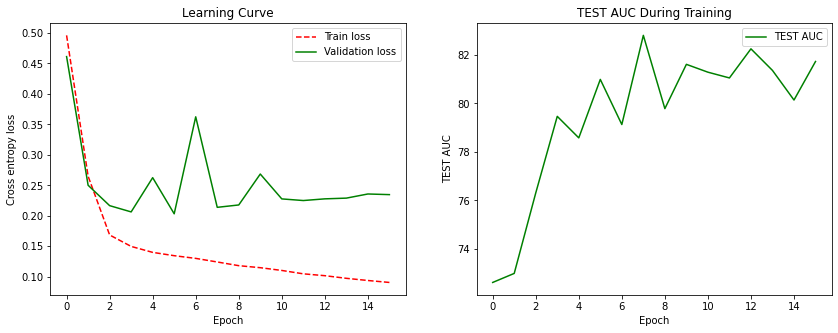


 Test AUC is 80.99319458007812 
 Validation Loss is 0.20320115753212803

 Test AUC in each class is:
(0, 64.58067262664963)
(1, 86.343669250646)
(2, 87.38527137385273)
(3, 83.79396038858349)
(4, 70.79887616624258)
(5, 85.57575757575758)
(6, 90.65348709500275)
(7, 77.51397907647907)
(8, 71.84962406015036)
(9, 80.57887759611135)
(10, 88.9598624918703)
(11, 83.8843648208469)


In [ ]:
seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
# if device == 'cuda:0':
#   dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M5(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        #self.GNN2 = DGM_M5(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(300, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      #(fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=32, optimizer=optimizer, patience=10, n_epochs=200)

In [ ]:
model8099 = model

In [ ]:
!ls '/content/drive/MyDrive/GMLG_Research/Saved_Models/'

tox21_213_7960_2.pt  tox21_213_7960.pt	tox21_213_8099_2.pt  tox21_213_8099.pt


In [ ]:
 save_path2="/content/drive/MyDrive/GMLG_Research/Saved_Models/tox21_213_8099_2.pt"
 #torch.save(model8099, save_path1)
############# Save Just Weights
torch.save(model.state_dict(), save_path2)

In [ ]:
test_aucs

[72.62085978190105,
 72.99314880371094,
 76.31011454264323,
 79.46983846028645,
 78.58228556315105,
 80.99319458007812,
 79.13258361816406,
 82.80987548828125,
 79.78798929850261,
 81.614501953125,
 81.2912089029948,
 81.05404154459636,
 82.25404866536458,
 81.36430358886719,
 80.1431376139323,
 81.73191833496094]

In [ ]:
model8099

GNN(
  (GNN1): DGM_M5(
    (linear_0_v): Linear(in_features=135, out_features=300, bias=True)
    (bn_0_v): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear_0_e): Linear(in_features=282, out_features=300, bias=True)
    (bn_0_e): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear_0_g): Linear(in_features=200, out_features=300, bias=True)
    (bn_0_g): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear_e_0): Linear(in_features=1500, out_features=300, bias=True)
    (bn_e_0): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear_e_1): Linear(in_features=300, out_features=300, bias=True)
    (bn_e_1): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear_m_0): Linear(in_features=600, out_features=300, bias=False)
    (bn_m_0): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track

[ 22/200] Train_Loss: 0.06099 Valid_Loss: 0.26671 Test_AUC: 79.28968
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 480.97358083724976 seconds in cuda:0




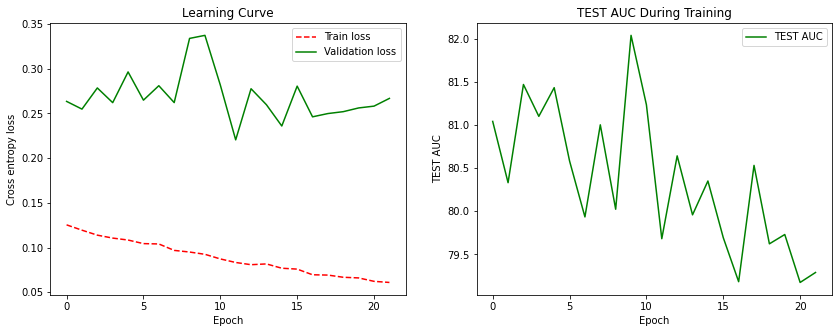


 Test AUC is 79.68135579427083 
 Validation Loss is 0.22037664074855137

 Test AUC in each class is:
(0, 64.78820774797785)
(1, 79.25064599483204)
(2, 86.52525836525258)
(3, 77.0841177799533)
(4, 74.02459711620017)
(5, 80.53333333333335)
(6, 90.48874244920373)
(7, 79.63789682539682)
(8, 75.1578947368421)
(9, 75.40322580645163)
(10, 87.84260893802843)
(11, 85.43973941368078)


In [ ]:
optimizer = torch.optim.Adam(model8099.parameters(), lr=0.0001)
model, train_losses, val_losses, test_aucs = train_model(model8099, batch_size=16, optimizer=optimizer, patience=10, n_epochs=200)

[ 11/200] Train_Loss: 0.04599 Valid_Loss: 0.22991 Test_AUC: 79.96483
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 135.52291059494019 seconds in cuda:0




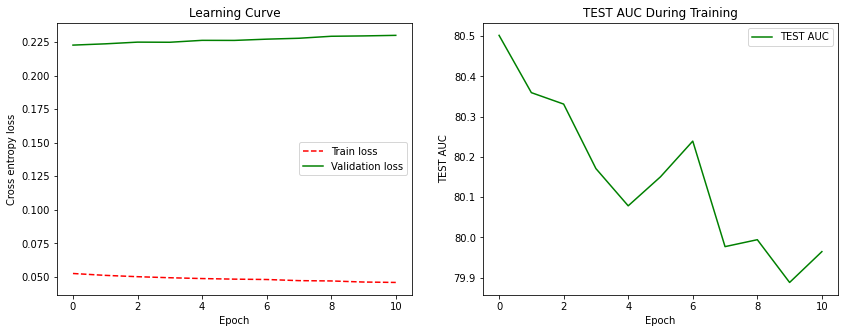


 Test AUC is 80.50167338053386 
 Validation Loss is 0.2226509776913191

 Test AUC in each class is:
(0, 64.78288633461048)
(1, 82.8811369509044)
(2, 85.7682301076823)
(3, 78.40951878906543)
(4, 73.62171331636979)
(5, 85.10909090909092)
(6, 91.45524437122461)
(7, 79.60182178932178)
(8, 74.2375939849624)
(9, 75.7954043305347)
(10, 88.78333178481836)
(11, 85.57410423452768)


In [ ]:
optimizer = torch.optim.Adam(model8099.parameters(), lr=0.00001)
model, train_losses, val_losses, test_aucs = train_model(model8099, batch_size=128, optimizer=optimizer, patience=10, n_epochs=200)

In [ ]:
        with torch.no_grad():      
            metric = roc_auc_score
            _, _, test_dataloader = loader(512)
            prediction_all= torch.empty(0, device=device)
            labels_all= torch.empty(0, device=device)
            masks_all= torch.empty(0, device=device)
            for i, (_, mol_dgl_graph, fg, labels, masks) in enumerate(test_dataloader):
                mol_dgl_graph=mol_dgl_graph.to(device)
                labels=labels.to(device)
                masks=masks.to(device)
                fg=fg.to(device)
                prediction = mx(mol_dgl_graph, fg)
                prediction_all = torch.cat((prediction_all, prediction), 0)
                labels_all = torch.cat((labels_all, labels), 0)
                masks_all = torch.cat((masks_all, masks), 0)
            results = []
            average = torch.tensor([0.], device=device)
            for i in range(12):
              a1 = prediction_all[:, i][masks_all[:,i]==1]
              a2 = labels_all[:, i][masks_all[:,i]==1]
              results.append(100*metric(a2.view(-1).int().to('cpu'), a1.view(-1).to('cpu')))
              #average += 100*metric(prediction_all[:, i].view(-1), labels_all[:, i].view(-1).int()) # with pytorch-lightening
              #results.append(100*metric(labels_all[:, i].view(-1).int().to('cpu'), prediction_all[:, i].view(-1).to('cpu'))) # with sk-learn
              average += results[i]
            print(average.item()/12)


80.99319458007812


In [ ]:
!ls '/content/drive/MyDrive/GMLG_Research/Saved_Models/'

tox21_213_7960_2.pt  tox21_213_7960.pt	tox21_213_8099_2.pt  tox21_213_8099.pt


In [ ]:
mx = torch.load( '/content/drive/MyDrive/GMLG_Research/Saved_Models/tox21_213_8099.pt', map_location=torch.device(device))

In [ ]:
mx.eval()

GNN(
  (GNN1): DGM_M5(
    (linear_0_v): Linear(in_features=135, out_features=300, bias=True)
    (bn_0_v): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear_0_e): Linear(in_features=282, out_features=300, bias=True)
    (bn_0_e): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear_0_g): Linear(in_features=200, out_features=300, bias=True)
    (bn_0_g): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear_e_0): Linear(in_features=1500, out_features=300, bias=True)
    (bn_e_0): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear_e_1): Linear(in_features=300, out_features=300, bias=True)
    (bn_e_1): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear_m_0): Linear(in_features=600, out_features=300, bias=False)
    (bn_m_0): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track

[ 19/200] Train_Loss: 0.08272 Valid_Loss: 0.24789 Test_AUC: 77.54790
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 183.53520846366882 seconds in cuda:0




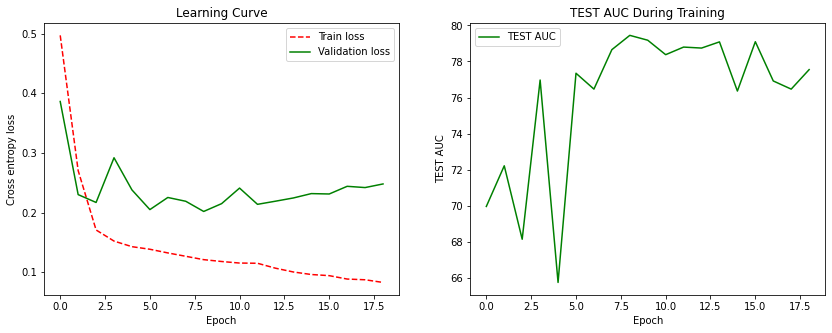


 Test AUC is 79.44807942708333 
 Validation Loss is 0.20175237552111785

 Test AUC in each class is:
(0, 64.85640197661334)
(1, 82.16753022452504)
(2, 82.55947117405738)
(3, 82.58225739275302)
(4, 74.83614232209737)
(5, 86.01317523056653)
(6, 84.27394885132206)
(7, 73.6903464147287)
(8, 75.30434782608695)
(9, 79.64271944480144)
(10, 83.73419673142153)
(11, 83.71639784946237)


In [ ]:
seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
# if device == 'cuda:0':
#   dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M5(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        #self.GNN2 = DGM_M5(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(300, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      #(fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=32, optimizer=optimizer, patience=10, n_epochs=200)

[ 19/200] Train_Loss: 0.09531 Valid_Loss: 0.22319 Test_AUC: 77.23219
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 176.69647932052612 seconds in cuda:0




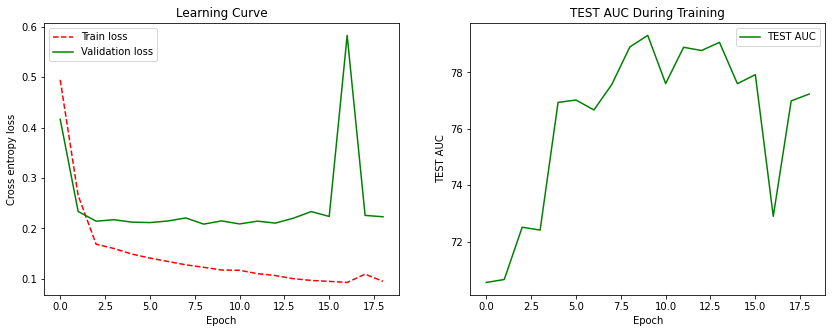


 Test AUC is 78.90178934733073 
 Validation Loss is 0.20865592798206237

 Test AUC in each class is:
(0, 73.73159156514507)
(1, 75.59369602763385)
(2, 84.07288752301292)
(3, 83.92336526447313)
(4, 74.32116104868913)
(5, 86.61923583662714)
(6, 83.4503684438665)
(7, 74.22632025193798)
(8, 71.71014492753623)
(9, 73.67090776678234)
(10, 84.66851680542707)
(11, 80.83333333333333)


In [ ]:
seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
# if device == 'cuda:0':
#   dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M5(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        #self.GNN2 = DGM_M5(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(300, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      #(fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=32, optimizer=optimizer, patience=10, n_epochs=200)

[ 19/200] Train_Loss: 0.09036 Valid_Loss: 0.24401 Test_AUC: 76.95688
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 182.1149513721466 seconds in cuda:0




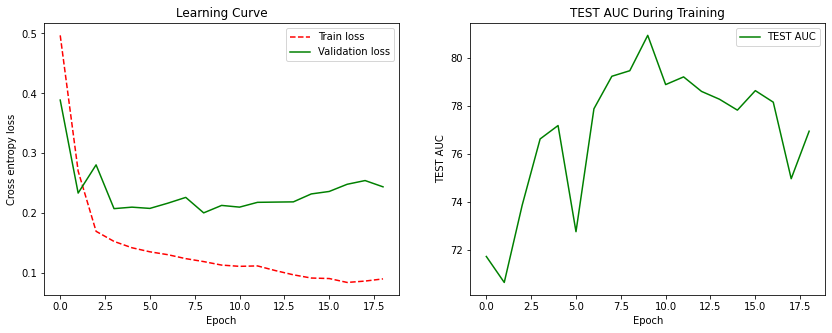


 Test AUC is 79.4742940266927 
 Validation Loss is 0.20056320881021433

 Test AUC in each class is:
(0, 73.31082733988941)
(1, 77.46113989637306)
(2, 80.90254120580434)
(3, 86.93322226849924)
(4, 72.48556491885144)
(5, 85.29117259552042)
(6, 76.44560034677069)
(7, 74.12185077519379)
(8, 78.36627140974967)
(9, 76.84530694426594)
(10, 84.25994449583719)
(11, 87.26814516129032)


In [ ]:
seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
if device == 'cuda:0':
  dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M5(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        #self.GNN2 = DGM_M5(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(300, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      #(fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=32, optimizer=optimizer, patience=10, n_epochs=200)

[ 14/200] Train_Loss: 0.09482 Valid_Loss: 0.24510 Test_AUC: 77.97384
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 131.5102198123932 seconds in cuda:0




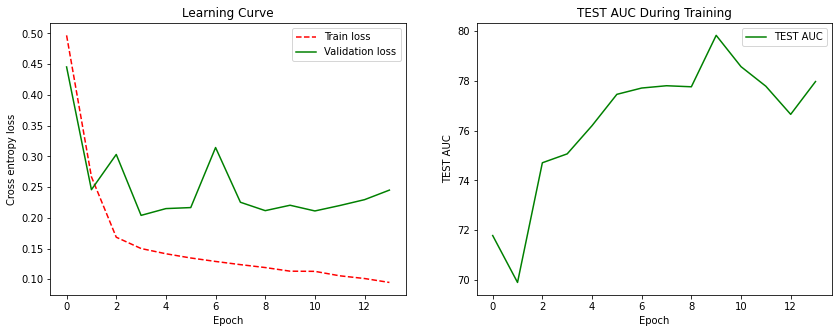


 Test AUC is 75.06752014160156 
 Validation Loss is 0.2039862446401311

 Test AUC in each class is:
(0, 60.63897450951612)
(1, 69.0954231433506)
(2, 78.72809242856937)
(3, 79.85561571567402)
(4, 70.53292759051185)
(5, 79.34650856389986)
(6, 85.56566970091028)
(7, 72.10210755813954)
(8, 69.62845849802372)
(9, 71.87165317225721)
(10, 84.2445266728338)
(11, 79.2002688172043)


In [ ]:
seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
if device == 'cuda:0':
  dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M5(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        #self.GNN2 = DGM_M5(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(300, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      #(fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=32, optimizer=optimizer, patience=10, n_epochs=200)

[ 14/200] Train_Loss: 0.09595 Valid_Loss: 0.21984 Test_AUC: 79.11845
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 131.40116786956787 seconds in cuda:0




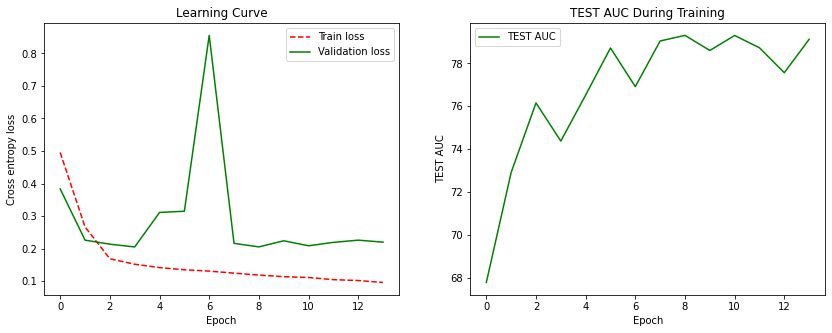


 Test AUC is 74.37139892578125 
 Validation Loss is 0.20502858326352877

 Test AUC in each class is:
(0, 61.57346249816526)
(1, 71.30829015544042)
(2, 79.12384210602612)
(3, 76.18214632791893)
(4, 71.3229556803995)
(5, 84.35309617918314)
(6, 79.39315127871696)
(7, 70.21105862403101)
(8, 71.18840579710145)
(9, 71.59748104356765)
(10, 82.41597286463151)
(11, 73.78696236559139)


In [ ]:
seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
# if device == 'cuda:0':
#   dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M5(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        #self.GNN2 = DGM_M5(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(300, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      #(fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=32, optimizer=optimizer, patience=10, n_epochs=200)

[ 14/200] Train_Loss: 0.09699 Valid_Loss: 0.22824 Test_AUC: 78.42822
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 131.30384397506714 seconds in cuda:0




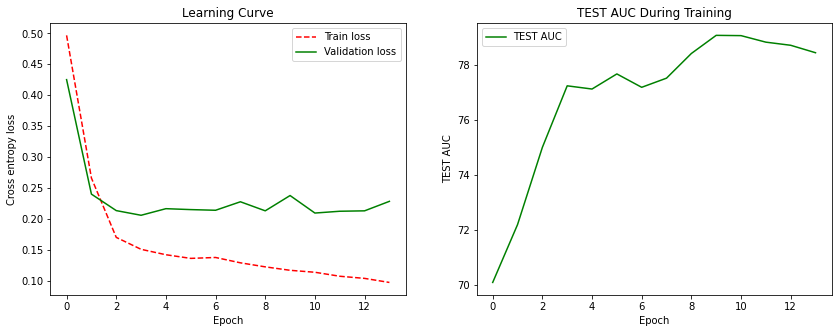


 Test AUC is 77.22557576497395 
 Validation Loss is 0.20568788949861685

 Test AUC in each class is:
(0, 68.49650178580164)
(1, 81.36873920552677)
(2, 81.20986329965353)
(3, 83.59850062473969)
(4, 71.39318039950062)
(5, 86.9828722002635)
(6, 78.51755526657998)
(7, 70.26102228682171)
(8, 72.3794466403162)
(9, 72.21436833311914)
(10, 82.72432932469934)
(11, 77.56048387096773)


In [ ]:
seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
# if device == 'cuda:0':
#   dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M5(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        #self.GNN2 = DGM_M5(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(300, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      #(fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=32, optimizer=optimizer, patience=10, n_epochs=200)

[ 16/200] Train_Loss: 0.09452 Valid_Loss: 0.21902 Test_AUC: 78.38560
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 1013.4409332275391 seconds in cpu




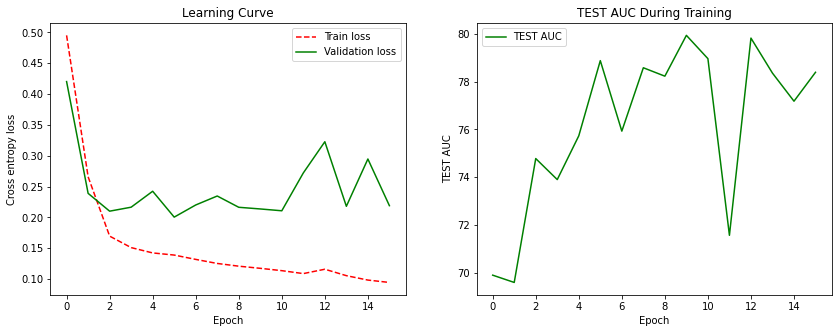


 Test AUC is 78.87255350748698 
 Validation Loss is 0.20043581655655784

 Test AUC in each class is:
(0, 58.28073780517637)
(1, 80.52677029360967)
(2, 83.88008639809809)
(3, 83.75399139247534)
(4, 71.64872034956305)
(5, 85.01185770750989)
(6, 87.79367143476375)
(7, 74.41709060077521)
(8, 75.79973649538867)
(9, 76.08704965085894)
(10, 85.6922602528523)
(11, 83.57862903225806)


In [ ]:
seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
if device == 'cuda:0':
  dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M5(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        #self.GNN2 = DGM_M5(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(300, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      #(fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=32, optimizer=optimizer, patience=10, n_epochs=200)

[ 16/200] Train_Loss: 0.09452 Valid_Loss: 0.21902 Test_AUC: 78.38560
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 1019.2475225925446 seconds in cpu




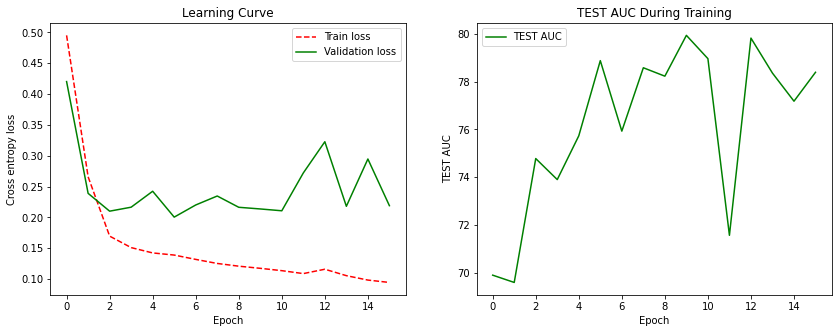


 Test AUC is 78.87255350748698 
 Validation Loss is 0.20043581655655784

 Test AUC in each class is:
(0, 58.28073780517637)
(1, 80.52677029360967)
(2, 83.88008639809809)
(3, 83.75399139247534)
(4, 71.64872034956305)
(5, 85.01185770750989)
(6, 87.79367143476375)
(7, 74.41709060077521)
(8, 75.79973649538867)
(9, 76.08704965085894)
(10, 85.6922602528523)
(11, 83.57862903225806)


In [ ]:
seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
if device == 'cuda:0':
  dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M5(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        #self.GNN2 = DGM_M5(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(300, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      #(fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=32, optimizer=optimizer, patience=10, n_epochs=200)

[4/4] Train_Loss: 0.54156 Valid_Loss: 0.49637 Test_AUC: 71.54453
Validation loss decreased (0.522263 --> 0.496374).  Saving model ...

 Training Time was 92.6607654094696 seconds in cuda:0




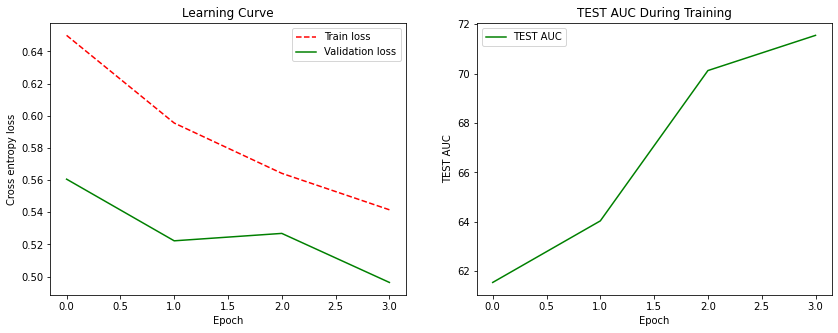


 Test AUC is 71.54452514648438 
 Validation Loss is 0.5222625732421875

 Test AUC in each class is:
(0, 74.87156905915162)
(1, 74.1688255613126)
(2, 75.93320093356334)
(3, 70.28738025822575)
(4, 70.99328963795256)
(5, 84.61133069828722)
(6, 76.15084525357607)
(7, 60.00787306201549)
(8, 66.1080368906456)
(9, 67.20644304502422)
(10, 72.47301880974406)
(11, 65.72244623655914)


In [ ]:
# similar architecture to the one that reached 78.5 with DGM_M2 where bn=32 and patience=10
# without scheduler
# random scaffold split - seed 213
# with skipconnections for both edge and node updaters
# 2 layers of GCN with relu for readout
# better training 

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
if device == 'cuda:0':
  dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M5(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM_M5(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=512, optimizer=optimizer, patience=2, n_epochs=4)

In [ ]:
val_losses

[0.5606030967195981,
 0.5222625732421875,
 0.5268718773073315,
 0.49637396216849256]

In [ ]:
# similar architecture to the one that reached 78.5 with DGM_M2 where bn=32 and patience=10
# without scheduler
# random scaffold split - seed 213
# with skipconnections for both edge and node updaters
# 2 layers of GCN with relu for readout
# better training 

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
if device == 'cuda:0':
  dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M5(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM_M5(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=32, optimizer=optimizer, patience=10, n_epochs=200)

[ 19/200] Train_Loss: 0.09366 Valid_Loss: 0.23280 Test_AUC: 78.66671
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 604.8683767318726 seconds in cuda:0




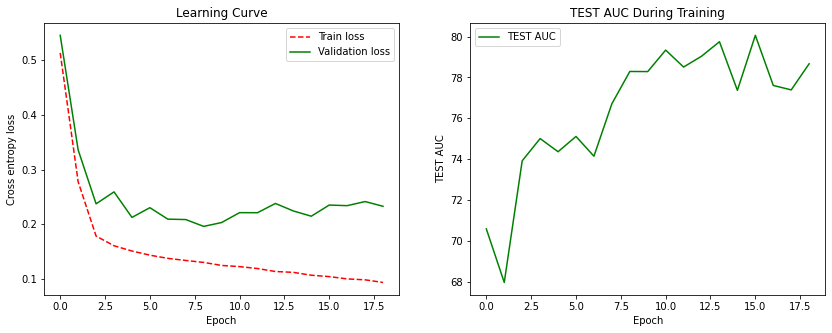


 Test AUC is 78.29031880696614

 Test AUC in each class is:
(0, 67.50330250990754)
(1, 85.12521588946458)
(2, 79.88779844309467)
(3, 81.78814382896016)
(4, 70.82553058676653)
(5, 77.14888010540186)
(6, 87.90637191157347)
(7, 69.7765261627907)
(8, 79.23056653491436)
(9, 76.18129632009595)
(10, 81.86555658341042)
(11, 82.24462365591398)


In [ ]:
# similar architecture to the one that reached 78.5 with DGM_M2 where bn=32 and patience=10
# without scheduler
# random scaffold split - seed 213
# with skipconnections for both edge and node updaters
# 2 layers of GCN with relu for readout
# better training 

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
if device == 'cuda:0':
  dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M5(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM_M5(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=32, optimizer=optimizer, patience=10, n_epochs=200)

[ 19/200] Train_Loss: 0.09639 Valid_Loss: 0.22546 Test_AUC: 78.05340
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 603.3715329170227 seconds in cuda:0




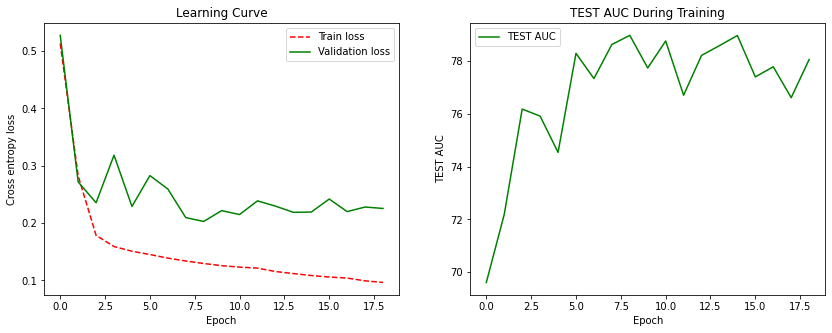


 Test AUC is 78.9673563639323

 Test AUC in each class is:
(0, 73.72180635060424)
(1, 76.34930915371329)
(2, 82.62760390241074)
(3, 85.49215604609192)
(4, 70.91916354556804)
(5, 84.48484848484848)
(6, 86.9700910273082)
(7, 72.30953246124031)
(8, 77.6231884057971)
(9, 74.5019920318725)
(10, 80.83102065988284)
(11, 81.77755376344086)


In [ ]:
# similar architecture to the one that reached 78.5 with DGM_M2 where bn=32 and patience=10
# without scheduler
# random scaffold split - seed 213
# with skipconnections for both edge and node updaters
# 2 layers of GCN with relu for readout
# better training 

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
if device == 'cuda:0':
  dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M5(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM_M5(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=32, optimizer=optimizer, patience=10, n_epochs=200)

In [ ]:
model7896 = model

[ 11/200] Train_Loss: 0.05485 Valid_Loss: 0.23567 Test_AUC: 76.87436
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 249.07782745361328 seconds in cuda:0




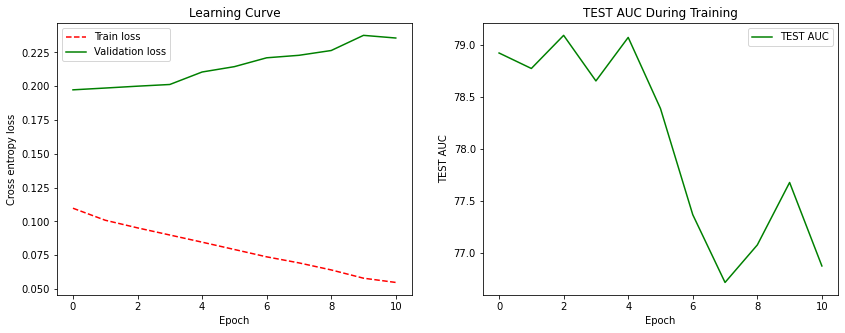


 Test AUC is 78.919677734375

 Test AUC in each class is:
(0, 72.98791526004209)
(1, 80.89378238341969)
(2, 82.05644869025701)
(3, 85.11453561016242)
(4, 71.83793695380774)
(5, 82.28194993412387)
(6, 86.51061985262245)
(7, 74.37015503875969)
(8, 77.41765480895916)
(9, 70.88634708477916)
(10, 81.73450508788159)
(11, 80.94422043010752)


In [ ]:
optimizer = torch.optim.Adam(model7896.parameters(), lr=0.0001)
model, train_losses, val_losses, test_aucs = train_model(model7896, batch_size=128, optimizer=optimizer, patience=10, n_epochs=200)

In [ ]:
model7891 = model

[ 13/200] Train_Loss: 0.07547 Valid_Loss: 0.24410 Test_AUC: 77.04822
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 534.3254568576813 seconds in cuda:0




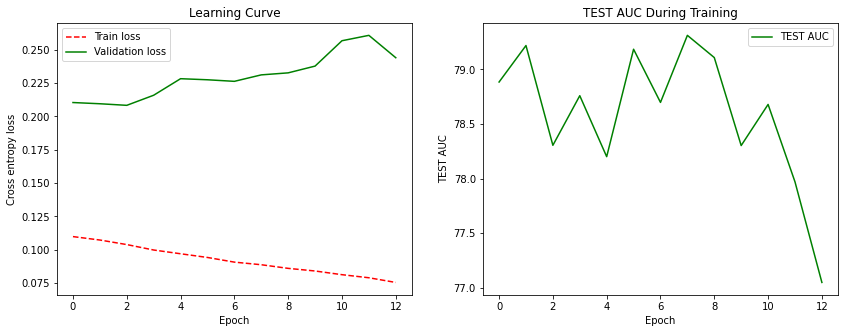


 Test AUC is 78.30420430501302

 Test AUC in each class is:
(0, 65.74685649982875)
(1, 73.93134715025906)
(2, 83.09873447081164)
(3, 85.41441066222407)
(4, 72.03690699126093)
(5, 80.7905138339921)
(6, 88.52188990030344)
(7, 74.5639534883721)
(8, 75.08827404479578)
(9, 72.70273743734738)
(10, 84.12580943570768)
(11, 83.62903225806451)


In [ ]:
optimizer = torch.optim.Adam(model7891.parameters(), lr=0.00005)
model, train_losses, val_losses, test_aucs = train_model(model7891, batch_size=16, optimizer=optimizer, patience=10, n_epochs=200)

[ 13/200] Train_Loss: 0.06482 Valid_Loss: 0.24862 Test_AUC: 76.90980
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 533.4305703639984 seconds in cuda:0




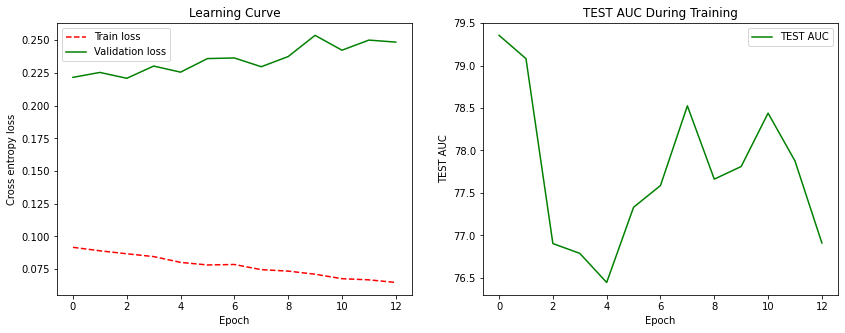


 Test AUC is 76.90311686197917

 Test AUC in each class is:
(0, 64.27907431870443)
(1, 72.99222797927462)
(2, 82.67109287795543)
(3, 80.8107732889074)
(4, 70.71434144818977)
(5, 78.05006587615283)
(6, 88.87732986562635)
(7, 72.77434593023256)
(8, 74.45586297760211)
(9, 71.71743134986933)
(10, 83.04193647856923)
(11, 82.45295698924731)


In [ ]:
optimizer = torch.optim.Adam(model7896.parameters(), lr=0.00005)
model, train_losses, val_losses, test_aucs = train_model(model7896, batch_size=16, optimizer=optimizer, patience=10, n_epochs=200)

In [ ]:
!nvidia-smi

Fri Apr 30 12:34:43 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    58W / 149W |   1955MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# similar architecture to the one that reached 78.5 with DGM_M2 where bn=32 and patience=10
# without scheduler
# random scaffold split - seed 213
# with skipconnections for both edge and node updaters
# 3 layers of GCN for readout
# better training 

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
#dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M4(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM_M4(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nnallow_zero_in_degree.Linear(200, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=32, optimizer=optimizer, patience=10, n_epochs=200)

[ 15/200] Train_Loss: 0.11906 Valid_Loss: 0.25328 Test_AUC: 76.24485
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 443.87740778923035 seconds in cuda:0




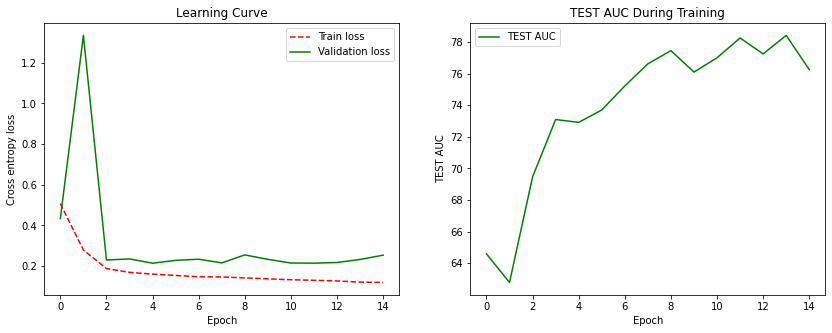


 Test AUC is 72.9122823079427

 Test AUC in each class is:
(0, 62.023582367043396)
(1, 70.89810017271158)
(2, 79.61526752968123)
(3, 67.66069693183395)
(4, 74.3640761548065)
(5, 78.11330698287222)
(6, 84.19592544429996)
(7, 65.7627785852713)
(8, 68.34782608695653)
(9, 73.22537805766181)
(10, 75.67992599444958)
(11, 75.06048387096774)


In [ ]:
# similar architecture to the one that reached 78.5 with DGM_M2 where bn=32 and patience=10
# without scheduler
# random scaffold split - seed 213
# with skipconnections for both edge and node updaters
# 3 layers of GCN for readout
# better training 

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
#dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M4(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM_M4(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=32, optimizer=optimizer, patience=10, n_epochs=200)

[ 28/200] Train_Loss: 0.08244 Valid_Loss: 0.29147 Test_AUC: 75.44453
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 842.0375368595123 seconds in cuda:0




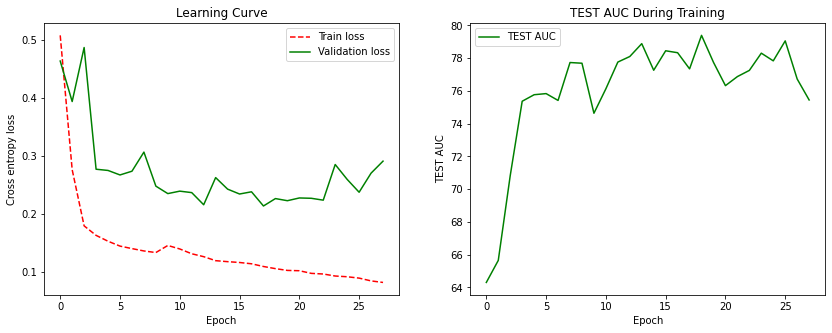


 Test AUC is 77.34330749511719

 Test AUC in each class is:
(0, 57.88932922354323)
(1, 77.15889464594127)
(2, 81.46644825536725)
(3, 84.18159100374845)
(4, 69.62585830212234)
(5, 80.51646903820816)
(6, 83.18162115301256)
(7, 73.26944040697674)
(8, 76.0790513833992)
(9, 80.47380370989163)
(10, 81.95189639222941)
(11, 82.3252688172043)


In [ ]:
# similar architecture to the one that reached 78.5 with DGM_M2 where bn=32 and patience=10
# without scheduler
# random scaffold split - seed 213
# with skipconnections for both edge and node updaters
# 3 layers of GCN for readout
# better training 

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
if device == 'cuda:0':
  dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M4(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM_M4(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=32, optimizer=optimizer, patience=10, n_epochs=200)

[ 23/200] Train_Loss: 0.09821 Valid_Loss: 0.39867 Test_AUC: 76.45717
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 693.3459417819977 seconds in cuda:0




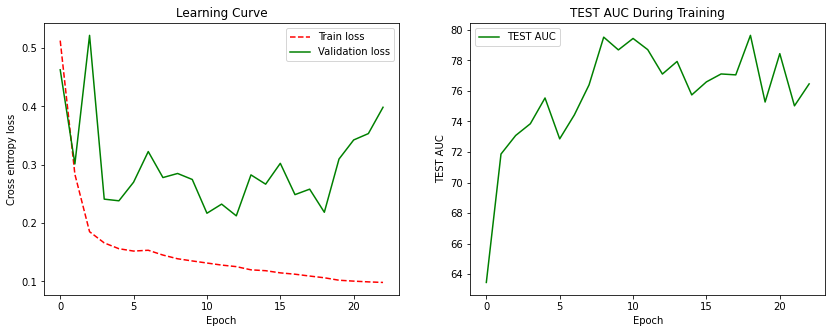


 Test AUC is 77.10136413574219

 Test AUC in each class is:
(0, 60.40412936053623)
(1, 78.99395509499136)
(2, 82.4217560848325)
(3, 79.98611689573788)
(4, 70.08817103620474)
(5, 83.19894598155469)
(6, 86.19852622453402)
(7, 72.89849806201549)
(8, 72.85375494071145)
(9, 73.82084564965943)
(10, 82.4699352451434)
(11, 81.88172043010753)


In [ ]:
# similar architecture to the one that reached 78.5 with DGM_M2 where bn=32 and patience=10
# without scheduler
# random scaffold split - seed 213
# with skipconnections for both edge and node updaters
# 3 layers of GCN for readout
# better training 

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
if device == 'cuda:0':
  dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M4(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM_M4(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=32, optimizer=optimizer, patience=10, n_epochs=200)

[ 20/200] Train_Loss: 0.10967 Valid_Loss: 0.29867 Test_AUC: 78.18247
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 588.4238090515137 seconds in cuda:0




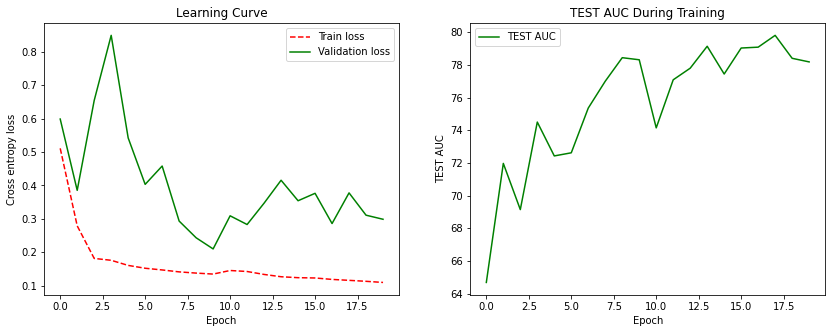


 Test AUC is 78.31273905436198

 Test AUC in each class is:
(0, 64.92489847839913)
(1, 80.5591537132988)
(2, 76.5029065131989)
(3, 85.26447313619326)
(4, 69.62195692883894)
(5, 76.25296442687747)
(6, 85.19289120069354)
(7, 72.48516230620156)
(8, 83.0197628458498)
(9, 81.44625797883734)
(10, 81.62966389145852)
(11, 82.85282258064517)


In [ ]:
# similar architecture to the one that reached 78.5 with DGM_M2 where bn=32 and patience=10
# without scheduler
# random scaffold split - seed 213
# with skipconnections for both edge and node updaters
# 3 layers of GCN for readout
# better training 

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
#dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M4(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM_M4(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=32, optimizer=optimizer, patience=10, n_epochs=200)

[ 21/200] Train_Loss: 0.10693 Valid_Loss: 0.32927 Test_AUC: 76.92717
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 614.593193769455 seconds in cuda:0




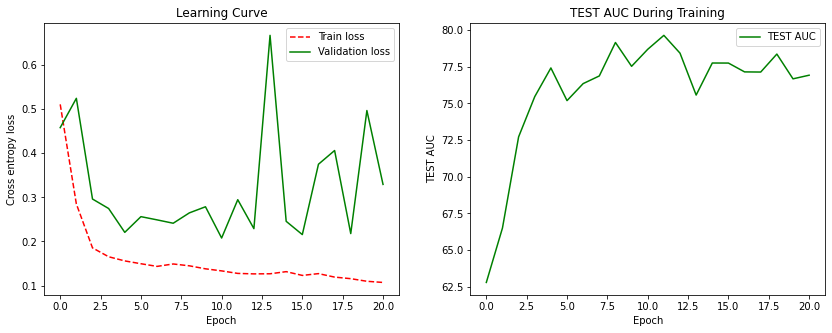


 Test AUC is 78.6936543782552

 Test AUC in each class is:
(0, 66.7155927393708)
(1, 81.88687392055269)
(2, 81.01416290970239)
(3, 82.05192280994031)
(4, 73.51942883895133)
(5, 78.58761528326745)
(6, 87.93237971391417)
(7, 74.21117974806202)
(8, 73.48616600790514)
(9, 77.98483485413186)
(10, 81.44310823311748)
(11, 85.49059139784947)


In [ ]:
# similar architecture to the one that reached 78.5 with DGM_M2 where bn=32 and patience=10
# without scheduler
# random scaffold split - seed 213
# with skipconnections for both edge and node updaters
# 3 layers of GCN for readout
# better training 

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
#dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M4(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM_M4(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=32, optimizer=optimizer, patience=10, n_epochs=200)

[ 33/200] Train_Loss: 0.07030 Valid_Loss: 0.25890 Test_AUC: 76.38871
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 975.4804818630219 seconds in cuda:0




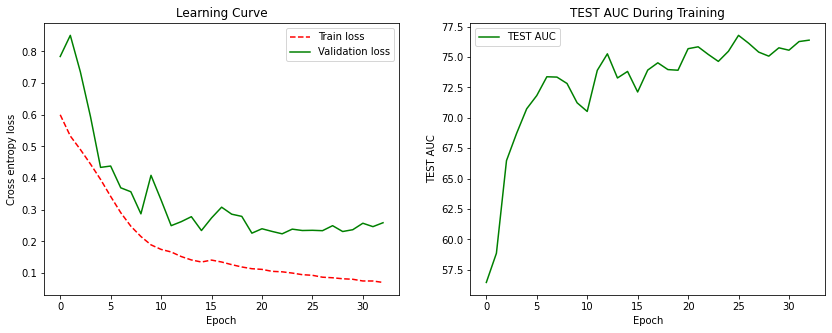


 Test AUC is 75.21507263183594

 Test AUC in each class is:
(0, 57.84529575810951)
(1, 84.74740932642487)
(2, 82.43045387994144)
(3, 71.00374843815077)
(4, 72.8015761548065)
(5, 74.1501976284585)
(6, 87.0827915041179)
(7, 73.03324854651163)
(8, 66.02371541501977)
(9, 75.54298933299062)
(10, 79.031760715387)
(11, 78.88776881720429)


In [ ]:
# similar architecture to the one that reached 78.5 with DGM_M2 where bn=32 and patience=10
# without scheduler
# random scaffold split - seed 213
# with skipconnections for both edge and node updaters
# 3 layers of GCN for readout
# better training 

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
#dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M4(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM_M4(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=32, optimizer=optimizer, patience=10, n_epochs=200)

[ 16/200] Train_Loss: 0.11971 Valid_Loss: 0.24810 Test_AUC: 78.77453
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 469.8955900669098 seconds in cuda:0




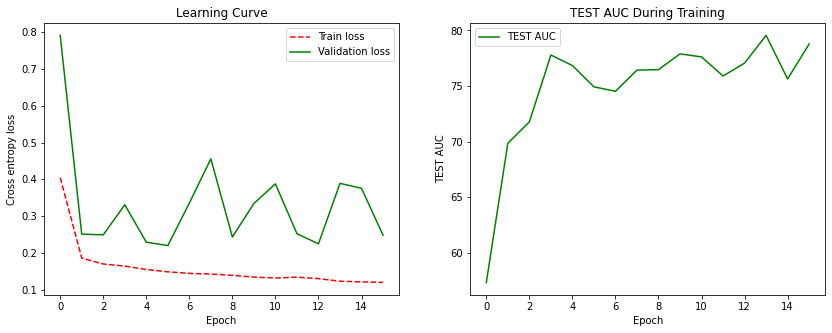


 Test AUC is 74.92055765787761

 Test AUC in each class is:
(0, 63.71642448260678)
(1, 81.20682210708118)
(2, 76.38838554426452)
(3, 82.27682909898654)
(4, 65.00663233458178)
(5, 72.68511198945981)
(6, 80.53749458170785)
(7, 72.2610828488372)
(8, 73.24374176548089)
(9, 77.08520755686929)
(10, 79.06105457909342)
(11, 75.57795698924731)


In [ ]:
# similar architecture to the one that reached 78.5 with DGM_M2 where bn=32 and patience=10
# without scheduler
# random scaffold split - seed 213
# with skipconnections for both edge and node updaters
# 3 layers of GCN for readout
# better training 

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
#dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M4(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM_M4(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=32, optimizer=optimizer, patience=10, n_epochs=200)

[ 17/200] Train_Loss: 0.09950 Valid_Loss: 0.23981 Test_AUC: 74.87187
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 404.3549294471741 seconds in cuda:0




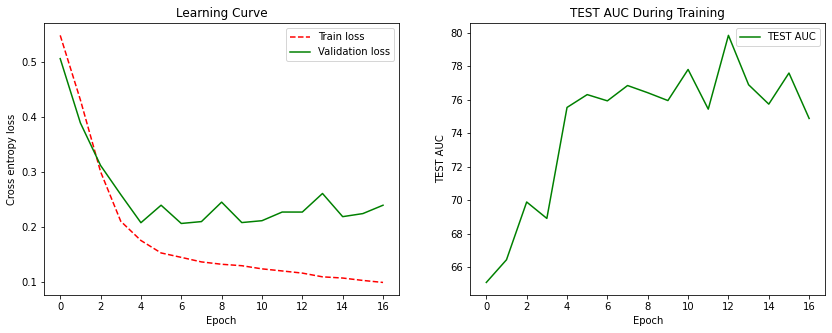


 Test AUC is 75.92282613118489

 Test AUC in each class is:
(0, 62.39542051959489)
(1, 83.2793609671848)
(2, 79.34418624878593)
(3, 72.5059003193114)
(4, 69.44639513108613)
(5, 75.10935441370225)
(6, 87.36887732986564)
(7, 67.05274951550389)
(8, 79.66798418972331)
(9, 77.166602407574)
(10, 78.76194881282763)
(11, 78.97513440860216)


In [ ]:
# similar architecture to the one that reached 78.5 with DGM_M2 where bn=32 and patience=10
# without scheduler
# random scaffold split - seed 213
# with skipconnections for both edge and node updaters
# 3 layers of GCN for readout
# better training 

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
#dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M4(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM_M4(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=64, optimizer=optimizer, patience=10, n_epochs=200)

[ 38/200] Train_Loss: 0.03479 Valid_Loss: 0.34736 Test_AUC: 75.69337
EarlyStopping counter: 30 out of 30
Early Stopping

 Training Time was 917.3521935939789 seconds in cuda:0




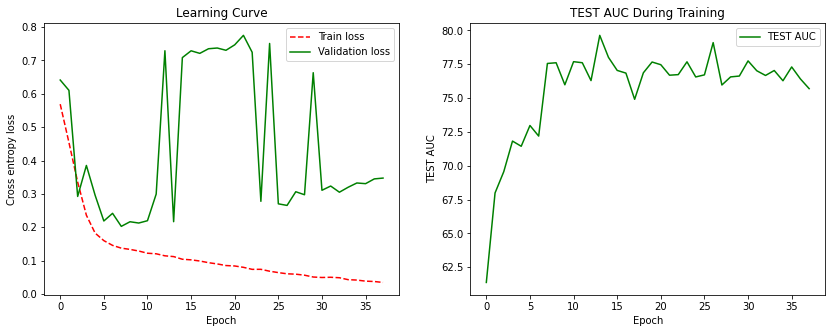


 Test AUC is 77.55430603027344

 Test AUC in each class is:
(0, 65.20866970008316)
(1, 87.98575129533678)
(2, 83.25094588521809)
(3, 76.41260585866999)
(4, 68.42423533083645)
(5, 80.33201581027669)
(6, 89.27611616818379)
(7, 73.13166182170544)
(8, 68.77997364953887)
(9, 75.11031144240243)
(10, 82.31267345050878)
(11, 80.42674731182795)


In [ ]:
# similar architecture to the one that reached 78.5 with DGM_M2 where bn=32 and patience=10
# without scheduler
# random scaffold split - seed 213
# with skipconnections for both edge and node updaters
# 3 layers of GCN for readout
# better training bn=64, patience=30, lr=0.0005

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
#dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M4(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM_M4(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 70)
        self.linear_2 = nn.Linear(70, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(70)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=64, optimizer=optimizer, patience=30, n_epochs=200)

[ 21/200] Train_Loss: 0.11037 Valid_Loss: 0.22625 Test_AUC: 0.79782
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 632.5829417705536 seconds in cuda:0




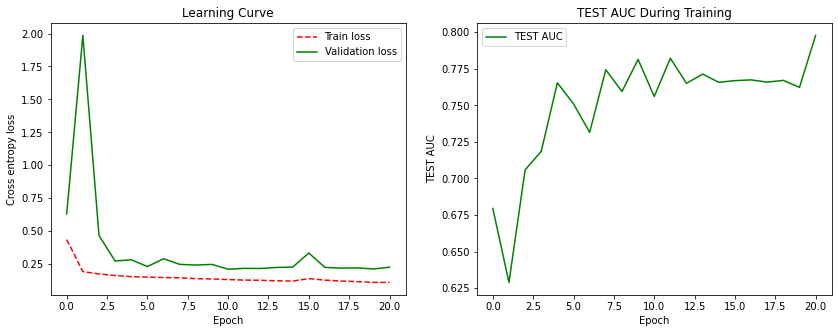


 Test AUC is 0.7560321489969889

 Test AUC in each class is:
(0, 0.5561426684280053)
(1, 0.7917746113989637)
(2, 0.8379165881449052)
(3, 0.7295015965569901)
(4, 0.7155118601747815)
(5, 0.8709881422924902)
(6, 0.834330299089727)
(7, 0.7437166908914729)
(8, 0.7643214756258235)
(9, 0.7296405774750461)
(10, 0.8050262102991058)
(11, 0.6935147849462365)


In [ ]:
# the same architecture as the one that reached 78.5 with DGM_M2 where bn=32 and patience=10
# without scheduler
# random scaffold split - seed 213
# with skipconnections for both edge and node updaters
# 3 layers of GCN for readout

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
#dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M4(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM_M4(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 70)
        self.linear_2 = nn.Linear(70, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(70)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=32, optimizer=optimizer, patience=10, n_epochs=200)

In [ ]:
# without scheduler
# random scaffold split - seed 213
# with skipconnections for both edge and node updaters
# two layers of GCN for readout

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
#dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M3(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM_M3(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=128, optimizer=optimizer, patience=20, n_epochs=200)

[ 31/200] Train_Loss: 0.04245 Valid_Loss: 0.29849 Test_AUC: 0.77797
EarlyStopping counter: 19 out of 20


[ 24/200] Train_Loss: 0.10797 Valid_Loss: 0.34387 Test_AUC: 0.75216
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 420.6502170562744 seconds in cuda:0




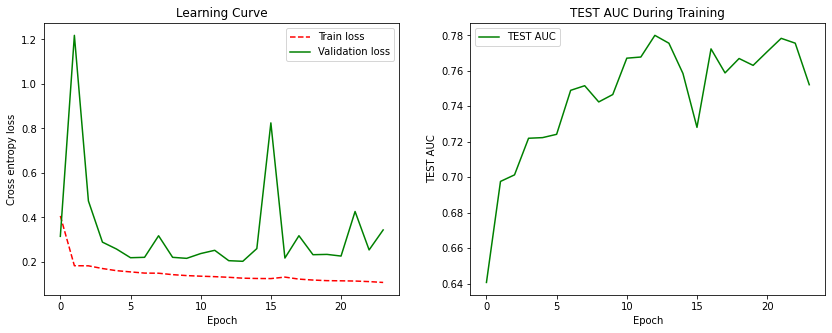


 Test AUC is 0.7755540211995443

 Test AUC in each class is:
(0, 0.6763051029893831)
(1, 0.7970639032815198)
(2, 0.8034008378875954)
(3, 0.8282937664861862)
(4, 0.7009987515605494)
(5, 0.7865085638998683)
(6, 0.8613784135240572)
(7, 0.7419301114341086)
(8, 0.7402371541501975)
(9, 0.7533307629696268)
(10, 0.827382053654024)
(11, 0.7898185483870968)


In [ ]:
# without scheduler
# random scaffold split - seed 213
# with skipconnections for both edge and node updaters
# two layers of GCN for readout

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
#dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M3(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM_M3(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=32, optimizer=optimizer, patience=10, n_epochs=200)

[ 12/200] Train_Loss: 0.14837 Valid_Loss: 0.48607 Test_AUC: 0.78033
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 295.4284677505493 seconds in cuda:0




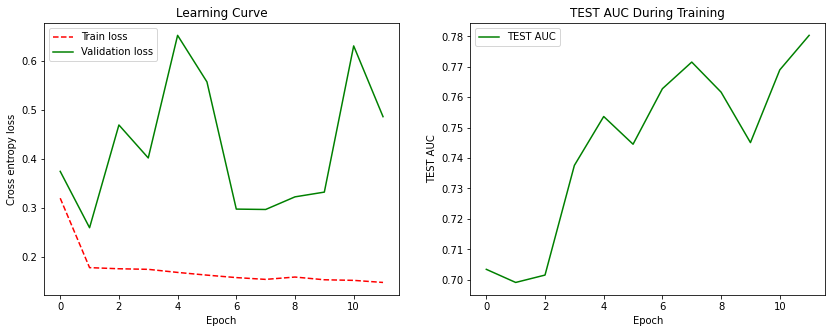


 Test AUC is 0.6991225878397623

 Test AUC in each class is:
(0, 0.5289397720045012)
(1, 0.6804835924006909)
(2, 0.7560703361697809)
(3, 0.5823684575871165)
(4, 0.6527777777777778)
(5, 0.7662187088274044)
(6, 0.8032076289553534)
(7, 0.6315406976744187)
(8, 0.7743873517786561)
(9, 0.7329392108983421)
(10, 0.7341658957755164)
(11, 0.7463709677419355)


In [ ]:
# without scheduler
# random scaffold split - seed 213
# with skipconnections for both edge and node updaters
# two layers of GCN for readout

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
#dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M3(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM_M3(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 70)
        self.linear_2 = nn.Linear(70, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(70)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=16, optimizer=optimizer, patience=10, n_epochs=200)

[ 39/200] Train_Loss: 0.03132 Valid_Loss: 0.31570 Test_AUC: 0.76809
EarlyStopping counter: 20 out of 20
Early Stopping

 Training Time was 503.3713893890381 seconds in cuda:0




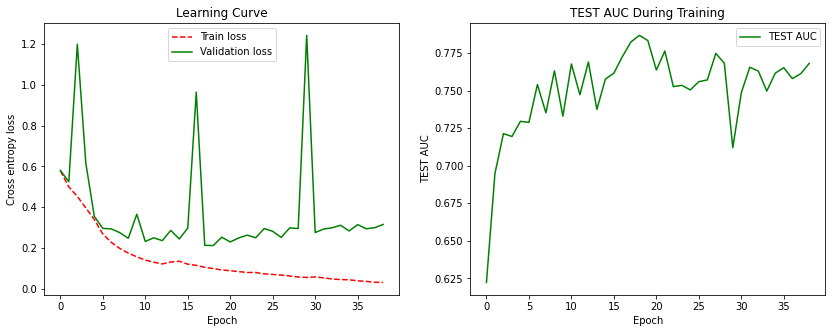


 Test AUC is 0.7867452303568522

 Test AUC in each class is:
(0, 0.7241548020940358)
(1, 0.7538860103626943)
(2, 0.8220721047214531)
(3, 0.8044425933638761)
(4, 0.7343554931335831)
(5, 0.8135441370223979)
(6, 0.8813177286519289)
(7, 0.7375999273255814)
(8, 0.7533596837944664)
(9, 0.7602279055819732)
(10, 0.8252698119025593)
(11, 0.8307123655913978)


In [ ]:
# without scheduler
# random scaffold split - seed 213
# with skipconnections for both edge and node updaters
# two layers of GCN for readout

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
#dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M3(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM_M3(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 70)
        self.linear_2 = nn.Linear(70, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(70)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=128, optimizer=optimizer, patience=20, n_epochs=200)

[ 18/200] Train_Loss: 0.09641 Valid_Loss: 0.22618 Test_AUC: 0.76338
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 231.31203484535217 seconds in cuda:0




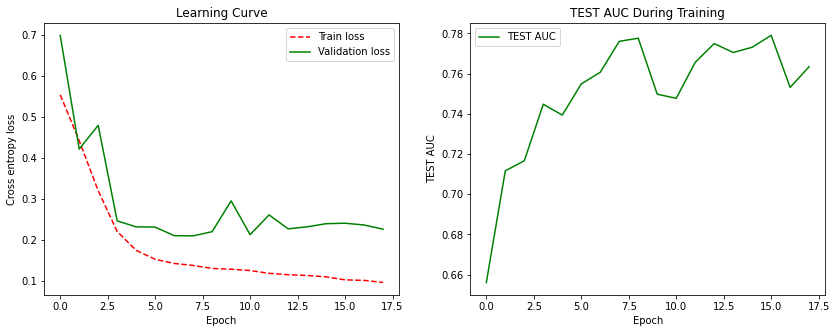


 Test AUC is 0.775994618733724

 Test AUC in each class is:
(0, 0.708253828465189)
(1, 0.7855138169257341)
(2, 0.7788005740544771)
(3, 0.8096348743579065)
(4, 0.7268843632958801)
(5, 0.8823715415019764)
(6, 0.8003467706978761)
(7, 0.7120881782945736)
(8, 0.7051383399209487)
(9, 0.7854174699053249)
(10, 0.8212149244526672)
(11, 0.7962701612903226)


In [ ]:
# without scheduler
# random scaffold split - seed 213
# with skipconnections for both edge and node updaters
# two layers of GCN for readout

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
#dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M3(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM_M3(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 70)
        self.linear_2 = nn.Linear(70, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(70)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=128, optimizer=optimizer, patience=10, n_epochs=200)

[ 27/200] Train_Loss: 0.09912 Valid_Loss: 0.25710 Test_AUC: 0.77354
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 3158.2020869255066 seconds in cpu




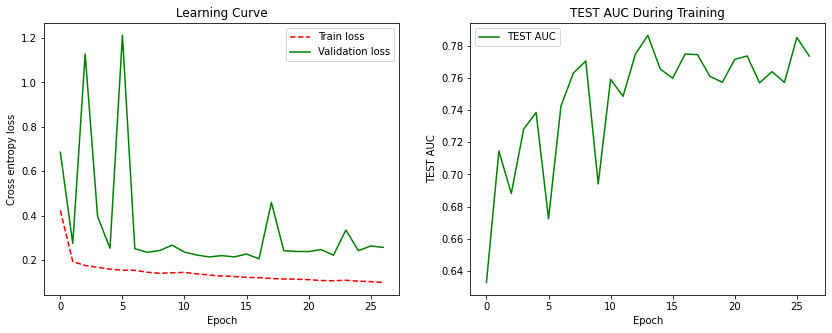


 Test AUC is 0.774834156036377

 Test AUC in each class is:
(0, 0.6415186652967366)
(1, 0.8279360967184801)
(2, 0.8305814476030327)
(3, 0.736109954185756)
(4, 0.7175795880149812)
(5, 0.8610803689064559)
(6, 0.8145643693107933)
(7, 0.7602046996124032)
(8, 0.7468774703557312)
(9, 0.732810692713019)
(10, 0.8191026827012027)
(11, 0.8096438172043011)


In [ ]:
# without scheduler
# random scaffold split - seed 213
# with skipconnections for both edge and node updaters
# two layers of GCN for readout

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
#dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M3(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM_M3(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 70)
        self.linear_2 = nn.Linear(70, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(70)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=32, optimizer=optimizer, patience=10, n_epochs=200)

[ 20/200] Train_Loss: 0.10691 Valid_Loss: 0.22445 Test_AUC: 0.76763
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 327.8795223236084 seconds in cuda:0




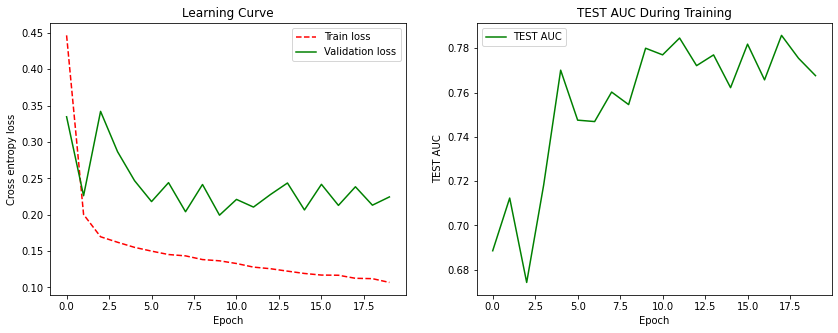


 Test AUC is 0.7800033887227377

 Test AUC in each class is:
(0, 0.658300308234258)
(1, 0.7478411053540587)
(2, 0.8485858834785382)
(3, 0.7720949604331528)
(4, 0.7496488764044944)
(5, 0.8418445322793149)
(6, 0.8416124837451237)
(7, 0.7282128149224807)
(8, 0.8028985507246377)
(9, 0.7498607719658997)
(10, 0.7907801418439717)
(11, 0.8283602150537634)


In [ ]:
# without scheduler
# random scaffold split - seed 213
# with skipconnections for both edge and node updaters

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
#dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M2(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM_M2(300,300,300,150,150,150,150,150,150,150,150,150,1,150,150,num_layers=1)
        self.linear_1 = nn.Linear(150, 50)
        self.linear_2 = nn.Linear(50, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(50)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=32, optimizer=optimizer, patience=10, n_epochs=200)



[ 24/200] Train_Loss: 0.10467 Valid_Loss: 0.23373 Test_AUC: 0.75592
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 391.7451889514923 seconds in cuda:0




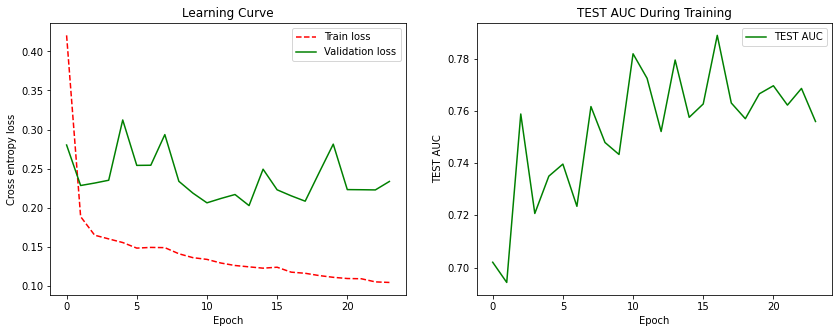


 Test AUC is 0.7794642448425293

 Test AUC in each class is:
(0, 0.6555604481628259)
(1, 0.7417962003454232)
(2, 0.8523114390502009)
(3, 0.8305150631681244)
(4, 0.7112788701622972)
(5, 0.8357312252964427)
(6, 0.8041612483745124)
(7, 0.7263808139534883)
(8, 0.8117523056653492)
(9, 0.7575290236901855)
(10, 0.8313598519888992)
(11, 0.7951948924731183)


In [ ]:
# without scheduler
# random scaffold split - seed 213
# with skipconnections for both edge and node updaters

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
#dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M2(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM_M2(300,300,300,150,150,150,150,150,150,150,150,150,1,150,150,num_layers=1)
        self.linear_1 = nn.Linear(150, 70)
        self.linear_2 = nn.Linear(70, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(70)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=32, optimizer=optimizer, patience=10, n_epochs=200)

[ 26/200] Train_Loss: 0.11041 Valid_Loss: 0.21616 Test_AUC: 0.75982
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 640.7457947731018 seconds in cuda:0




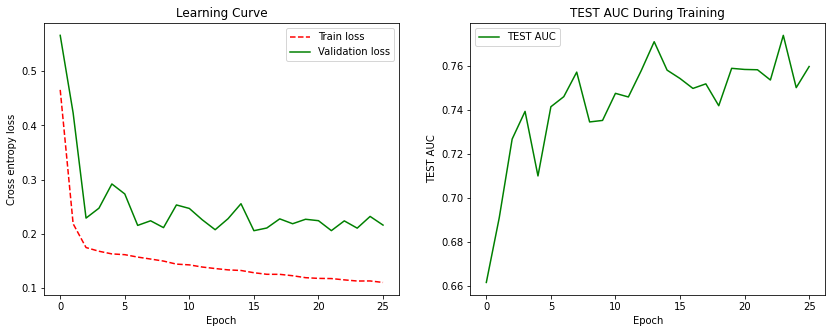


 Test AUC is 0.7543886502583822

 Test AUC in each class is:
(0, 0.5821713391066099)
(1, 0.7321891191709844)
(2, 0.8015887972398997)
(3, 0.8114119117034568)
(4, 0.6954783083645443)
(5, 0.8645059288537549)
(6, 0.800260078023407)
(7, 0.6824884932170543)
(8, 0.7196837944664032)
(9, 0.735937968555884)
(10, 0.7897163120567375)
(11, 0.837231182795699)


In [ ]:
# without scheduler
# random scaffold split - seed 213
# with skipconnections for both edge and node updaters

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
#dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M2(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM_M2(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.GNN3 = DGM_M2(200,200,200,100,100,100,100,100,100,100,100,100,1,100,100,num_layers=1)
        self.linear_1 = nn.Linear(100, 40)
        self.linear_2 = nn.Linear(40, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(40)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN2(mol_dgl_graph,fg)
      output = self.GNN3(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=32, optimizer=optimizer, patience=10, n_epochs=200)

[ 16/200] Train_Loss: 0.13301 Valid_Loss: 0.33074 Test_AUC: 0.76349
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 398.1036887168884 seconds in cuda:0




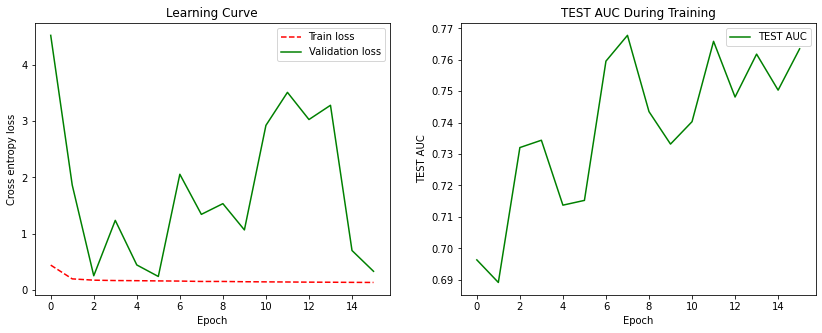


 Test AUC is 0.7152527968088785

 Test AUC in each class is:
(0, 0.6775771808796908)
(1, 0.7468696027633852)
(2, 0.7726251395271299)
(3, 0.6033597112314314)
(4, 0.7161555867665418)
(5, 0.75699604743083)
(6, 0.7486779367143477)
(7, 0.6498455668604651)
(8, 0.7330171277997365)
(9, 0.7262134258664268)
(10, 0.7406413814369411)
(11, 0.7110551075268817)


In [ ]:
# without scheduler
# random scaffold split - seed 213
# with skipconnections for both edge and node updaters

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
#dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M2(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM_M2(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.GNN3 = DGM_M2(200,200,200,100,100,100,100,100,100,100,100,100,1,100,100,num_layers=1)
        self.linear_1 = nn.Linear(100, 70)
        self.linear_2 = nn.Linear(70, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(70)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN2(mol_dgl_graph,fg)
      output = self.GNN3(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=32, optimizer=optimizer, patience=10, n_epochs=200)

[ 26/200] Train_Loss: 0.12295 Valid_Loss: 0.31815 Test_AUC: 0.62558
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 501.0134553909302 seconds in cuda:0




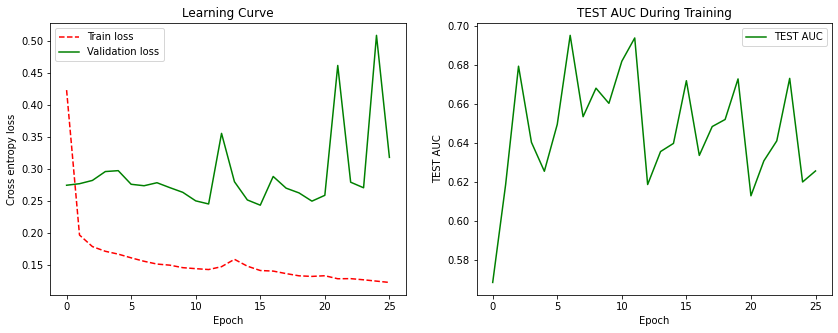


 Test AUC is 0.6719988187154134

 Test AUC in each class is:
(0, 0.6969029795978277)
(1, 0.760146804835924)
(2, 0.7343693373729759)
(3, 0.5743162571150909)
(4, 0.6258778089887641)
(5, 0.7103030303030303)
(6, 0.6977893368010403)
(7, 0.6080123546511628)
(8, 0.6499604743083005)
(9, 0.6444330206057489)
(10, 0.6569688559975332)
(11, 0.7049059139784946)


In [ ]:
# without scheduler
# random scaffold split - seed 213
# with skipconnections for both edge and node updaters

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
#dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M2(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=2)
        self.GNN2 = DGM_M2(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 70)
        self.linear_2 = nn.Linear(70, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(70)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=32, optimizer=optimizer, patience=10, n_epochs=200)

[ 22/200] Train_Loss: 0.10763 Valid_Loss: 0.21528 Test_AUC: 0.77753
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 367.1359760761261 seconds in cuda:0




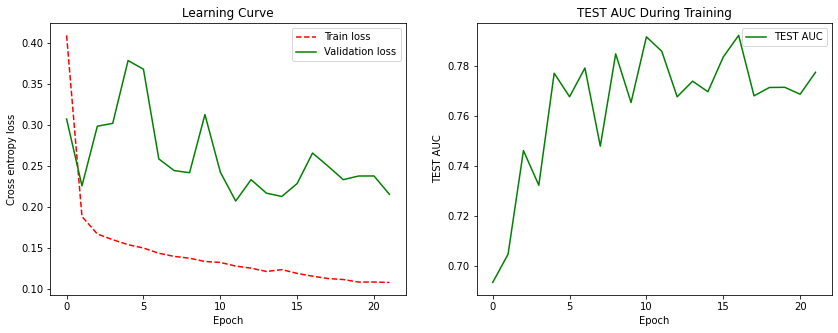


 Test AUC is 0.7859095732371012

 Test AUC in each class is:
(0, 0.6586427907431871)
(1, 0.7184801381692574)
(2, 0.8334517199889827)
(3, 0.8341246702762738)
(4, 0.711376404494382)
(5, 0.8586034255599473)
(6, 0.8606848721283051)
(7, 0.7418544089147286)
(8, 0.7809749670619236)
(9, 0.7905153579231461)
(10, 0.8181467776749923)
(11, 0.8240591397849463)


In [ ]:
# without scheduler
# random scaffold split - seed 213
# with skipconnections for both edge and node updaters

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
#dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M2(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM_M2(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 70)
        self.linear_2 = nn.Linear(70, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(70)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=32, optimizer=optimizer, patience=10, n_epochs=200)

In [ ]:
model7859 = model

[ 11/200] Train_Loss: 0.09281 Valid_Loss: 0.22141 Test_AUC: 0.78898
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 187.44504380226135 seconds in cuda:0




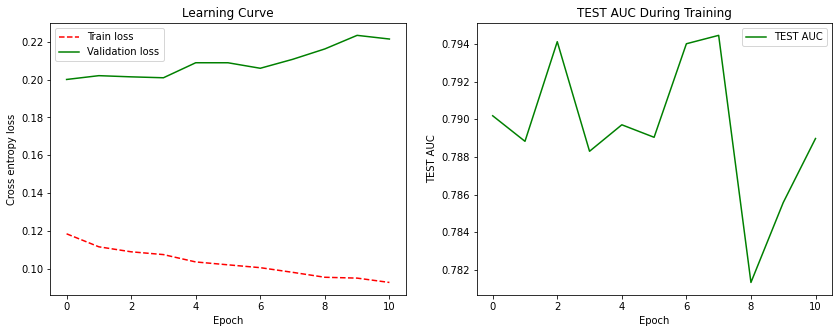


 Test AUC is 0.7901856899261475

 Test AUC in each class is:
(0, 0.6106952394931259)
(1, 0.7902633851468048)
(2, 0.8229708768827102)
(3, 0.8514507843953908)
(4, 0.7338483146067416)
(5, 0.8471146245059289)
(6, 0.8454269614217599)
(7, 0.7347837936046512)
(8, 0.8069565217391305)
(9, 0.7877307972411429)
(10, 0.8333795868023436)
(11, 0.8176075268817204)


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=32, optimizer=optimizer, patience=10, n_epochs=200)

In [ ]:
model7901 = model

[ 12/200] Train_Loss: 0.09415 Valid_Loss: 0.20528 Test_AUC: 0.78761
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 143.80264973640442 seconds in cuda:0




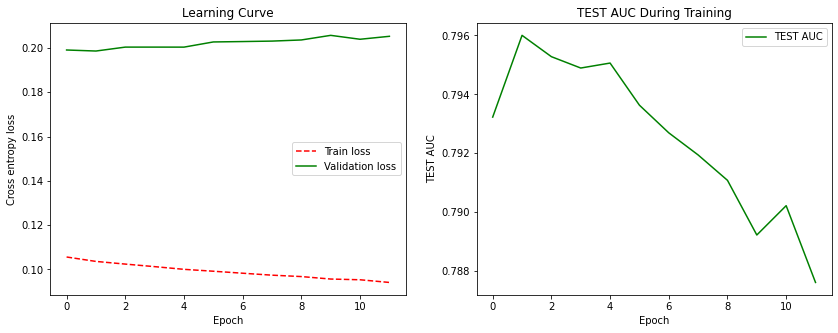


 Test AUC is 0.7960028648376465

 Test AUC in each class is:
(0, 0.6412740349332159)
(1, 0.7845423143350605)
(2, 0.8241015902468725)
(3, 0.8455643481882549)
(4, 0.7406757178526842)
(5, 0.85733860342556)
(6, 0.8500216731686172)
(7, 0.7495609253875968)
(8, 0.7863504611330698)
(9, 0.805080752259778)
(10, 0.8397008942337343)
(11, 0.8278225806451613)


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=256, optimizer=optimizer, patience=10, n_epochs=200)

In [ ]:
model7960 = model

In [ ]:
val_losses

[0.19909252639322292,
 0.19862834917022198,
 0.20039782944310214,
 0.200400210583956,
 0.20038877319102086,
 0.2027259034367509,
 0.20290612474102931,
 0.20311105966872486,
 0.2036239628895337,
 0.20570438026925156,
 0.20394166645571343,
 0.20527555385311902]

In [ ]:
!ls '/content/drive/MyDrive/GMLG_Research/Saved_Models/'

tox21_213_7960_2.pt  tox21_213_7960.pt


In [ ]:
 save_path2="/content/drive/MyDrive/GMLG_Research/Saved_Models/tox21_213_7960_2.pt"
 #torch.save(model7960, save_path1)
############# Save Just Weights
torch.save(model.state_dict(), save_path2)

[ 34/200] Train_Loss: 0.10577 Valid_Loss: 0.20523 Test_AUC: 0.79255
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 570.718181848526 seconds in cuda:0




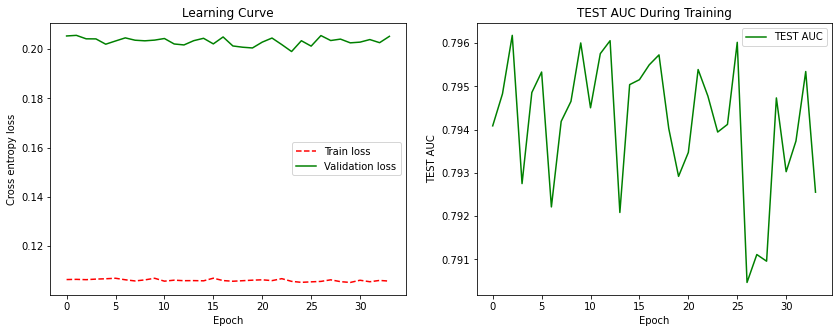


 Test AUC is 0.793944517771403

 Test AUC in each class is:
(0, 0.6613826508146191)
(1, 0.7763385146804835)
(2, 0.8294797268892337)
(3, 0.8491184228793558)
(4, 0.7339263420724095)
(5, 0.8496442687747036)
(6, 0.8541829215431296)
(7, 0.7517562984496124)
(8, 0.76300395256917)
(9, 0.7844750032129546)
(10, 0.8432469935245144)
(11, 0.8307795698924731)


In [ ]:
optimizer = torch.optim.Adam(model7960.parameters(), lr=0.000001)
model, train_losses, val_losses, test_aucs = train_model(model7960, batch_size=32, optimizer=optimizer, patience=10, n_epochs=200)

[ 30/200] Train_Loss: 0.11254 Valid_Loss: 0.20548 Test_AUC: 0.79290
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 690.5834817886353 seconds in cuda:0




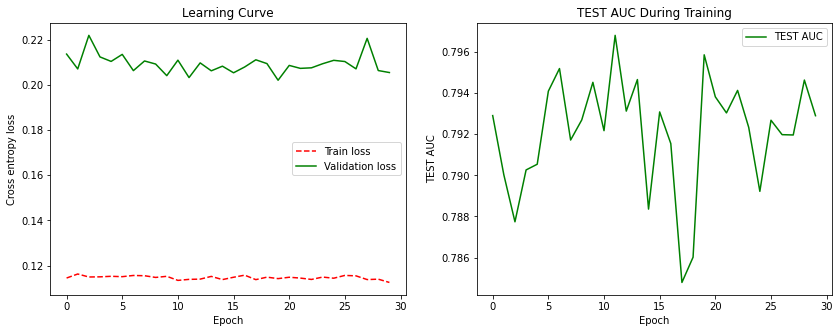


 Test AUC is 0.7958672841389974

 Test AUC in each class is:
(0, 0.6573707128528793)
(1, 0.7814119170984456)
(2, 0.8306104402533956)
(3, 0.8530889906983201)
(4, 0.7428214731585518)
(5, 0.8537022397891963)
(6, 0.8402254009536194)
(7, 0.7547238372093024)
(8, 0.776231884057971)
(9, 0.7865312941781262)
(10, 0.8427073697193955)
(11, 0.8309811827956989)


In [ ]:
optimizer = torch.optim.Adam(model7960.parameters(), lr=0.000001)
model, train_losses, val_losses, test_aucs = train_model(model7960, batch_size=16, optimizer=optimizer, patience=10, n_epochs=200)

[ 13/200] Train_Loss: 0.11417 Valid_Loss: 0.21139 Test_AUC: 0.79316
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 306.1248872280121 seconds in cuda:0




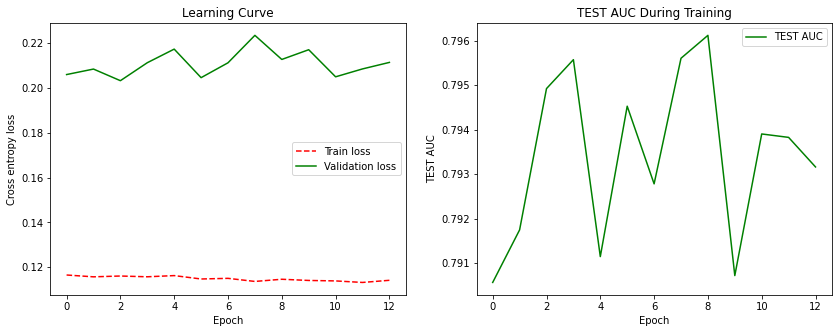


 Test AUC is 0.7949249744415283

 Test AUC in each class is:
(0, 0.6537991095454767)
(1, 0.7792530224525043)
(2, 0.8262325500485627)
(3, 0.8508954602249063)
(4, 0.736189138576779)
(5, 0.8542819499341239)
(6, 0.8490680537494582)
(7, 0.7511658187984497)
(8, 0.7713833992094862)
(9, 0.7928715246540718)
(10, 0.8423065063213074)
(11, 0.8316532258064516)


In [ ]:
optimizer = torch.optim.Adam(model7960.parameters(), lr=0.000005)
model, train_losses, val_losses, test_aucs = train_model(model7960, batch_size=16, optimizer=optimizer, patience=10, n_epochs=200)

[ 11/200] Train_Loss: 0.09912 Valid_Loss: 0.20239 Test_AUC: 0.79234
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 139.15590167045593 seconds in cuda:0




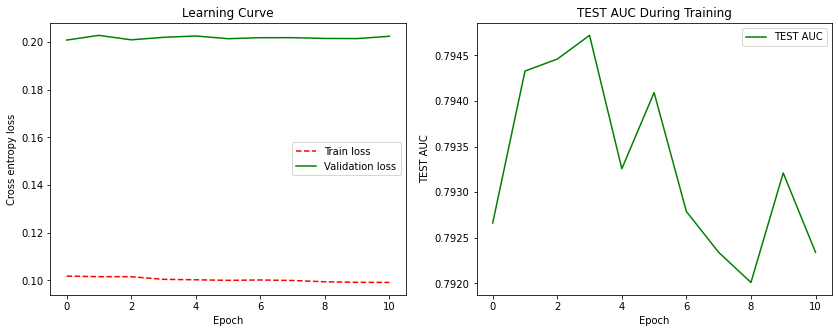


 Test AUC is 0.7926620642344157

 Test AUC in each class is:
(0, 0.6475854983120505)
(1, 0.7815198618307427)
(2, 0.826189061073018)
(3, 0.8441482715535193)
(4, 0.737125468164794)
(5, 0.8470619235836627)
(6, 0.8501083658430862)
(7, 0.7516351744186046)
(8, 0.7694861660079051)
(9, 0.7923574519127791)
(10, 0.8390225100215849)
(11, 0.8257056451612904)


In [ ]:
optimizer = torch.optim.Adam(model7960.parameters(), lr=0.00001)
model, train_losses, val_losses, test_aucs = train_model(model7960, batch_size=128, optimizer=optimizer, patience=10, n_epochs=200)

[ 15/200] Train_Loss: 0.10223 Valid_Loss: 0.20230 Test_AUC: 0.79311
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 206.7544059753418 seconds in cuda:0




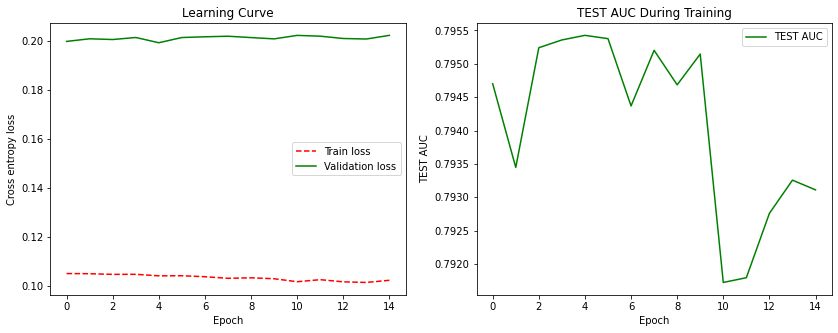


 Test AUC is 0.7954267660776774

 Test AUC in each class is:
(0, 0.6526738098732816)
(1, 0.780548359240069)
(2, 0.8282765318991636)
(3, 0.8458975426905456)
(4, 0.7343945068664169)
(5, 0.8553886693017128)
(6, 0.8454269614217599)
(7, 0.7512415213178294)
(8, 0.7753359683794467)
(9, 0.804266803752731)
(10, 0.8412272587110701)
(11, 0.8304435483870968)


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=64, optimizer=optimizer, patience=10, n_epochs=200)

In [ ]:
val_losses

[0.19982221086972213,
 0.20089329004592213,
 0.20059295358328982,
 0.20142221024514462,
 0.19928133990116045,
 0.20141036422164352,
 0.20170719900654954,
 0.20194115888417757,
 0.20138949269992637,
 0.20085916452176422,
 0.20228065537005702,
 0.2019600977842835,
 0.20101121041357595,
 0.20080032385172059,
 0.20229619368435017]

[ 19/200] Train_Loss: 0.12843 Valid_Loss: 0.24973 Test_AUC: 0.76190
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 434.68651366233826 seconds in cuda:0




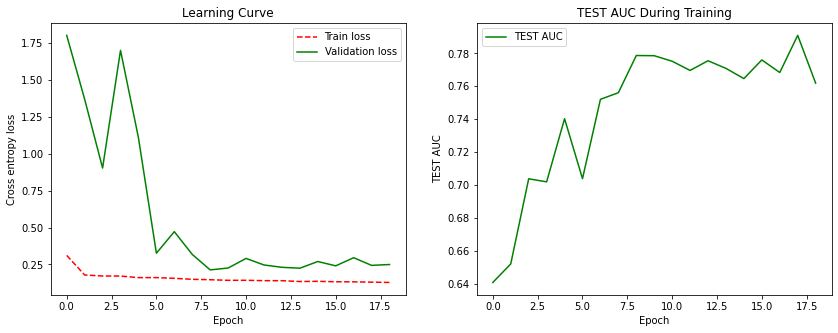


 Test AUC is 0.7786760330200195

 Test AUC in each class is:
(0, 0.6730759821909095)
(1, 0.734671848013817)
(2, 0.8392067610860647)
(3, 0.80197140080522)
(4, 0.7188865480649189)
(5, 0.866772068511199)
(6, 0.8641525791070654)
(7, 0.7231710271317829)
(8, 0.7773913043478261)
(9, 0.769352696739922)
(10, 0.8261332099907492)
(11, 0.7493279569892473)


In [ ]:
# without scheduler
# random scaffold split - seed 213
# with skipconnections for both edge and node updaters

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
#dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M2(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM_M2(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 70)
        self.linear_2 = nn.Linear(70, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(70)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=16, optimizer=optimizer, patience=10, n_epochs=200)

[ 19/200] Train_Loss: 0.10532 Valid_Loss: 0.22374 Test_AUC: 0.77361
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 260.28342604637146 seconds in cuda:0




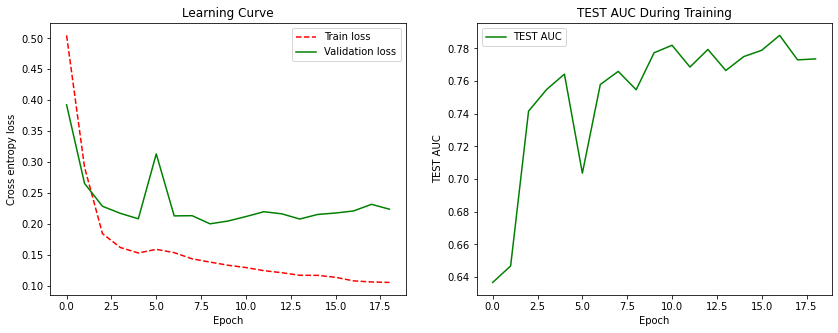


 Test AUC is 0.7546975612640381

 Test AUC in each class is:
(0, 0.6014971378247468)
(1, 0.7849740932642487)
(2, 0.8401780148732296)
(3, 0.7973344439816743)
(4, 0.6835986267166042)
(5, 0.7736495388669301)
(6, 0.7537928045080191)
(7, 0.7557382509689923)
(8, 0.7392885375494072)
(9, 0.7430921475388766)
(10, 0.8180388529139686)
(11, 0.7651881720430108)


In [ ]:
# without scheduler
# random scaffold split - seed 213
# with skipconnections for both edge and node updaters

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
#dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M2(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM_M2(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 70)
        self.linear_2 = nn.Linear(70, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(70)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=64, optimizer=optimizer, patience=10, n_epochs=200)

[ 16/200] Train_Loss: 0.08085 Valid_Loss: 0.25335 Test_AUC: 0.76973
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 101.96132850646973 seconds in cuda:0




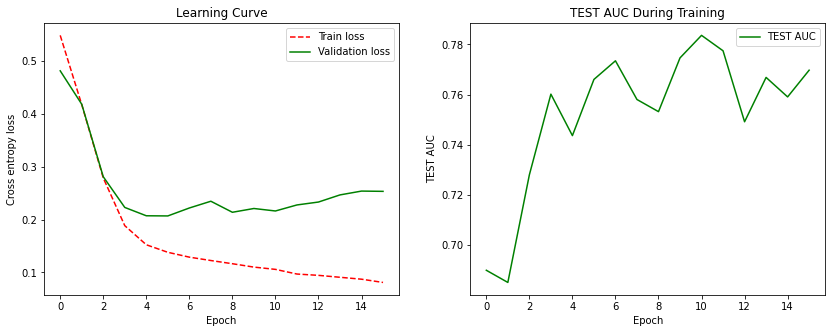


 Test AUC is 0.7660497029622396

 Test AUC in each class is:
(0, 0.5683741866040412)
(1, 0.7403929188255614)
(2, 0.825986112520476)
(3, 0.7620991253644316)
(4, 0.7295958177278402)
(5, 0.8610803689064559)
(6, 0.8441265713047248)
(7, 0.6854257509689923)
(8, 0.8012121212121212)
(9, 0.753801996315812)
(10, 0.8173758865248226)
(11, 0.803125)


In [ ]:
# without scheduler
# random scaffold split - seed 213
# with skipconnections for both edge and node updaters

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
#dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M2(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        #self.GNN2 = DGM_M(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(300, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      #(fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=128, optimizer=optimizer, patience=10, n_epochs=200)

[ 18/200] Train_Loss: 0.07973 Valid_Loss: 0.26222 Test_AUC: 0.77475
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 129.4207980632782 seconds in cuda:0




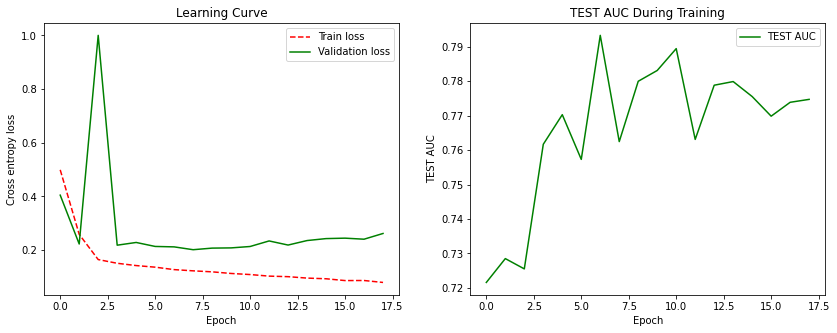


 Test AUC is 0.7624799410502116

 Test AUC in each class is:
(0, 0.6013014335339302)
(1, 0.8144430051813472)
(2, 0.8496006262412478)
(3, 0.7289185061779813)
(4, 0.7185744382022473)
(5, 0.7322793148880107)
(6, 0.8433463372345037)
(7, 0.7146620639534883)
(8, 0.7350197628458497)
(9, 0.7650687572291479)
(10, 0.8287696577243292)
(11, 0.8177755376344086)


In [ ]:
# without scheduler
# random scaffold split - seed 213
# with skipconnections for both edge and node updaters

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
#dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M2(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        #self.GNN2 = DGM_M(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(300, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      #(fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=64, optimizer=optimizer, patience=10, n_epochs=200)

[ 24/200] Train_Loss: 0.12134 Valid_Loss: 0.20473 Test_AUC: 0.78394
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 279.70512199401855 seconds in cuda:0




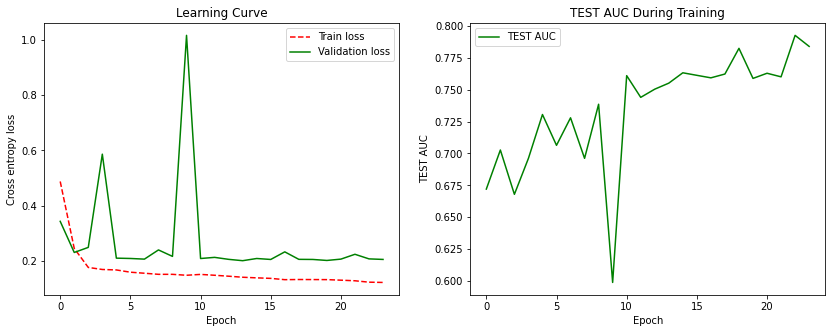


 Test AUC is 0.7551284631093343

 Test AUC in each class is:
(0, 0.5993933166984687)
(1, 0.6800518134715027)
(2, 0.830233535798675)
(3, 0.7279466888796335)
(4, 0.7046270287141074)
(5, 0.8291963109354413)
(6, 0.9046380580840918)
(7, 0.6710271317829457)
(8, 0.7919894598155468)
(9, 0.745362635479587)
(10, 0.8074853530681467)
(11, 0.7695900537634409)


In [ ]:
# without scheduler
# random scaffold split - seed 213
# with skipconnections for both edge and node updaters

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
#dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        #self.GNN2 = DGM_M(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(300, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      #(fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=64, optimizer=optimizer, patience=10, n_epochs=200)

[ 12/200] Train_Loss: 0.11014 Valid_Loss: 1.10398 Test_AUC: 0.74934
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 173.4972701072693 seconds in cuda:0




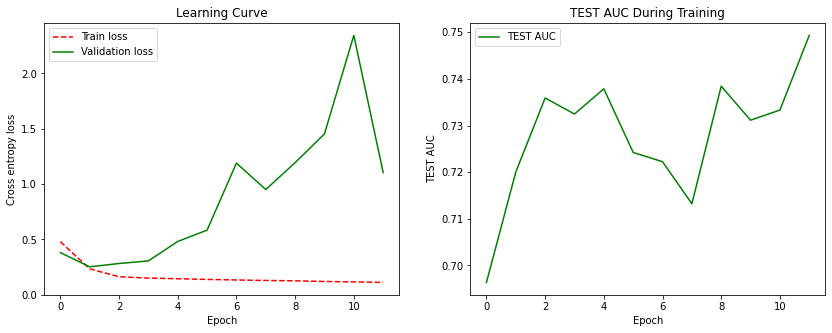


 Test AUC is 0.7200342019399008

 Test AUC in each class is:
(0, 0.7568863447331082)
(1, 0.6991580310880829)
(2, 0.7552150529840684)
(3, 0.7236429265583785)
(4, 0.6845349563046191)
(5, 0.7958366271409749)
(6, 0.8011270047680972)
(7, 0.5767774951550387)
(8, 0.7095652173913043)
(9, 0.7285267532022448)
(10, 0.7468085106382979)
(11, 0.6623319892473117)


In [ ]:
# without scheduler
# random scaffold split - seed 213
# with skipconnections for both edge and node updaters

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
#dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=2)
        #self.GNN2 = DGM_M(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(300, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      #(fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=64, optimizer=optimizer, patience=10, n_epochs=200)

[ 12/200] Train_Loss: 0.11978 Valid_Loss: 0.48596 Test_AUC: 0.55879
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 188.0403115749359 seconds in cuda:0




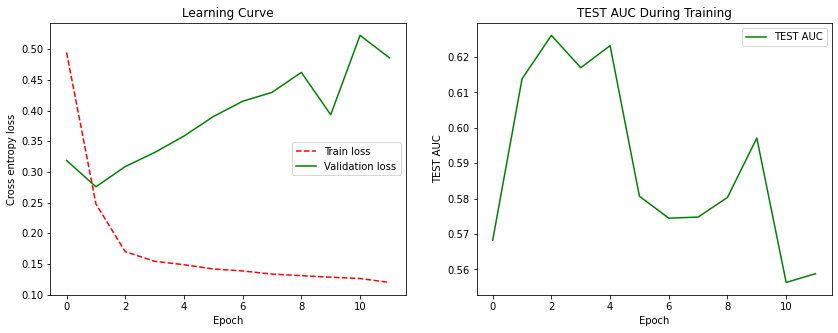


 Test AUC is 0.6137819290161133

 Test AUC in each class is:
(0, 0.6142179167278242)
(1, 0.7281951640759932)
(2, 0.5440615803893714)
(3, 0.38120227682909896)
(4, 0.6116573033707865)
(5, 0.7318050065876153)
(6, 0.8335500650195059)
(7, 0.46952216569767447)
(8, 0.5835046113306983)
(9, 0.5751617187165317)
(10, 0.6756706753006475)
(11, 0.6168346774193548)


In [ ]:
# without scheduler
# random scaffold split - seed 213
# with skipconnections for both edge and node updaters

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
#dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=2)
        #self.GNN2 = DGM_M(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(300, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      #(fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=64, optimizer=optimizer, patience=10, n_epochs=200)

[ 19/200] Train_Loss: 0.12322 Valid_Loss: 0.32402 Test_AUC: 0.77870
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 616.7116408348083 seconds in cuda:0




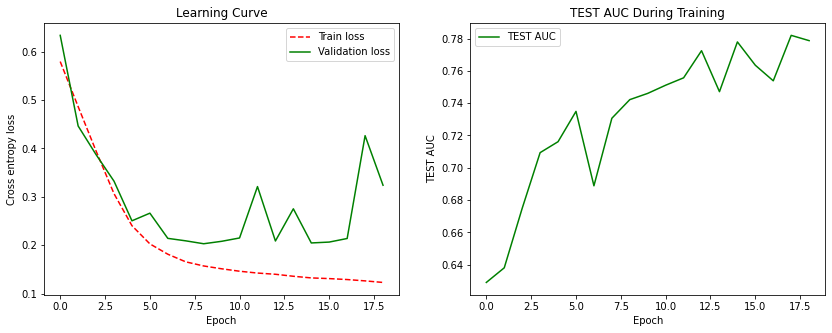


 Test AUC is 0.7421691417694092

 Test AUC in each class is:
(0, 0.5621116492979109)
(1, 0.6893350604490501)
(2, 0.8244060130756853)
(3, 0.8099125364431486)
(4, 0.6940543071161048)
(5, 0.7502503293807641)
(6, 0.8416991764195927)
(7, 0.6994307170542635)
(8, 0.6772595520421607)
(9, 0.7496037355952534)
(10, 0.7966080789392538)
(11, 0.8113575268817204)


In [ ]:
# without scheduler
# random scaffold split - seed 213
# with skipconnections for both edge and node updaters

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
#dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM_M(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 70)
        self.linear_2 = nn.Linear(70, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(70)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=16, optimizer=optimizer, patience=10, n_epochs=200)

[ 26/200] Train_Loss: 0.11026 Valid_Loss: 0.21726 Test_AUC: 0.78032
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 3339.9175159931183 seconds in cpu




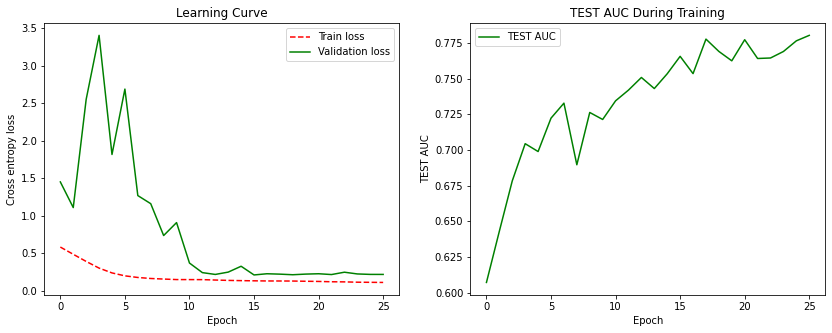


 Test AUC is 0.7656165758768717

 Test AUC in each class is:
(0, 0.6414697392240325)
(1, 0.756800518134715)
(2, 0.804589536552484)
(3, 0.7877551020408163)
(4, 0.7231585518102371)
(5, 0.8220816864295125)
(6, 0.882011270047681)
(7, 0.7117550872093024)
(8, 0.6783135704874835)
(9, 0.7793771151951334)
(10, 0.7999845821769965)
(11, 0.8001008064516129)


In [ ]:
# without scheduler
# random scaffold split - seed 213
# with skipconnections for both edge and node updaters

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
#dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 70)
        self.linear_2 = nn.Linear(70, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(70)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=16, optimizer=optimizer, patience=10, n_epochs=200)

[ 29/200] Train_Loss: 0.06334 Valid_Loss: 0.28698 Test_AUC: 0.74388
EarlyStopping counter: 20 out of 20
Early Stopping

 Training Time was 3745.1095542907715 seconds in cpu




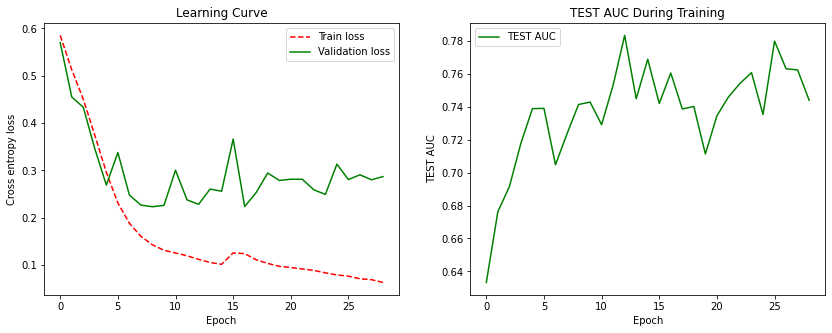


 Test AUC is 0.7412897745768229

 Test AUC in each class is:
(0, 0.5765448407456334)
(1, 0.7338082901554405)
(2, 0.8404969340272241)
(3, 0.718172983479106)
(4, 0.6947370474406992)
(5, 0.8134914361001317)
(6, 0.7761595145210229)
(7, 0.7054112160852714)
(8, 0.6345191040843214)
(9, 0.7492181810392837)
(10, 0.8331945729263028)
(11, 0.8197244623655914)


In [ ]:
# without scheduler
# random scaffold split - seed 213
# with skipconnections for both edge and node updaters

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
#dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 70)
        self.linear_2 = nn.Linear(70, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(70)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=256, optimizer=optimizer, patience=20, n_epochs=200)

[ 28/200] Train_Loss: 0.06455 Valid_Loss: 0.26949 Test_AUC: 0.75786
EarlyStopping counter: 20 out of 20
Early Stopping

 Training Time was 607.6078567504883 seconds in cuda:0




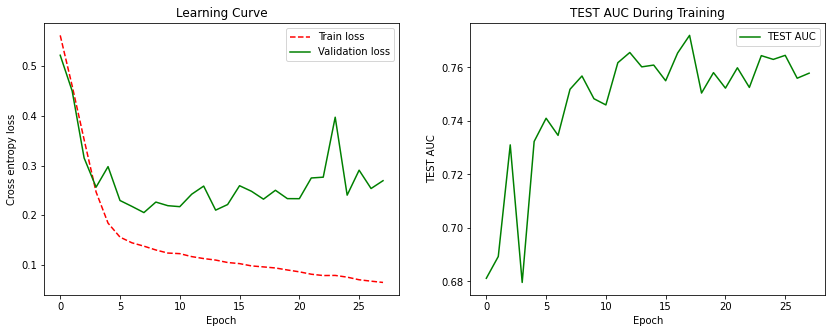


 Test AUC is 0.7518360614776611

 Test AUC in each class is:
(0, 0.6065365233132737)
(1, 0.6601899827288429)
(2, 0.797935723294145)
(3, 0.8281827016520894)
(4, 0.7168968476903871)
(5, 0.7976811594202898)
(6, 0.8399653229302123)
(7, 0.7469870397286822)
(8, 0.7548353096179182)
(9, 0.7274129289294434)
(10, 0.792923219241443)
(11, 0.752486559139785)


In [ ]:
# without scheduler
# random scaffold split - seed 213
# with skipconnections for both edge and node updaters

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 50)
        self.linear_2 = nn.Linear(50, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(50)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=128, optimizer=optimizer, patience=20, n_epochs=200)

[ 31/200] Train_Loss: 0.10838 Valid_Loss: 0.36137 Test_AUC: 0.76952
EarlyStopping counter: 20 out of 20
Early Stopping

 Training Time was 1408.2873814105988 seconds in cuda:0




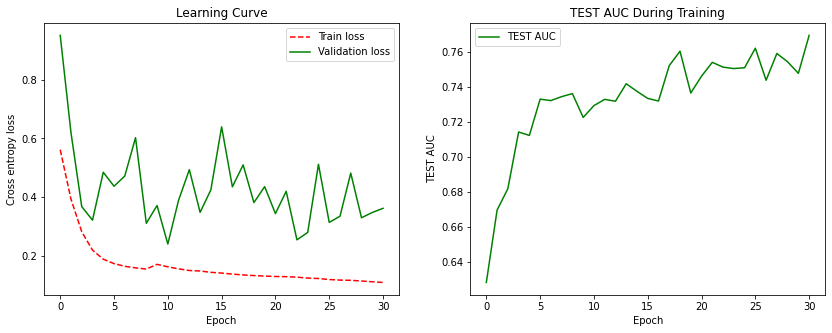


 Test AUC is 0.7293337980906168

 Test AUC in each class is:
(0, 0.6268408434854935)
(1, 0.684153713298791)
(2, 0.7769740370815998)
(3, 0.7552964042759962)
(4, 0.7016034644194757)
(5, 0.8276152832674571)
(6, 0.7618552232336367)
(7, 0.6849034035852712)
(8, 0.7064031620553359)
(9, 0.6909566036927559)
(10, 0.7768347209374037)
(11, 0.7585685483870969)


In [ ]:
# without scheduler
# random scaffold split - seed 213
# with skipconnections for both edge and node updaters

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM(135,12,200,400,400,400,400,400,400,400,400,400,1,400,400, num_layers=1)
        self.GNN2 = DGM(400,400,400,300,300,300,300,300,300,300,300,300,1,300,300, num_layers=1)
        self.GNN3 = DGM(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200, num_layers=1)
        self.GNN4 = DGM(200,200,200,100,100,100,100,100,100,100,100,100,1,100,100, num_layers=1)
        self.linear_1 = nn.Linear(100, 40)
        self.linear_2 = nn.Linear(40, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(40)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN2(mol_dgl_graph,fg)
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN3(mol_dgl_graph,fg)
      output = self.GNN4(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=64, optimizer=optimizer, patience=20, n_epochs=200)

#count_parameters(model)

[ 18/200] Train_Loss: 0.10434 Valid_Loss: 0.22363 Test_AUC: 0.77012
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 810.5838284492493 seconds in cuda:0




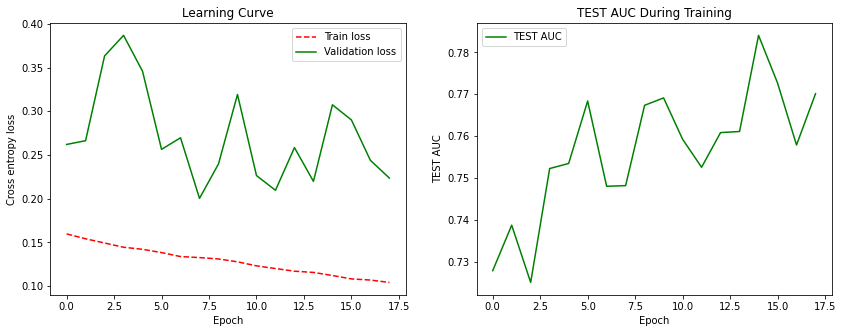


 Test AUC is 0.7481547196706136

 Test AUC in each class is:
(0, 0.6184500220167327)
(1, 0.7035837651122625)
(2, 0.7956742965658206)
(3, 0.765847563515202)
(4, 0.7110447877652935)
(5, 0.8139393939393939)
(6, 0.8233203294321629)
(7, 0.7398861434108528)
(8, 0.7228458498023715)
(9, 0.7248854046180868)
(10, 0.8204748689485045)
(11, 0.7379032258064517)


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=64, optimizer=optimizer, patience=10, n_epochs=200)

In [ ]:
model16m = model

In [ ]:
count_parameters(model)

+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |   54000    |
|    GNN1.linear_0_v.bias    |    400     |
|     GNN1.bn_0_v.weight     |    400     |
|      GNN1.bn_0_v.bias      |    400     |
|   GNN1.linear_0_e.weight   |    4800    |
|    GNN1.linear_0_e.bias    |    400     |
|     GNN1.bn_0_e.weight     |    400     |
|      GNN1.bn_0_e.bias      |    400     |
|   GNN1.linear_0_g.weight   |   80000    |
|    GNN1.linear_0_g.bias    |    400     |
|     GNN1.bn_0_g.weight     |    400     |
|      GNN1.bn_0_g.bias      |    400     |
|   GNN1.linear_e_0.weight   |  1120000   |
|    GNN1.linear_e_0.bias    |    400     |
|     GNN1.bn_e_0.weight     |    400     |
|      GNN1.bn_e_0.bias      |    400     |
|   GNN1.linear_e_1.weight   |   160000   |
|    GNN1.linear_e_1.bias    |    400     |
|     GNN1.bn_e_1.weight     |    400     |
|      GNN1.bn_e_1.bias      |  

6786432

[ 30/200] Train_Loss: 0.08293 Valid_Loss: 0.27543 Test_AUC: 0.75507
EarlyStopping counter: 20 out of 20
Early Stopping

 Training Time was 691.7944786548615 seconds in cuda:0




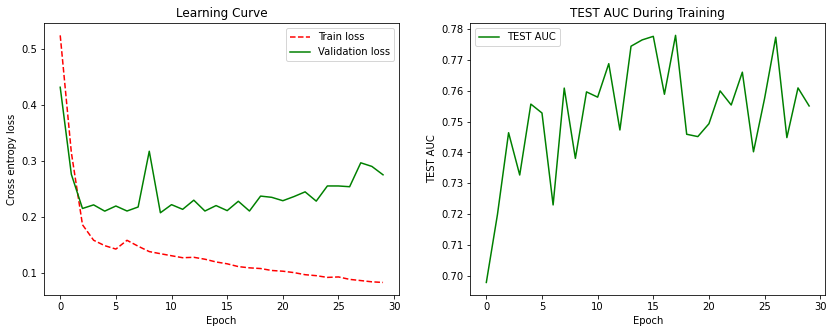


 Test AUC is 0.7596308390299479

 Test AUC in each class is:
(0, 0.6342776065365233)
(1, 0.7585276338514679)
(2, 0.8256526970413001)
(3, 0.708482576704151)
(4, 0.7202520287141074)
(5, 0.841159420289855)
(6, 0.8374512353706112)
(7, 0.7084695978682172)
(8, 0.7482476943346509)
(9, 0.7553870539347984)
(10, 0.8126426148627813)
(11, 0.7650201612903225)


In [ ]:
# without scheduler
# random scaffold split - seed 213
# with skipconnections for both edge and node updaters

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 50)
        self.linear_2 = nn.Linear(50, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(50)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=64, optimizer=optimizer, patience=20, n_epochs=200)

[ 27/200] Train_Loss: 0.07601 Valid_Loss: 0.27613 Test_AUC: 0.75630
EarlyStopping counter: 20 out of 20
Early Stopping

 Training Time was 628.8704438209534 seconds in cuda:0




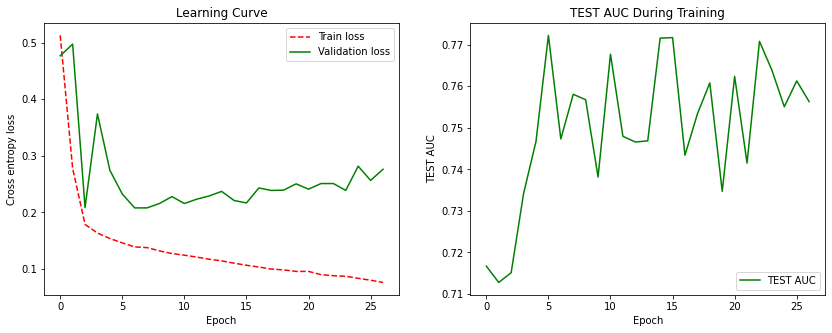


 Test AUC is 0.7473063468933105

 Test AUC in each class is:
(0, 0.5515436175938158)
(1, 0.6523100172711572)
(2, 0.8338576170940667)
(3, 0.7870054144106622)
(4, 0.7210908239700374)
(5, 0.7869301712779974)
(6, 0.8192457737321197)
(7, 0.7303324854651162)
(8, 0.7202108036890646)
(9, 0.7548729811935055)
(10, 0.8189793401171755)
(11, 0.7912970430107527)


In [ ]:
# without scheduler
# random scaffold split - seed 213
# with skipconnections for both edge and node updaters

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 70)
        self.linear_2 = nn.Linear(70, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(70)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=64, optimizer=optimizer, patience=20, n_epochs=200)

#count_parameters(model)

[ 28/200] Train_Loss: 0.07762 Valid_Loss: 0.37014 Test_AUC: 0.77345
EarlyStopping counter: 20 out of 20
Early Stopping

 Training Time was 669.4132187366486 seconds in cuda:0




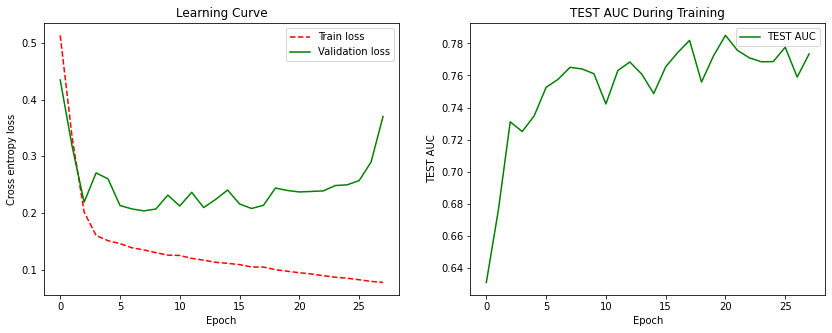


 Test AUC is 0.7650751272837321

 Test AUC in each class is:
(0, 0.6116248348745046)
(1, 0.6957037996545768)
(2, 0.7820912398706927)
(3, 0.8358184089962516)
(4, 0.7097378277153559)
(5, 0.8160737812911727)
(6, 0.8299956653662766)
(7, 0.7165697674418604)
(8, 0.8050592885375495)
(9, 0.7685387482328749)
(10, 0.8043786617329634)
(11, 0.8053091397849462)


In [ ]:
# without scheduler
# random scaffold split - seed 213
# with skipconnections for both edge and node updaters

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM(300,300,300,100,100,100,100,100,100,100,100,100,1,100,100,num_layers=1)
        self.linear_1 = nn.Linear(100, 40)
        self.linear_2 = nn.Linear(40, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(40)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=64, optimizer=optimizer, patience=20, n_epochs=200)

#count_parameters(model)

In [ ]:
model2 = model

[ 11/200] Train_Loss: 0.09337 Valid_Loss: 0.20472 Test_AUC: 0.77374
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 260.76640009880066 seconds in cuda:0




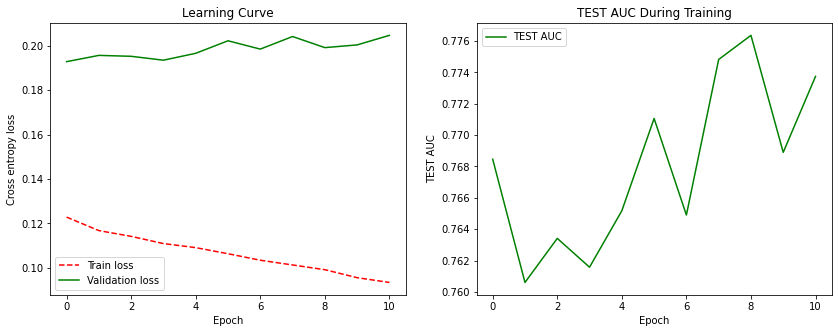


 Test AUC is 0.7684636116027832

 Test AUC in each class is:
(0, 0.5867214638680953)
(1, 0.6991580310880829)
(2, 0.8070829044837134)
(3, 0.844842426766625)
(4, 0.7205446317103621)
(5, 0.8455335968379448)
(6, 0.8230602514087559)
(7, 0.7513777858527131)
(8, 0.7500922266139658)
(9, 0.7698667694812149)
(10, 0.8346746839346285)
(11, 0.7886088709677419)


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=64, optimizer=optimizer, patience=10, n_epochs=200)

[ 37/200] Train_Loss: 0.07897 Valid_Loss: 0.24270 Test_AUC: 0.74753
EarlyStopping counter: 20 out of 20
Early Stopping

 Training Time was 487.66919565200806 seconds in cuda:0




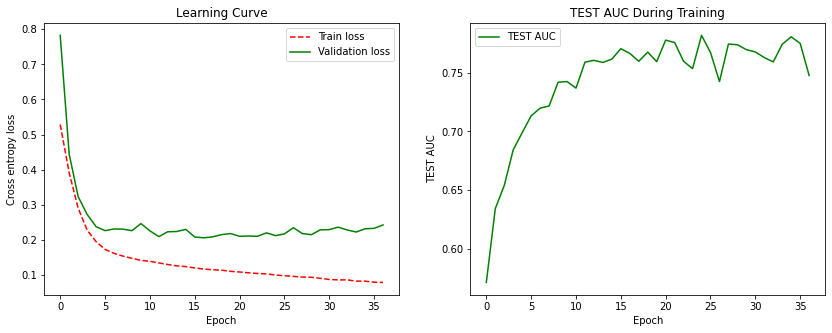


 Test AUC is 0.7663547197977701

 Test AUC in each class is:
(0, 0.7014041782866088)
(1, 0.8167098445595856)
(2, 0.806894452256353)
(3, 0.8131889490490074)
(4, 0.676439606741573)
(5, 0.7828194993412385)
(6, 0.8277416558300823)
(7, 0.6960695251937984)
(8, 0.7486166007905137)
(9, 0.6930557340530351)
(10, 0.816481652790626)
(11, 0.8168346774193549)


In [ ]:
# without scheduler
# random scaffold split - seed 213
# with skipconnections for both edge and node updaters

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM(300,300,300,100,100,100,100,100,100,100,100,100,1,100,100,num_layers=1)
        self.linear_1 = nn.Linear(100, 40)
        self.linear_2 = nn.Linear(40, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(40)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=64, optimizer=optimizer, patience=20, n_epochs=200)

#count_parameters(model)

[ 51/200] Train_Loss: 0.07136 Valid_Loss: 0.23269 Test_AUC: 0.75436
EarlyStopping counter: 30 out of 30
Early Stopping

 Training Time was 632.4289469718933 seconds in cuda:0




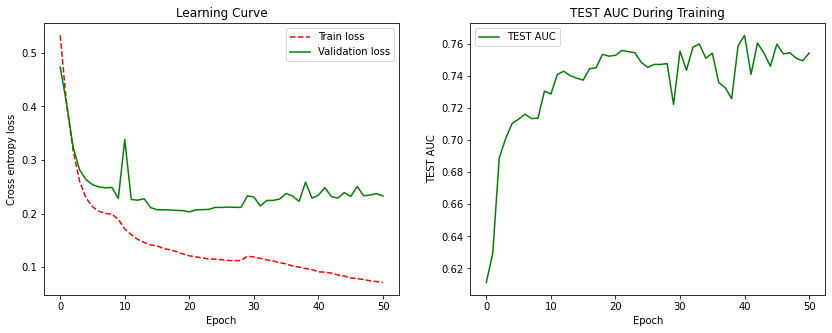


 Test AUC is 0.7529331048329672

 Test AUC in each class is:
(0, 0.6713146435735603)
(1, 0.7458981001727116)
(2, 0.8153603061623879)
(3, 0.8203526308482576)
(4, 0.7180867665418227)
(5, 0.8309354413702239)
(6, 0.6899869960988296)
(7, 0.7084090358527132)
(8, 0.7397101449275363)
(9, 0.7149895043481986)
(10, 0.8006167129201357)
(11, 0.7795362903225806)


In [ ]:
# with scheduler
# random scaffold split - seed 213
# with skipconnections for both edge and node updaters

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM(300,300,300,100,100,100,100,100,100,100,100,100,1,100,100,num_layers=1)
        self.linear_1 = nn.Linear(100, 40)
        self.linear_2 = nn.Linear(40, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(40)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=0)
model, train_losses, val_losses, test_aucs = train_model_scheduler(model, batch_size=128, optimizer=optimizer, scheduler=scheduler, patience=30, n_epochs=200)

#count_parameters(model)

[ 31/200] Train_Loss: 0.07498 Valid_Loss: 0.24480 Test_AUC: 0.74131
EarlyStopping counter: 20 out of 20
Early Stopping

 Training Time was 388.95278811454773 seconds in cuda:0




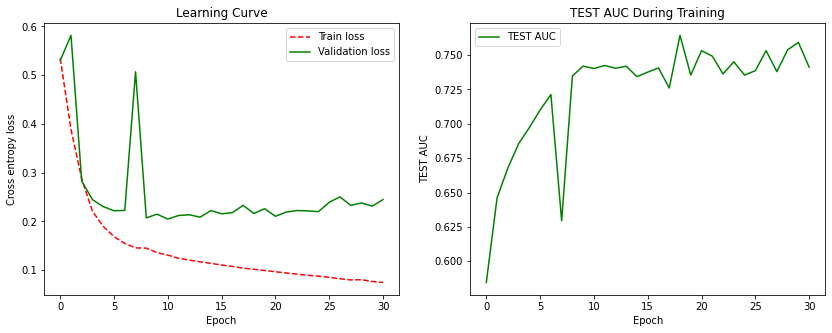


 Test AUC is 0.7402622699737549

 Test AUC in each class is:
(0, 0.6106463134204216)
(1, 0.7466537132987912)
(2, 0.8032413783105983)
(3, 0.7022629459947244)
(4, 0.711493445692884)
(5, 0.8578656126482214)
(6, 0.8182921543129605)
(7, 0.6869246608527132)
(8, 0.6821080368906457)
(9, 0.7080495223407446)
(10, 0.7998304039469628)
(11, 0.7557795698924731)


In [ ]:
# without scheduler
# random scaffold split - seed 213
# with skipconnections for both edge and node updaters

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM(300,300,300,100,100,100,100,100,100,100,100,100,1,100,100,num_layers=1)
        self.linear_1 = nn.Linear(100, 40)
        self.linear_2 = nn.Linear(40, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(40)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=128, optimizer=optimizer, patience=20, n_epochs=200)

#count_parameters(model)

[ 41/200] Train_Loss: 0.09502 Valid_Loss: 0.35759 Test_AUC: 0.77460
EarlyStopping counter: 20 out of 20
Early Stopping

 Training Time was 643.494439125061 seconds in cuda:0




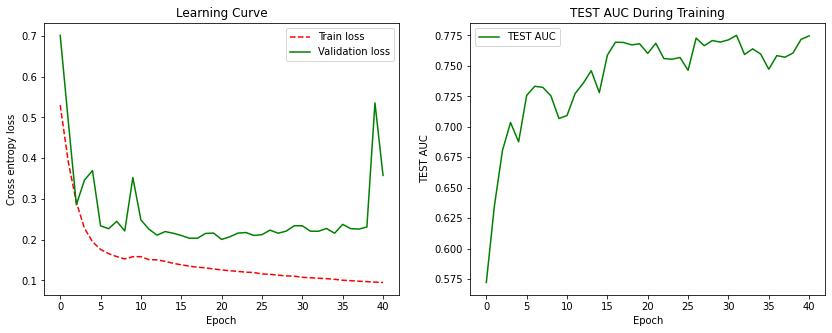


 Test AUC is 0.7601987520853678

 Test AUC in each class is:
(0, 0.6540437399089974)
(1, 0.7534542314335061)
(2, 0.8006755287534612)
(3, 0.7439122587810635)
(4, 0.7142244069912609)
(5, 0.8069565217391305)
(6, 0.8989163415691375)
(7, 0.6873183139534884)
(8, 0.7675889328063241)
(9, 0.7140041982607206)
(10, 0.8225871106999691)
(11, 0.7587029569892473)


In [ ]:
# without scheduler
# random scaffold split - seed 213
# with skipconnections for both edge and node updaters

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM(300,300,300,100,100,100,100,100,100,100,100,100,1,100,100,num_layers=1)
        self.linear_1 = nn.Linear(100, 40)
        self.linear_2 = nn.Linear(40, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(40)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=32, optimizer=optimizer, patience=20, n_epochs=200)

#count_parameters(model)

## ***Scratch***

In [ ]:
train_dataloader, val_dataloader, test_dataloader = loader(1)

In [ ]:
for i, (smiles, mol_dgl_graph, fg, labels, masks) in enumerate(train_dataloader):
  if mol_dgl_graph.num_edges() < 7:
    break
(smiles, mol_dgl_graph, fg, labels, masks)


(['CC(C)S'], Graph(num_nodes=4, num_edges=6,
       ndata_schemes={'h_0': Scheme(shape=(135,), dtype=torch.float32)}
       edata_schemes={'e_0': Scheme(shape=(12,), dtype=torch.float32)}), tensor([[8.9103e-01, 6.6012e-04, 4.5368e-05, 6.5297e-05, 2.5235e-04, 1.8195e-05,
          1.0185e-04, 6.1500e-04, 4.0878e-04, 2.3743e-03, 6.3535e-07, 3.0868e-06,
          1.7034e-05, 1.3407e-05, 4.0749e-10, 2.1752e-08, 6.8936e-07, 1.0022e-01,
          1.2343e-01, 2.5099e-11, 9.2584e-11, 5.8561e-17, 5.5287e-01, 3.9726e-01,
          7.5225e-13, 6.3135e-05, 9.7443e-01, 1.0780e-01, 1.1584e-02, 9.9939e-01,
          9.9311e-01, 2.2988e-05, 5.4722e-05, 1.0000e+00, 9.4251e-05, 3.1896e-04,
          1.0000e+00, 8.4156e-05, 1.2835e-02, 4.2669e-02, 1.2835e-02, 7.7494e-03,
          9.6210e-01, 4.9400e-03, 8.6072e-01, 9.5322e-01, 1.0929e-01, 2.7586e-04,
          6.5144e-05, 6.1316e-02, 3.3330e-02, 9.9386e-22, 1.4249e-01, 6.2963e-02,
          3.4723e-02, 4.8299e-15, 1.1178e-02, 4.0600e-02, 4.7447e-01, 8.8

In [ ]:
test_aucs

[69.90045674641927,
 69.59600321451823,
 74.77729797363281,
 73.89790344238281,
 75.7280985514323,
 78.87255350748698,
 75.92458089192708,
 78.5749003092448,
 78.22293090820312,
 79.93008422851562,
 78.95558675130208,
 71.56697591145833,
 79.81539408365886,
 78.35073852539062,
 77.17649332682292,
 78.38560485839844]

In [ ]:
seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
if device == 'cuda:0':
  dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M5(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        #self.GNN2 = DGM_M5(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(300, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      #(fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=32, optimizer=optimizer, patience=10, n_epochs=200)

In [ ]:
(fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = model.GNN1(mol_dgl_graph,fg)
e=mol_dgl_graph.edata['e_0']
e.shape
e

In [ ]:
e

tensor([[0.5599, 0.4368, 0.0000,  ..., 0.0000, 0.0000, 0.1821],
        [0.8224, 0.0000, 0.8536,  ..., 0.0000, 0.0000, 0.3982],
        [0.8224, 0.0000, 0.8536,  ..., 0.0000, 0.0000, 0.3982],
        [0.5599, 0.4368, 0.0000,  ..., 0.0000, 0.0000, 0.1821],
        [0.9965, 0.0000, 0.3066,  ..., 0.0000, 0.0000, 0.7898],
        [0.4699, 1.1065, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<ReluBackward0>)

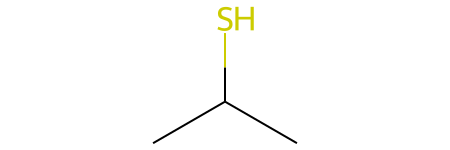

In [ ]:
mol = Chem.MolFromSmiles(smiles[0])
mol


In [ ]:
mol_dgl_graph.all_edges()

(tensor([0, 1, 1, 2, 1, 3], dtype=torch.int32),
 tensor([1, 0, 2, 1, 3, 1], dtype=torch.int32))

In [ ]:
mol_dgl_graph, fg = mol_dgl_graph.to(device), fg.to(device)
mol_dgl_graph


Graph(num_nodes=4, num_edges=6,
      ndata_schemes={'h_0': Scheme(shape=(135,), dtype=torch.float32)}
      edata_schemes={'e_0': Scheme(shape=(12,), dtype=torch.float32)})

In [ ]:

GNN = DGM_M4(135,12,200,10,10,10,10,10,10,10,10,10,1,10,10,num_layers=1)
GNN.to(device)
GNN.eval()
(fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = GNN(mol_dgl_graph,fg)
e=mol_dgl_graph.edata['e_0']
e.shape

torch.Size([6, 10])

In [ ]:
e

tensor([[0.8006, 0.5409, 1.1444, 0.0000, 0.8122, 0.0000, 0.2309, 0.7945, 0.2956,
         0.6661],
        [1.0435, 1.5014, 1.5411, 0.0000, 0.3775, 0.1859, 0.0000, 1.0934, 0.4476,
         0.1421],
        [0.9866, 1.6430, 0.8167, 0.0000, 0.3476, 0.0552, 0.0000, 1.1208, 0.6840,
         0.4756],
        [0.6536, 0.4780, 0.6878, 0.0000, 0.6615, 0.0608, 0.2263, 0.3982, 0.0366,
         0.6274],
        [0.2955, 0.4624, 0.7207, 0.0000, 0.3923, 0.3627, 0.3300, 0.0786, 0.0000,
         0.1948],
        [1.0844, 1.1075, 1.1265, 0.0000, 0.7632, 0.0000, 0.0000, 1.0781, 0.6713,
         0.8531]], grad_fn=<ReluBackward0>)

In [ ]:
smiles

['Cl[Ba]Cl']

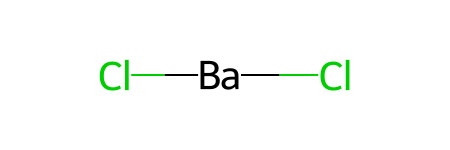

In [ ]:
mol = Chem.MolFromSmiles(smiles[0])
mol


In [ ]:
mol_dgl_graph, fg = mol_dgl_graph.to(device), fg.to(device)

In [ ]:
mol_dgl_graph

Graph(num_nodes=3, num_edges=4,
      ndata_schemes={'h_0': Scheme(shape=(135,), dtype=torch.float32)}
      edata_schemes={'e_0': Scheme(shape=(12,), dtype=torch.float32)})

In [ ]:

GNN = DGM_M4(135,12,200,10,10,10,10,10,10,10,10,10,1,10,10,num_layers=1)
GNN.to(device)
GNN.eval()
(fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = GNN(mol_dgl_graph,fg)

In [ ]:
e=mol_dgl_graph.edata['e_0']

In [ ]:
e.shape

torch.Size([4, 10])

In [ ]:
e

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2972, 0.0000, 0.0000,
         0.2405],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0551, 0.0000, 0.5983, 0.0000, 0.0000,
         0.4242],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0551, 0.0000, 0.5983, 0.0000, 0.0000,
         0.4242],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2972, 0.0000, 0.0000,
         0.2405]], grad_fn=<ReluBackward0>)

In [ ]:
mol_dgl_graph.all_edges()

(tensor([0, 1, 1, 2], dtype=torch.int32),
 tensor([1, 0, 2, 1], dtype=torch.int32))

In [ ]:
fg

tensor([[ 0.4414,  0.9870,  0.0394,  0.0489,  0.4966, -0.3240,  0.0000,  0.0000,
         -0.8670,  0.3106]], grad_fn=<SelectBackward>)

In [ ]:
    try:
      from pytorch_lightning.metrics.classification import AUROC
    except:
      !pip install pytorch_lightning
      from pytorch_lightning.metrics.classification import AUROC

    metric_pl=AUROC()
    metric = roc_auc_score
    train_dataloader, val_dataloader, test_dataloader  = loader(128)    
    with torch.no_grad():
        iter = 0
        prediction_all= torch.empty(0, device=device)
        labels_all= torch.empty(0, device=device)
        masks_all= torch.empty(0, device=device)
        for i, (_, mol_dgl_graph, fg, labels, masks) in enumerate(test_dataloader):
            mol_dgl_graph=mol_dgl_graph.to(device)
            labels=labels.to(device)
            masks=masks.to(device)
            fg=fg.to(device)
            prediction = model(mol_dgl_graph, fg)
            prediction_all = torch.cat((prediction_all, prediction), 0)
            labels_all = torch.cat((labels_all, labels), 0)
            masks_all = torch.cat((masks_all, labels), 0)
        results = []
        average = torch.tensor([0.], device=device)
        for i in range(12):
          # with pytorch-lightening
          #average += 100*metric_pl(prediction_all[:, i].view(-1), labels_all[:, i].view(-1).int())
          # with sk-learn
          results.append(100*metric(labels_all[:, i].view(-1).int().to('cpu'), prediction_all[:, i].view(-1).to('cpu')))
          average += results[i]

    print('\n Test AUC is', average.item()/12)
    print('\n Test AUC in each class is:')
    for i in enumerate(results):
      print(i)


 Test AUC is 75.60321044921875

 Test AUC in each class is:
(0, 55.61426684280053)
(1, 79.17746113989637)
(2, 83.79165881449052)
(3, 72.95015965569901)
(4, 71.55118601747816)
(5, 87.09881422924902)
(6, 83.4330299089727)
(7, 74.37166908914729)
(8, 76.43214756258236)
(9, 72.96405774750461)
(10, 80.50262102991059)
(11, 69.35147849462365)


In [ ]:
#model.GNN1.GCN1
mol = mol = Chem.MolFromSmiles ('CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C')
g = dgllife.utils.mol_to_bigraph(mol, canonical_atom_order=False) 
g.ndata['h']=torch.randn(20,300)
#l=GraphConv(300,300, activation=F.relu)
#a = model.GNN1.GCN1(g, g.ndata['h'])
#a = l(g, g.ndata['h'])


NameError: ignored

In [ ]:
g

Graph(num_nodes=20, num_edges=40,
      ndata_schemes={'h': Scheme(shape=(300,), dtype=torch.float32)}
      edata_schemes={})

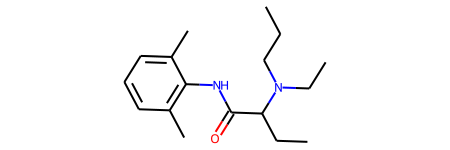

In [ ]:
mol

In [ ]:
a=g.adjacency_matrix()

In [ ]:
type(a)

torch.Tensor

In [ ]:
a.shape

torch.Size([20, 20])

In [ ]:
print(a)

tensor(indices=tensor([[ 0,  1,  1,  2,  2,  3,  3,  4,  4,  5,  3,  6,  6,  7,
                         7,  8,  6,  9,  9, 10,  9, 11, 11, 12, 12, 13, 13, 14,
                        13, 15, 15, 16, 16, 17, 17, 18, 18, 19, 18, 12],
                       [ 1,  0,  2,  1,  3,  2,  4,  3,  5,  4,  6,  3,  7,  6,
                         8,  7,  9,  6, 10,  9, 11,  9, 12, 11, 13, 12, 14, 13,
                        15, 13, 16, 15, 17, 16, 18, 17, 19, 18, 12, 18]]),
       values=tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
                      1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
                      1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
       size=(20, 20), nnz=40, layout=torch.sparse_coo)


In [ ]:
a[0]

tensor(indices=tensor([[1]]),
       values=tensor([1.]),
       size=(20,), nnz=1, layout=torch.sparse_coo)

In [ ]:
g.incidence_matrix

<bound method DGLHeteroGraph.inc of Graph(num_nodes=20, num_edges=40,
      ndata_schemes={'h': Scheme(shape=(300,), dtype=torch.float32)}
      edata_schemes={})>

In [ ]:
g1 = dgllife.utils.mol_to_bigraph(mol, canonical_atom_order= False) 

In [ ]:
g1.incidence_matrix()

TypeError: ignored

In [ ]:
g.has_edge_between(0, 1)

True

In [ ]:
g.has_edge_between(1, 0)

True

In [ ]:
g.edge_id(0,1)

In [ ]:
g.edge_id(1,0)

1

In [ ]:
dgl.seed(seed_value)

In [ ]:
g.all_edges()

(tensor([ 0,  1,  1,  2,  2,  3,  3,  4,  4,  5,  3,  6,  6,  7,  7,  8,  6,  9,
          9, 10,  9, 11, 11, 12, 12, 13, 13, 14, 13, 15, 15, 16, 16, 17, 17, 18,
         18, 19, 18, 12], dtype=torch.int32),
 tensor([ 1,  0,  2,  1,  3,  2,  4,  3,  5,  4,  6,  3,  7,  6,  8,  7,  9,  6,
         10,  9, 11,  9, 12, 11, 13, 12, 14, 13, 15, 13, 16, 15, 17, 16, 18, 17,
         19, 18, 12, 18], dtype=torch.int32))

In [ ]:
    metric = roc_auc_score
    train_dataloader, val_dataloader, test_dataloader  = loader(256)
    train_losses = []
    val_losses = []
    test_aucs = []
    # early_stopping = EarlyStopping(patience=patience, verbose=True) # initialize the early_stopping object
    # start_time = time.time()
    #optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
          prediction_all= torch.empty(0, device=device)
          labels_all= torch.empty(0, device=device)
          masks_all= torch.empty(0, device=device)
          for i, (_, mol_dgl_graph, fg, labels, masks) in enumerate(test_dataloader):
              mol_dgl_graph=mol_dgl_graph.to(device)
              labels=labels.to(device)
              masks=masks.to(device)
              fg=fg.to(device)
              prediction = model(mol_dgl_graph, fg)
              prediction_all = torch.cat((prediction_all, prediction), 0)
              labels_all = torch.cat((labels_all, labels), 0)
              masks_all = torch.cat((masks_all, masks), 0)
          average = torch.tensor([0.], device=device)
          for i in range(12):
            a1 = prediction_all[:, i][masks_all[:,i]==1]
            print(a1.shape)
            a2 = labels_all[:, i][masks_all[:,i]==1]
            print(a1.shape)
            break
            average += 100*metric(a2.view(-1).int().to('cpu'), a1.view(-1).int().to('cpu'))
            #average += 100*metric(prediction_all[:, i].view(-1), labels_all[:, i].view(-1).int()) #with pytorch-lightening
            #average += 100*metric(labels_all[:, i].view(-1).int().to('cpu'), prediction_all[:, i].view(-1).to('cpu')) # with sk-learn
          test_auc = average.item()/12

torch.Size([723])
torch.Size([723])


In [ ]:
test_auc

50.11807759602865

In [ ]:
prediction_all.shape

torch.Size([784, 12])

In [ ]:
i

0

In [ ]:
masks[:,0]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.])

In [ ]:
masks_all[-16:,0]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.])

In [ ]:
prediction_all[:, i][masks_all[:,i]==1]

tensor([2.5376e-01, 3.0510e-01, 3.0764e-01, 3.3061e-01, 2.3141e-01, 2.9255e-01,
        2.6135e-01, 6.7920e-01, 3.4894e-01, 2.4582e-01, 5.2807e-01, 3.4977e-01,
        3.0913e-01, 4.0773e-01, 3.0283e-01, 3.2431e-01, 2.4596e-01, 2.6863e-01,
        2.6690e-01, 2.9389e-01, 3.6439e-01, 3.5891e-01, 3.0317e-01, 3.1712e-01,
        3.5658e-01, 3.3361e-01, 3.4635e-01, 6.2407e-01, 3.9695e-01, 4.0710e-01,
        3.3876e-01, 3.4887e-01, 2.4658e-01, 2.8683e-01, 4.0419e-01, 5.0339e-01,
        3.0393e-01, 5.1552e-01, 3.3396e-01, 2.9348e-01, 3.7716e-01, 2.8165e-01,
        2.8619e-01, 2.7738e-01, 2.8271e-01, 2.8387e-01, 2.7034e-01, 3.3539e-01,
        2.8270e-01, 2.7148e-01, 3.4630e-01, 2.7559e-01, 2.8661e-01, 2.8030e-01,
        3.5338e-01, 2.5762e-01, 2.9472e-01, 2.9251e-01, 3.5836e-01, 3.8935e-01,
        4.1098e-01, 3.2975e-01, 3.2386e-01, 3.3978e-01, 3.8397e-01, 4.0419e-01,
        3.0838e-01, 2.8970e-01, 3.4364e-01, 3.0348e-01, 2.5461e-01, 5.1886e-01,
        1.4265e-01, 3.1189e-01, 2.8668e-

In [ ]:
a2.shape

torch.Size([27])

In [ ]:
    with torch.no_grad():
        iter = 0
        prediction_all= torch.empty(0, device=device)
        labels_all= torch.empty(0, device=device)
        masks_all= torch.empty(0, device=device)
        for i, (_, mol_dgl_graph, fg, labels, masks) in enumerate(test_dataloader):
            mol_dgl_graph=mol_dgl_graph.to(device)
            labels=labels.to(device)
            masks=masks.to(device)
            fg=fg.to(device)
            prediction = model(mol_dgl_graph, fg)
            prediction_all = torch.cat((prediction_all, prediction), 0)
            labels_all = torch.cat((labels_all, labels), 0)
            masks_all = torch.cat((masks_all, masks), 0)
        results = []
        average = torch.tensor([0.], device=device)
        for i in range(12):
          a1 = prediction_all[:, i][masks_all[:,i]==1]
          a2 = labels_all[:, i][masks_all[:,i]==1]
          results.append(100*metric(a2.view(-1).int().to('cpu'), a1.view(-1).to('cpu')))
          #average += 100*metric(prediction_all[:, i].view(-1), labels_all[:, i].view(-1).int()) # with pytorch-lightening
          #results.append(100*metric(labels_all[:, i].view(-1).int().to('cpu'), prediction_all[:, i].view(-1).to('cpu'))) # with sk-learn
          average += results[i]

In [ ]:
print('\n Test AUC is', average.item()/12)


 Test AUC is 71.85554504394531
